# Semantic segmentation task to identify ships by photos taken from a satellite

## The goal: to build a semantic segmentation model; dice maximization.

## 1. Importing necessary libraries and installing packages

In [1]:
!pip install segmentation_models_pytorch > /dev/null

In [ ]:
import os  # For interacting with the operating system
import sys  # For interacting with the Python interpreter
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computing
import gc  # For garbage collection
import random  # For generating random numbers

import cv2  # For computer vision tasks
from PIL import Image  # For image processing
import albumentations as albu  # For image augmentation

import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets

import torch  # PyTorch library
import torch.nn as nn  # PyTorch's neural network module
import torch.optim as optim  # For optimization algorithms
from segmentation_models_pytorch import utils  # Utilities for segmentation models
import segmentation_models_pytorch as smp  # PyTorch segmentation models
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets and data loaders
from tqdm import tqdm  # For displaying progress bars during loops

## 2. Ensure reproducibility

### It is crucial to debug models and separate parts of code.

In [5]:
SEED = 42  # Setting the random seed for reproducibility

def seed_everything(seed=42):
    # Setting random seed for various libraries
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything() 

## 3. Setting up global variables.

In [5]:
# drop low quality / invalid images
LOW_QUALITY_IMAGES_THRESHOLD = 52 # kb

# Undersample the majority class (images without ships)
NO_SHIP_IMAGES_AMOUNT_TO_LEAVE = 0.3

# images' size to utilize (original is 768x768)
IMAGE_SIZE = (256, 256)

# batch size for training (an initial guess)
BATCH_SIZE = 9

In [ ]:
BASE_URL = os.path.join("../input", "airbus-ship-detection")  # Defining base URL for dataset
TRAIN_URL = os.path.join(BASE_URL, "train_v2")  # URL for training data
TEST_URL = os.path.join(BASE_URL, "test_v2")  # URL for test data

# Printing number of files in train and test directories
print("Train data:", len(os.listdir(TRAIN_URL)))
print("Test data:", len(os.listdir(TEST_URL)))

Train data: 192556
Test data: 15606


### Data import

In [8]:
df = pd.read_csv(os.path.join(BASE_URL, "train_ship_segmentations_v2.csv"))
df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [ ]:
df.describe()

## 4. EDA.

### My finest gratitude to @ABNERZHANG for taking his time and identifying broken / invalid / out-of-topic images from the dataset and making the list public. The images are listed below.

In [6]:
# props: https://www.kaggle.com/c/airbus-ship-detection/discussion/62921
corrupted_train_images = ['001ea610a.jpg', 	'004f97cfb.jpg', 	'0056fbc62.jpg', 	'00a0969df.jpg', 	'011257630.jpg', 	'0121138f0.jpg', 	'0129c0880.jpg', 	'022af9c92.jpg', 	'029b05d40.jpg', 	'02b609dce.jpg', 	'02beeabc5.jpg', 	'03b8fb899.jpg', 	'0410b8f70.jpg', 	'0440ed3f9.jpg', 	'044d23efa.jpg', 	'044d23efa.jpg', 	'044d23efa.jpg', 	'044d23efa.jpg', 	'044d23efa.jpg', 	'0471e6fa0.jpg', 	'04957ae67.jpg', 	'04bb76f99.jpg', 	'04e726188.jpg', 	'04eb1e8b4.jpg', 	'0535e1a6c.jpg', 	'05417a156.jpg', 	'0550b8734.jpg', 	'0564b16e7.jpg', 	'056949650.jpg', 	'059efc2ee.jpg', 	'05fa17552.jpg', 	'05fa17552.jpg', 	'062c18c1e.jpg', 	'06709073b.jpg', 	'06bc8167b.jpg', 	'06df94692.jpg', 	'06f01a9e2.jpg', 	'072d8cb01.jpg', 	'081674331.jpg', 	'082369109.jpg', 	'08242a82c.jpg', 	'0836642f7.jpg', 	'0845c0106.jpg', 	'0845c0106.jpg', 	'08f71ff06.jpg', 	'09473d9ad.jpg', 	'097403ec0.jpg', 	'097e21dfe.jpg', 	'098ad4a29.jpg', 	'0aaea74cc.jpg', 	'0ab2b818a.jpg', 	'0abdfa368.jpg', 	'0afa40357.jpg', 	'0b2a2aceb.jpg', 	'0b7d1c160.jpg', 	'0b7d1c160.jpg', 	'0b7d1c160.jpg', 	'0bbf29b74.jpg', 	'0c2d85ef6.jpg', 	'0c31bc7d4.jpg', 	'0c34ffdf6.jpg', 	'0c53e690b.jpg', 	'0c53e690b.jpg', 	'0c770634c.jpg', 	'0cdd31700.jpg', 	'0d3de0664.jpg', 	'0d7c1d566.jpg', 	'0d7c1d566.jpg', 	'0d7c1d566.jpg', 	'0dcfd29d7.jpg', 	'0dd67a278.jpg', 	'0e1c8dd01.jpg', 	'0e59df7fe.jpg', 	'0f0f6504d.jpg', 	'0f2fef46e.jpg', 	'0f71d5a4b.jpg', 	'10338335f.jpg', 	'10338335f.jpg', 	'1060c513f.jpg', 	'10e2b01e8.jpg', 	'10e2b01e8.jpg', 	'10e555277.jpg', 	'10f624e87.jpg', 	'1116ca6f4.jpg', 	'1116ca6f4.jpg', 	'1121598a1.jpg', 	'1121598a1.jpg', 	'1121598a1.jpg', 	'1121598a1.jpg', 	'1121598a1.jpg', 	'11391a0f1.jpg', 	'11c8b0413.jpg', 	'11c969cd3.jpg', 	'11de89754.jpg', 	'11f24ec8f.jpg', 	'121364ac3.jpg', 	'121364ac3.jpg', 	'121364ac3.jpg', 	'121364ac3.jpg', 	'121364ac3.jpg', 	'121364ac3.jpg', 	'121364ac3.jpg', 	'123929f3e.jpg', 	'125f07a28.jpg', 	'125f07a28.jpg', 	'125f07a28.jpg', 	'125f07a28.jpg', 	'125f07a28.jpg', 	'125f07a28.jpg', 	'1273f5123.jpg', 	'128267718.jpg', 	'12ab97857.jpg', 	'12ab97857.jpg', 	'12ab97857.jpg', 	'12ab97857.jpg', 	'12c801dfc.jpg', 	'12efb0b23.jpg', 	'12f2979c5.jpg', 	'135cf41db.jpg', 	'1393aeaae.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13a4986cf.jpg', 	'13c59294e.jpg', 	'13ed945ce.jpg', 	'1421f4b75.jpg', 	'147fb4f7a.jpg', 	'147fb4f7a.jpg', 	'14fb89f8b.jpg', 	'156d26e02.jpg', 	'15ffdc548.jpg', 	'15ffdc548.jpg', 	'162ccd90a.jpg', 	'162ccd90a.jpg', 	'162ccd90a.jpg', 	'162ccd90a.jpg', 	'16cc7f0a0.jpg', 	'1746475bb.jpg', 	'1752c7793.jpg', 	'1752c7793.jpg', 	'175f0bc4e.jpg', 	'175f0bc4e.jpg', 	'175f0bc4e.jpg', 	'175f0bc4e.jpg', 	'175f0bc4e.jpg', 	'175f0bc4e.jpg', 	'17d7c4bd1.jpg', 	'18290f091.jpg', 	'182a56e33.jpg', 	'18819e62b.jpg', 	'18cc4e06c.jpg', 	'18d89bbe2.jpg', 	'18e112157.jpg', 	'191e74913.jpg', 	'1958f1fa3.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'195b95a94.jpg', 	'198fff243.jpg', 	'1a428fcf7.jpg', 	'1a4e46004.jpg', 	'1aaf44c88.jpg', 	'1aaf44c88.jpg', 	'1aaf44c88.jpg', 	'1aec1fd16.jpg', 	'1b1e24318.jpg', 	'1b2abc76b.jpg', 	'1b2abc76b.jpg', 	'1b2abc76b.jpg', 	'1b2abc76b.jpg', 	'1b2abc76b.jpg', 	'1b323e779.jpg', 	'1b42c0672.jpg', 	'1b42c0672.jpg', 	'1b42c0672.jpg', 	'1b42c0672.jpg', 	'1b61ac95b.jpg', 	'1b6961c51.jpg', 	'1bae4f230.jpg', 	'1bc27c25c.jpg', 	'1c2f5a66f.jpg', 	'1c4b028af.jpg', 	'1c4cfa04e.jpg', 	'1ca76df97.jpg', 	'1cca0635a.jpg', 	'1cca0635a.jpg', 	'1cd965402.jpg', 	'1cfbd2620.jpg', 	'1d149759c.jpg', 	'1e7ab802f.jpg', 	'1e81c6d44.jpg', 	'1eb305c09.jpg', 	'1ec35352b.jpg', 	'1ed0b5229.jpg', 	'1f069dfda.jpg', 	'1f480fe3b.jpg', 	'1f5ad8dc6.jpg', 	'1f7011fd7.jpg', 	'1f928ebdc.jpg', 	'1f98ceb8e.jpg', 	'201c1380a.jpg', 	'2038d392e.jpg', 	'203c2fc8f.jpg', 	'20788d975.jpg', 	'20ae01f60.jpg', 	'2107b4f7f.jpg', 	'215889f73.jpg', 	'218c4f3cc.jpg', 	'21e3d870d.jpg', 	'21e3d870d.jpg', 	'22209626a.jpg', 	'23823f6ab.jpg', 	'23b83b31f.jpg', 	'243e947a8.jpg', 	'243e947a8.jpg', 	'243e947a8.jpg', 	'246a373a7.jpg', 	'246a373a7.jpg', 	'246a373a7.jpg', 	'246a373a7.jpg', 	'24860ff6d.jpg', 	'24860ff6d.jpg', 	'24a673ebf.jpg', 	'24c7238c3.jpg', 	'250876151.jpg', 	'251d13e3c.jpg', 	'2556c121c.jpg', 	'259c985dd.jpg', 	'26097bc5c.jpg', 	'263d07f21.jpg', 	'263d07f21.jpg', 	'26779b5d4.jpg', 	'26dcf3e39.jpg', 	'272070a14.jpg', 	'2790fc7f6.jpg', 	'2794d186c.jpg', 	'27fd4f43a.jpg', 	'282814b50.jpg', 	'2857528a0.jpg', 	'2857528a0.jpg', 	'285846038.jpg', 	'28b516013.jpg', 	'28db2ad2c.jpg', 	'29179588e.jpg', 	'294b4f564.jpg', 	'294cd1974.jpg', 	'294cd1974.jpg', 	'294cd1974.jpg', 	'29c475be6.jpg', 	'29c475be6.jpg', 	'2a3067530.jpg', 	'2a334e184.jpg', 	'2a334e184.jpg', 	'2a94b0e35.jpg', 	'2aba24f05.jpg', 	'2adc56e9d.jpg', 	'2ae0bd09b.jpg', 	'2b8bcadce.jpg', 	'2c146ada8.jpg', 	'2c5811d8f.jpg', 	'2d6e477f7.jpg', 	'2d8c8fd14.jpg', 	'2e9dc4312.jpg', 	'2eb0ac230.jpg', 	'2ecf72a4d.jpg', 	'2ee0dd2da.jpg', 	'2f10fe1a8.jpg', 	'2f1ba5759.jpg', 	'2f1d25b7e.jpg', 	'2f84e54fc.jpg', 	'3094427d1.jpg', 	'30a2f6511.jpg', 	'311fd7467.jpg', 	'3153e53de.jpg', 	'3153e53de.jpg', 	'3153e53de.jpg', 	'3153e53de.jpg', 	'3153e53de.jpg', 	'316c9615c.jpg', 	'316c9615c.jpg', 	'31c9d8cd8.jpg', 	'31c9d8cd8.jpg', 	'325c5d511.jpg', 	'329f36711.jpg', 	'32d3f6fbc.jpg', 	'32f191dd2.jpg', 	'3391b86d6.jpg', 	'34953e378.jpg', 	'34aee05e0.jpg', 	'34ce5bd83.jpg', 	'34ce5bd83.jpg', 	'34ce5bd83.jpg', 	'34ce5bd83.jpg', 	'34ce5bd83.jpg', 	'34ce5bd83.jpg', 	'3679c695e.jpg', 	'368606be6.jpg', 	'36abb1696.jpg', 	'36c1210a7.jpg', 	'36df7ff28.jpg', 	'36f935970.jpg', 	'36f935970.jpg', 	'36f935970.jpg', 	'36fb7e17c.jpg', 	'36fb7e17c.jpg', 	'372145a83.jpg', 	'373110419.jpg', 	'376a323d1.jpg', 	'376a323d1.jpg', 	'377f4db4c.jpg', 	'37fc39fee.jpg', 	'386cd5f4d.jpg', 	'38bf1471f.jpg', 	'38fe281b8.jpg', 	'39330e4b2.jpg', 	'397d8e801.jpg', 	'39ad874e3.jpg', 	'3a25d66bc.jpg', 	'3a25d66bc.jpg', 	'3abda681a.jpg', 	'3ad127b3e.jpg', 	'3ad127b3e.jpg', 	'3adc5fee3.jpg', 	'3b083919e.jpg', 	'3b98157ed.jpg', 	'3baa33013.jpg', 	'3bbb81478.jpg', 	'3bbb81478.jpg', 	'3c1b0cc0e.jpg', 	'3c2fef695.jpg', 	'3c2fef695.jpg', 	'3c36e3987.jpg', 	'3c74edc8e.jpg', 	'3c74edc8e.jpg', 	'3c74edc8e.jpg', 	'3c74edc8e.jpg', 	'3c74edc8e.jpg', 	'3c74edc8e.jpg', 	'3c74edc8e.jpg', 	'3c74edc8e.jpg', 	'3c9a461fb.jpg', 	'3cc1941f8.jpg', 	'3cc1941f8.jpg', 	'3cc1941f8.jpg', 	'3cc1941f8.jpg', 	'3cc1941f8.jpg', 	'3cdf7ef2c.jpg', 	'3d490be85.jpg', 	'3d549b3e5.jpg', 	'3d549b3e5.jpg', 	'3d7cd914a.jpg', 	'3dee10e9a.jpg', 	'3dee10e9a.jpg', 	'3df82cd9d.jpg', 	'3df95ce1c.jpg', 	'3e4b49b95.jpg', 	'3e536ebb4.jpg', 	'3e536ebb4.jpg', 	'3e536ebb4.jpg', 	'3e536ebb4.jpg', 	'3e536ebb4.jpg', 	'3e536ebb4.jpg', 	'3eabd2cc0.jpg', 	'3eb3be56e.jpg', 	'3ec4320cf.jpg', 	'3ec985aaa.jpg', 	'3ec985aaa.jpg', 	'3ec985aaa.jpg', 	'3ed47493a.jpg', 	'3ed47493a.jpg', 	'3ed47493a.jpg', 	'3ed47493a.jpg', 	'3ed47493a.jpg', 	'3ed47493a.jpg', 	'3f242bb4f.jpg', 	'3f477dc12.jpg', 	'40d2ab5b7.jpg', 	'40f3a5d07.jpg', 	'40f5e3905.jpg', 	'418bef51a.jpg', 	'418bef51a.jpg', 	'418bef51a.jpg', 	'4211b6416.jpg', 	'42afdde16.jpg', 	'42afdde16.jpg', 	'42c390ebc.jpg', 	'43142c0f3.jpg', 	'43f44815e.jpg', 	'442e83063.jpg', 	'447de2b0c.jpg', 	'4482203ed.jpg', 	'448a0f27a.jpg', 	'448a0f27a.jpg', 	'44a6d3b89.jpg', 	'44a6d3b89.jpg', 	'44ea1a5ee.jpg', 	'450c64160.jpg', 	'450c64160.jpg', 	'450c64160.jpg', 	'450c64160.jpg', 	'450c64160.jpg', 	'45132aa5c.jpg', 	'45132aa5c.jpg', 	'45132aa5c.jpg', 	'45132aa5c.jpg', 	'45132aa5c.jpg', 	'45132aa5c.jpg', 	'45132aa5c.jpg', 	'466048462.jpg', 	'467c0417c.jpg', 	'467c0417c.jpg', 	'46febe260.jpg', 	'4788a79c6.jpg', 	'48ec32e9a.jpg', 	'492301277.jpg', 	'492301277.jpg', 	'492301277.jpg', 	'493e11743.jpg', 	'49bcfae53.jpg', 	'49c76f263.jpg', 	'4b756254e.jpg', 	'4b92ed88c.jpg', 	'4bb41c80a.jpg', 	'4bc1c6b8d.jpg', 	'4c50c969d.jpg', 	'4d53f4d68.jpg', 	'4d54ee235.jpg', 	'4d76be2e0.jpg', 	'4dd93f56d.jpg', 	'4df182b49.jpg', 	'4e9e5b0f5.jpg', 	'4eb959fc1.jpg', 	'4eb959fc1.jpg', 	'4eec3f2eb.jpg', 	'4f16e3f9b.jpg', 	'503458960.jpg', 	'503458960.jpg', 	'5055e7ab6.jpg', 	'50d65abf2.jpg', 	'50d65abf2.jpg', 	'50f6aa064.jpg', 	'51ce7d5d9.jpg', 	'51ed5a313.jpg', 	'520adaafd.jpg', 	'521cf4845.jpg', 	'5224e6b3c.jpg', 	'523be8565.jpg', 	'523be8565.jpg', 	'523be8565.jpg', 	'523be8565.jpg', 	'523be8565.jpg', 	'5276e9661.jpg', 	'529d83d09.jpg', 	'52b0b2235.jpg', 	'52c959c77.jpg', 	'52d02a0bc.jpg', 	'5386b5c70.jpg', 	'5390c70f7.jpg', 	'53c06dd6e.jpg', 	'53c0b3258.jpg', 	'53c0b3258.jpg', 	'53c0b3258.jpg', 	'53c0b3258.jpg', 	'53c22ea24.jpg', 	'53c22ea24.jpg', 	'53c22ea24.jpg', 	'53d3773d3.jpg', 	'542fd9848.jpg', 	'546396805.jpg', 	'54b526acc.jpg', 	'54b526acc.jpg', 	'54b526acc.jpg', 	'5518fa0e9.jpg', 	'55491f573.jpg', 	'55796ba40.jpg', 	'5591f25c4.jpg', 	'56417e7af.jpg', 	'565758174.jpg', 	'5713a51d7.jpg', 	'572915a5d.jpg', 	'572ac7307.jpg', 	'572ac7307.jpg', 	'5753761d1.jpg', 	'57c111440.jpg', 	'57e7854e1.jpg', 	'5802e2635.jpg', 	'5802e2635.jpg', 	'59598d6e5.jpg', 	'59caafd26.jpg', 	'5a15a0ff4.jpg', 	'5a60d7464.jpg', 	'5a8fe36af.jpg', 	'5ab29febe.jpg', 	'5afadfeeb.jpg', 	'5b0573b2e.jpg', 	'5b10c3aee.jpg', 	'5b38b4f5e.jpg', 	'5c2b7e0b0.jpg', 	'5c6caad55.jpg', 	'5c76756cd.jpg', 	'5ce9d3971.jpg', 	'5d0c192b6.jpg', 	'5d3fe73f6.jpg', 	'5d518d410.jpg', 	'5d800157c.jpg', 	'5e0f3604d.jpg', 	'5e248115d.jpg', 	'5e248115d.jpg', 	'5e248115d.jpg', 	'5e248115d.jpg', 	'5e248115d.jpg', 	'5e248115d.jpg', 	'5e248115d.jpg', 	'5e248115d.jpg', 	'5f60979f4.jpg', 	'5f86c6c78.jpg', 	'60005f697.jpg', 	'609537e9c.jpg', 	'609537e9c.jpg', 	'60dc6af4e.jpg', 	'60ff4d19f.jpg', 	'618d1841e.jpg', 	'619975dba.jpg', 	'61e0635a9.jpg', 	'6241f480a.jpg', 	'6241f480a.jpg', 	'6251d7e1f.jpg', 	'6368f2024.jpg', 	'63aa75dca.jpg', 	'63aa75dca.jpg', 	'63e84277f.jpg', 	'644467444.jpg', 	'644e9cb14.jpg', 	'644e9cb14.jpg', 	'644e9cb14.jpg', 	'64825fc60.jpg', 	'64cfaebae.jpg', 	'6546dc45d.jpg', 	'659adba89.jpg',  '66c7c3361.jpg',  '66c7c3361.jpg', 	'66c7c3361.jpg', 	'66c7c3361.jpg', 	'671085a33.jpg', 	'67186dc31.jpg', 	'67ad5177d.jpg', 	'67c57bf5a.jpg', 	'67ee19d95.jpg', 	'688002f2e.jpg', 	'688002f2e.jpg', 	'688002f2e.jpg', 	'68e1516bf.jpg', 	'68e862af9.jpg', 	'68e862af9.jpg', 	'693e880b4.jpg', 	'697f60370.jpg', 	'697f60370.jpg', 	'6a47590e6.jpg', 	'6a4fc4db1.jpg', 	'6ab5ceabd.jpg', 	'6ae2803e7.jpg', 	'6ae2803e7.jpg', 	'6bbcd7d96.jpg', 	'6be716a29.jpg', 	'6be716a29.jpg', 	'6d619a7f1.jpg', 	'6e5b1abcc.jpg', 	'6e76845f8.jpg', 	'6e931cf2d.jpg', 	'6ea82464f.jpg', 	'6ea82464f.jpg', 	'6ea82464f.jpg', 	'6ea82464f.jpg', 	'6eb89349c.jpg', 	'6eb89349c.jpg', 	'6eb89349c.jpg', 	'6ef678207.jpg', 	'6f7123546.jpg', 	'6f7123546.jpg', 	'6f7123546.jpg', 	'6f7123546.jpg', 	'6f7123546.jpg', 	'6f7123546.jpg', 	'705361b29.jpg', 	'708f83f87.jpg', 	'710bffeec.jpg', 	'7113c5748.jpg', 	'7124ba0d1.jpg', 	'724d8c327.jpg', 	'73c7c74d9.jpg', 	'73fffb68b.jpg', 	'740cd0c9a.jpg', 	'741e6509a.jpg', 	'74c3317a9.jpg', 	'74c3317a9.jpg', 	'74c3317a9.jpg', 	'7509a3e18.jpg', 	'75b51c647.jpg', 	'75df1ca72.jpg', 	'75df1ca72.jpg', 	'75df1ca72.jpg', 	'7706b1f40.jpg', 	'7728c63eb.jpg', 	'7728c63eb.jpg', 	'7728c63eb.jpg', 	'7728c63eb.jpg', 	'7758aed5a.jpg', 	'7758aed5a.jpg', 	'7758aed5a.jpg', 	'7758aed5a.jpg', 	'7758aed5a.jpg', 	'77970be12.jpg', 	'77970be12.jpg', 	'77b2f51dd.jpg', 	'77d398335.jpg', 	'77f28a157.jpg', 	'77f28a157.jpg', 	'77f28a157.jpg', 	'77f4b6a70.jpg', 	'7818737fa.jpg', 	'78a5b0a2a.jpg', 	'790aae2ff.jpg', 	'791e81a92.jpg', 	'791e81a92.jpg', 	'791e81a92.jpg', 	'791e81a92.jpg', 	'791e81a92.jpg', 	'791e81a92.jpg', 	'791e81a92.jpg', 	'793a0cac2.jpg', 	'793a0cac2.jpg', 	'79472acc5.jpg', 	'79472acc5.jpg', 	'79472acc5.jpg', 	'7a00cab8f.jpg', 	'7a3f61040.jpg', 	'7a7b88704.jpg', 	'7a81bcb55.jpg', 	'7a81bcb55.jpg', 	'7af027173.jpg', 	'7b1082fee.jpg', 	'7b1082fee.jpg', 	'7b17a79b2.jpg', 	'7b17a79b2.jpg', 	'7b17a79b2.jpg', 	'7b1e5d175.jpg', 	'7b6cbedee.jpg', 	'7ba7a8b6e.jpg', 	'7ba7a8b6e.jpg', 	'7c8444029.jpg', 	'7d66a0505.jpg', 	'7ddb1e124.jpg', 	'7ea0f7949.jpg', 	'7eee35091.jpg', 	'7efe03bc1.jpg', 	'7f036720e.jpg', 	'7f14163e5.jpg', 	'7f92230cf.jpg', 	'7f92230cf.jpg', 	'7fdde64aa.jpg', 	'7ff71c5c0.jpg', 	'80c853e4e.jpg', 	'811d2221d.jpg', 	'812ad8bb1.jpg', 	'813c108f8.jpg', 	'813c108f8.jpg', 	'81fac3d6f.jpg', 	'82169ec3e.jpg', 	'83d568658.jpg', 	'83ecfe851.jpg', 	'83fde00e4.jpg', 	'83fe62cb9.jpg', 	'84520abab.jpg', 	'848c0cd9a.jpg', 	'84aac0e47.jpg', 	'84ad59a73.jpg', 	'84f53fddd.jpg', 	'84f53fddd.jpg', 	'84f53fddd.jpg', 	'851681437.jpg', 	'855a4d195.jpg', 	'861cf2b66.jpg', 	'86369c225.jpg', 	'86b2ff952.jpg', 	'86b2ff952.jpg', 	'86e4504c2.jpg', 	'8789ec5ca.jpg', 	'87cd384a1.jpg', 	'88193b368.jpg', 	'8822d4241.jpg', 	'88280d7e6.jpg', 	'884f9d5fa.jpg', 	'885010570.jpg', 	'886e22385.jpg', 	'890b7bd90.jpg', 	'89187f4f1.jpg', 	'89c4b957a.jpg', 	'89d30c34a.jpg', 	'8a0542232.jpg', 	'8a1b69841.jpg', 	'8ad511060.jpg', 	'8b6700224.jpg', 	'8b7472a2a.jpg', 	'8b96ac931.jpg', 	'8b96ac931.jpg', 	'8bf7a14fa.jpg', 	'8bffacca1.jpg', 	'8c0a50f5d.jpg', 	'8cc6108cd.jpg', 	'8d3de19bf.jpg', 	'8d3de19bf.jpg', 	'8d3de19bf.jpg', 	'8d627783a.jpg', 	'8d7cec72f.jpg', 	'8d7cec72f.jpg', 	'8d7cec72f.jpg', 	'8d7cec72f.jpg', 	'8e14cef41.jpg', 	'8e14cef41.jpg', 	'8e4133c62.jpg', 	'8e4133c62.jpg', 	'8e4eafe06.jpg', 	'8e4f6eb50.jpg', 	'8e951a256.jpg', 	'8edb2e579.jpg', 	'8edbc16aa.jpg', 	'8f222e017.jpg', 	'8f65e8b8a.jpg', 	'8f65e8b8a.jpg', 	'8f65e8b8a.jpg', 	'8f65e8b8a.jpg', 	'8f6bdd5c7.jpg', 	'901411c74.jpg', 	'90169bab2.jpg', 	'90f82f54c.jpg', 	'913c306c9.jpg', 	'913db052e.jpg', 	'91d306e75.jpg', 	'9287423dd.jpg', 	'928e51acb.jpg', 	'9290f50b3.jpg', 	'92937ff78.jpg', 	'929aae911.jpg', 	'929aae911.jpg', 	'929aae911.jpg', 	'943e4f466.jpg', 	'945905d30.jpg', 	'945905d30.jpg', 	'945905d30.jpg', 	'945905d30.jpg', 	'945905d30.jpg', 	'945905d30.jpg', 	'945905d30.jpg', 	'945905d30.jpg', 	'945d65a8e.jpg', 	'947f67766.jpg', 	'94827962f.jpg', 	'94827962f.jpg', 	'94827962f.jpg', 	'94a239f3e.jpg', 	'94ab7c409.jpg', 	'94d773f00.jpg', 	'94eddc51a.jpg', 	'94eddc51a.jpg', 	'94eddc51a.jpg', 	'94ef0ca29.jpg', 	'955f86d96.jpg', 	'955f86d96.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'957e87a7a.jpg', 	'95e202702.jpg', 	'963b3dcb9.jpg', 	'9646124e4.jpg', 	'9646124e4.jpg', 	'9646124e4.jpg', 	'96b719c2c.jpg', 	'96b719c2c.jpg', 	'96caa5aa1.jpg', 	'96fbcff1c.jpg', 	'971a709ac.jpg', 	'97397ce75.jpg', 	'97c3b23c2.jpg', 	'97dd70b27.jpg', 	'97fdde548.jpg', 	'97fdde548.jpg', 	'98a678c5c.jpg', 	'98aedefbe.jpg', 	'998c9abac.jpg', 	'998c9abac.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99aecf87e.jpg', 	'99d1c9973.jpg', 	'9a554a5fc.jpg', 	'9aca34158.jpg', 	'9aca34158.jpg', 	'9aca34158.jpg', 	'9aca34158.jpg', 	'9aca34158.jpg', 	'9aca34158.jpg', 	'9aca34158.jpg', 	'9bcaf1de8.jpg', 	'9bee051e1.jpg', 	'9bee051e1.jpg', 	'9c2cdc939.jpg', 	'9c31768d7.jpg', 	'9c4928b09.jpg', 	'9c4b93551.jpg', 	'9c67f71b4.jpg', 	'9c9c811d4.jpg', 	'9c9c811d4.jpg', 	'9c9c811d4.jpg', 	'9c9c811d4.jpg', 	'9ccf54fca.jpg', 	'9ced8e171.jpg', 	'9d946e84d.jpg', 	'9d946e84d.jpg', 	'9de72c2f4.jpg', 	'9de779fbe.jpg', 	'9dfa90c01.jpg', 	'9e240ca49.jpg', 	'9eb247e6e.jpg', 	'9f5778842.jpg', 	'9f70223f9.jpg', 	'9f99779fb.jpg', 	'9ff44c0b9.jpg', 	'9ffd198e3.jpg', 	'9ffd198e3.jpg', 	'a04fa2434.jpg', 	'a070c59b5.jpg', 	'a0b3556ee.jpg', 	'a0b5ca69a.jpg', 	'a0c1973d2.jpg', 	'a1552561a.jpg', 	'a186d9936.jpg', 	'a1bfe1c37.jpg', 	'a1d1f20b0.jpg', 	'a1d1f20b0.jpg', 	'a1d1f20b0.jpg', 	'a1d1f20b0.jpg', 	'a1d1f20b0.jpg', 	'a1d1f20b0.jpg', 	'a20a04ffd.jpg', 	'a20a04ffd.jpg', 	'a231565d2.jpg', 	'a28a6fdf1.jpg', 	'a2a43ca82.jpg', 	'a2a43ca82.jpg', 	'a2a43ca82.jpg', 	'a2a43ca82.jpg', 	'a2e8cc5ea.jpg', 	'a2fb250ae.jpg', 	'a360ed9ba.jpg', 	'a394bd272.jpg', 	'a394bd272.jpg', 	'a3e0f84e0.jpg', 	'a4044d9c4.jpg', 	'a405e7a4f.jpg', 	'a484f9291.jpg', 	'a51cd98f9.jpg', 	'a527eef56.jpg', 	'a57a15459.jpg', 	'a593aded5.jpg', 	'a5958a38e.jpg', 	'a614b969c.jpg', 	'a614b969c.jpg', 	'a61cb16c0.jpg', 	'a631a6d34.jpg', 	'a6557e6d1.jpg', 	'a6654388a.jpg', 	'a6654388a.jpg', 	'a6bff6a84.jpg', 	'a6dee3873.jpg', 	'a7168ea7e.jpg', 	'a75dc5c66.jpg', 	'a78a82b25.jpg', 	'a84edcedd.jpg', 	'a84edcedd.jpg', 	'a89a55ae5.jpg', 	'a9212f0cf.jpg', 	'a9ee29812.jpg', 	'aa3462e34.jpg', 	'aa7ba1f19.jpg', 	'aac1fabc1.jpg', 	'aac4ddc64.jpg', 	'aad242acb.jpg', 	'aad242acb.jpg', 	'aad242acb.jpg', 	'ab02c05b9.jpg', 	'ab13e2ab9.jpg', 	'ab62a3930.jpg', 	'ab9950dd7.jpg', 	'abe42fbe5.jpg', 	'ac373eed2.jpg', 	'ac7d221f1.jpg', 	'ac87e8c6f.jpg', 	'ad0992d9f.jpg', 	'ad1373ee6.jpg', 	'ad246fb45.jpg', 	'ada080535.jpg', 	'ade08b9ae.jpg', 	'ade08b9ae.jpg', 	'ade08b9ae.jpg', 	'ade08b9ae.jpg', 	'ade08b9ae.jpg', 	'ae3f92490.jpg', 	'ae3f92490.jpg', 	'ae6ab7bbb.jpg', 	'aea685d5f.jpg', 	'af904d064.jpg', 	'afc5f7664.jpg', 	'b0aac75ec.jpg', 	'b0f535cfa.jpg', 	'b19a68a03.jpg', 	'b1dfd43e8.jpg', 	'b2033ad6e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b273e414e.jpg', 	'b312ba697.jpg', 	'b36748163.jpg', 	'b36748163.jpg', 	'b36748163.jpg', 	'b36748163.jpg', 	'b38ed41cc.jpg', 	'b3a80a390.jpg', 	'b3ba65123.jpg', 	'b450ebacd.jpg', 	'b450ebacd.jpg', 	'b492ad045.jpg', 	'b492ad045.jpg', 	'b492ad045.jpg', 	'b4bfa105d.jpg', 	'b4ee2ca17.jpg', 	'b50841a31.jpg', 	'b534fb4c1.jpg', 	'b5367e221.jpg', 	'b53a91be6.jpg', 	'b558e60c6.jpg', 	'b558e60c6.jpg', 	'b558e60c6.jpg', 	'b558e60c6.jpg', 	'b558e60c6.jpg', 	'b5ed8fda5.jpg', 	'b68988217.jpg', 	'b717ec4e2.jpg', 	'b7226ace1.jpg', 	'b7226ace1.jpg', 	'b7226ace1.jpg', 	'b7327dc9f.jpg', 	'b7963b4f7.jpg', 	'b79cadd39.jpg', 	'b7ac727ff.jpg', 	'b7e682ee3.jpg', 	'b84cca6e1.jpg', 	'b88df0a00.jpg', 	'b8ba74347.jpg', 	'b8ce38df4.jpg', 	'b8d613105.jpg', 	'b8d613105.jpg', 	'b8d613105.jpg', 	'b8d613105.jpg', 	'b8e8c9ec0.jpg', 	'b8e8c9ec0.jpg', 	'b8e8c9ec0.jpg', 	'b8f10ed3b.jpg', 	'b92877a7d.jpg', 	'b962e3891.jpg', 	'b9ec8b476.jpg', 	'ba748a160.jpg', 	'bad876d9c.jpg', 	'baefe2d18.jpg', 	'bb988d531.jpg', 	'bbe118d0b.jpg', 	'bbf13112d.jpg', 	'bbf17abad.jpg', 	'bbfa8b65b.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bc5e8715d.jpg', 	'bcafee0d1.jpg', 	'bcdd64143.jpg', 	'bdfce70ce.jpg', 	'be0b7192c.jpg', 	'beb4337d4.jpg', 	'bed0cf7e2.jpg', 	'bf5d7aabc.jpg', 	'bf8475532.jpg', 	'c0115713d.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c02a1ee0a.jpg', 	'c11bb1a95.jpg', 	'c186a9757.jpg', 	'c1edb197d.jpg', 	'c49dc7378.jpg', 	'c4badc806.jpg', 	'c5081e3c3.jpg', 	'c51ddef91.jpg', 	'c51ddef91.jpg', 	'c534e92c9.jpg', 	'c584c040a.jpg', 	'c5fb7b03a.jpg', 	'c621945f5.jpg', 	'c6f39e242.jpg', 	'c71d1f916.jpg', 	'c73f75ce3.jpg', 	'c7c4257b4.jpg', 	'c8129e2dd.jpg', 	'c83a06609.jpg', 	'c8d60d57e.jpg', 	'c8fedcb43.jpg', 	'c93f37bc5.jpg', 	'c93f37bc5.jpg', 	'c93f37bc5.jpg', 	'c93f37bc5.jpg', 	'c93f37bc5.jpg', 	'c9c0a11e5.jpg', 	'ca24984bf.jpg', 	'ca74d74a8.jpg', 	'ca758c00e.jpg', 	'cafa07e68.jpg', 	'cafa07e68.jpg', 	'cb2f37b03.jpg', 	'cb5694927.jpg', 	'cba69d4f1.jpg', 	'cbdd0c687.jpg', 	'cbf4fe49e.jpg', 	'cbf7391e5.jpg', 	'cc149f2dc.jpg', 	'ccdeae66c.jpg', 	'cd0ac5be2.jpg', 	'cd795a2f1.jpg', 	'cd831c5bb.jpg', 	'ce4545072.jpg', 	'cebbdf48d.jpg', 	'cff4b96b3.jpg', 	'cff4b96b3.jpg', 	'cffbb9ce1.jpg', 	'cffbb9ce1.jpg', 	'd02c1e0fd.jpg', 	'd069b2b78.jpg', 	'd0ea975f2.jpg', 	'd0ebae16c.jpg', 	'd1384d7be.jpg', 	'd140a9b04.jpg', 	'd18dd7aad.jpg', 	'd18dd7aad.jpg', 	'd18dd7aad.jpg', 	'd2113b597.jpg', 	'd248d957d.jpg', 	'd28124a24.jpg', 	'd2a8843df.jpg', 	'd2e3ddbd9.jpg', 	'd378cca4f.jpg', 	'd3ea128b2.jpg', 	'd40c1e4c1.jpg', 	'd442caa88.jpg', 	'd44b2b115.jpg', 	'd4514be2e.jpg', 	'd4674fc94.jpg', 	'd4bf25cbc.jpg', 	'd57c300de.jpg', 	'd59be973a.jpg', 	'd5bf3df92.jpg', 	'd5cadb1c2.jpg', 	'd5ffcae25.jpg', 	'd6232b43b.jpg', 	'd63f8ebb5.jpg', 	'd683342dd.jpg', 	'd696913ea.jpg', 	'd6c292a55.jpg', 	'd6d014ce6.jpg', 	'd6d014ce6.jpg', 	'd6d014ce6.jpg', 	'd6d014ce6.jpg', 	'd6d90a4d8.jpg', 	'd6f732d21.jpg', 	'd71d4086c.jpg', 	'd7a2a70ed.jpg', 	'd7d2c83fe.jpg', 	'd81c03426.jpg', 	'd8666823f.jpg', 	'd896a7f9b.jpg', 	'd8f027ae7.jpg', 	'd8f2d724d.jpg', 	'd92250493.jpg', 	'd9a003e3d.jpg', 	'd9a003e3d.jpg', 	'd9aebb1b4.jpg', 	'd9aebb1b4.jpg', 	'd9aebb1b4.jpg', 	'd9fb019d3.jpg', 	'dad2579cd.jpg', 	'dafdda969.jpg', 	'db26b4667.jpg', 	'db2d5952a.jpg', 	'db2d5952a.jpg', 	'db5d787da.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'db89227f9.jpg', 	'dbf82efe8.jpg', 	'dbf82efe8.jpg', 	'dc4ee69ba.jpg', 	'dccc88b1d.jpg', 	'dce80be08.jpg', 	'dd454e6db.jpg', 	'dd64a153b.jpg', 	'ddfc36407.jpg', 	'de4ec4586.jpg', 	'de59ee81b.jpg', 	'de61c760e.jpg', 	'de6cc9f6e.jpg', 	'de6cc9f6e.jpg', 	'de6cc9f6e.jpg', 	'de6cc9f6e.jpg', 	'debf6c97c.jpg', 	'dfa88aebf.jpg', 	'dfa88aebf.jpg', 	'e045e7416.jpg', 	'e0853b37a.jpg', 	'e0d10e477.jpg', 	'e0dbc7433.jpg', 	'e0edbc8b3.jpg', 	'e0ffa10b5.jpg', 	'e106870c9.jpg', 	'e1171d6aa.jpg', 	'e19e6df8d.jpg', 	'e1df61c04.jpg', 	'e1fe052e7.jpg', 	'e20e64d5d.jpg', 	'e20e64d5d.jpg', 	'e20e64d5d.jpg', 	'e20e64d5d.jpg', 	'e20e64d5d.jpg', 	'e20e64d5d.jpg', 	'e20e64d5d.jpg', 	'e23ff6a91.jpg', 	'e28d9f0df.jpg', 	'e2b48de41.jpg', 	'e2b48de41.jpg', 	'e3345a111.jpg', 	'e33b2a936.jpg', 	'e39aa7e65.jpg', 	'e413ed0e0.jpg', 	'e498fb2ed.jpg', 	'e5670efa9.jpg', 	'e5ed63911.jpg', 	'e6cd5dd1c.jpg', 	'e6cd5dd1c.jpg', 	'e6cd5dd1c.jpg', 	'e72ecff7e.jpg', 	'e7c9da271.jpg', 	'e7f471180.jpg', 	'e7f471180.jpg', 	'e89fb0a51.jpg', 	'e8b968c47.jpg', 	'e93679f6d.jpg', 	'e9378ca62.jpg', 	'e962150c2.jpg', 	'e9a895ff6.jpg', 	'e9c5a80c7.jpg', 	'e9d6705b1.jpg', 	'e9d6705b1.jpg', 	'e9d6705b1.jpg', 	'ead24a012.jpg', 	'eb69857be.jpg', 	'eb74ba98a.jpg', 	'ebaee1763.jpg', 	'ec37efadf.jpg', 	'ec699d2f2.jpg', 	'eca3a76cb.jpg', 	'eca3a76cb.jpg', 	'ecc70d005.jpg', 	'ececc8cf6.jpg', 	'ececc8cf6.jpg', 	'ececc8cf6.jpg', 	'ececc8cf6.jpg', 	'ed061599c.jpg', 	'ed2a74e3a.jpg', 	'ed2a74e3a.jpg', 	'ed2a74e3a.jpg', 	'ed2a74e3a.jpg', 	'ed2a74e3a.jpg', 	'ed2a74e3a.jpg', 	'ed2a74e3a.jpg', 	'ed4f08855.jpg', 	'ed539bc77.jpg', 	'ed974de7b.jpg', 	'ede846866.jpg', 	'ede846866.jpg', 	'ee5b4ab88.jpg', 	'ee5b4ab88.jpg', 	'ee6335453.jpg', 	'eef8fda61.jpg', 	'eefa38294.jpg', 	'ef6076fd1.jpg', 	'ef8464837.jpg', 	'ef8464837.jpg', 	'efc68db74.jpg', 	'f055c21b3.jpg', 	'f073dd78b.jpg', 	'f073dd78b.jpg', 	'f073dd78b.jpg', 	'f073dd78b.jpg', 	'f073dd78b.jpg', 	'f073dd78b.jpg', 	'f0ccb2c46.jpg', 	'f0d26e9cd.jpg', 	'f0f6a35e8.jpg', 	'f0f6a35e8.jpg', 	'f0f6a35e8.jpg', 	'f0f6a35e8.jpg', 	'f13222212.jpg', 	'f1f58c8d7.jpg', 	'f1fde74ea.jpg', 	'f26e9f942.jpg', 	'f26e9f942.jpg', 	'f32840d98.jpg', 	'f32840d98.jpg', 	'f32fdd07c.jpg', 	'f331e6546.jpg', 	'f34683d2a.jpg', 	'f3b2d24b5.jpg', 	'f3ee179de.jpg', 	'f4119e9b1.jpg', 	'f4119e9b1.jpg', 	'f43318a0f.jpg', 	'f43318a0f.jpg', 	'f43318a0f.jpg', 	'f4338461d.jpg', 	'f4d9576b4.jpg', 	'f4f2b6a40.jpg', 	'f5bdf20c4.jpg', 	'f5e49900e.jpg', 	'f60441c53.jpg', 	'f635fd4d3.jpg', 	'f66fb8582.jpg', 	'f70b33510.jpg', 	'f74d9f266.jpg', 	'f753505da.jpg', 	'f753505da.jpg', 	'f7c564a84.jpg', 	'f7f28fb37.jpg', 	'f81487b73.jpg', 	'f81555d7c.jpg', 	'f81555d7c.jpg', 	'f82a529b3.jpg', 	'f82a529b3.jpg', 	'f82a529b3.jpg', 	'f9020af03.jpg', 	'f97e843d3.jpg', 	'f98d30216.jpg', 	'f99525c0f.jpg', 	'f9aea36cd.jpg', 	'f9aea36cd.jpg', 	'f9aea36cd.jpg', 	'f9aea36cd.jpg', 	'f9aea36cd.jpg', 	'f9b414940.jpg', 	'f9b414940.jpg', 	'fa1c33ba7.jpg', 	'fa2597d5e.jpg', 	'fa2597d5e.jpg', 	'fae752f07.jpg', 	'fb213d2fe.jpg', 	'fb5b5324d.jpg', 	'fb5b5324d.jpg', 	'fb963a0f4.jpg', 	'fbdc10533.jpg', 	'fd3ce7d3f.jpg', 	'fd88c5e01.jpg', 	'fdb118bc8.jpg', 	'fdd7888eb.jpg', 	'fdf018a2d.jpg', 	'fe64679a1.jpg', 	'fe9c1528a.jpg', 	'ff00027e5.jpg', 	'ff00027e5.jpg', 	'ff00027e5.jpg', 	'ff00027e5.jpg', 	'ffe2c660e.jpg', 'fff37ad60.jpg']

In [ ]:
print("Corrupted train images:")
print(len(corrupted_train_images))

Corrupted train images:
1358


### Remove corrupted images

In [10]:
print("Length before:",len(df))
df = df[~df['ImageId'].isin(corrupted_train_images)]
print("Length after:",len(df))

Length before: 231723
Length after: 230365


In [ ]:
# Printing the number of unique rows in the dataframe compared to the whole df's length
print("Unique df rows:", len(df["ImageId"].unique()), "/", len(df))

Unique df rows: 191648 / 230365


### Ensuring all image sizes are the same

In [2]:
# get image dimension
def get_image_dimensions(image_path):
    # Open the image file and return its dimensions
    with Image.open(image_path) as img:
        return img.size
    
initial_image_shape = get_image_dimensions(os.path.join(TRAIN_URL, df.iloc[0]['ImageId']))  # Getting dimensions of the first image as an initial guees to compare
initial_image_shape  # Displaying the initial image shape

(768, 768)


In [3]:
# check all sizes using the get_image_dimensions
def check_sizes(df):
    # Iterating through the dataframe to check image sizes
    for index, row in df.iterrows():
        # Checking if the image dimensions are different from the initial image shape
        if get_image_dimensions(os.path.join(TRAIN_URL, row['ImageId'])) != initial_image_shape:
            print("The image with an index of", str(index), "has a different shape!")
            return

    print("All images have the", initial_image_shape, "size!")  # Printing if all images have the same shape
    
check_sizes(df)  # Calling the function to check image sizes

All images have the (768, 768) size!


## The label for non-ship images will be 0. 

In [11]:
# replacing NaNs with zeroes
df.fillna(0, inplace=True)
df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                  0
1  0001124c7.jpg                                                  0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

### Creating a new 'Ships' column

In [12]:
# Adding a new column 'Ships' based on the presence of ship pixels
df['Ships'] = df['EncodedPixels'].apply(lambda x: 0 if x == 0 else 1)

# Converting the 'Ships' column to integer type
df['Ships'] = df['Ships'].astype(int)

# Printing the type of the first element in the 'Ships' column
print("Type of 'Ships':", type(df['Ships'][0]))

# Displaying the first few rows of the dataframe
df.head()

Type of 'Ships': <class 'numpy.int64'>


ImageId                                      EncodedPixels  Ships
0  00003e153.jpg                                                  0      0
1  0001124c7.jpg                                                  0      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      1

In [13]:
# Grouping the dataframe by 'ImageId' and aggregating the 'EncodedPixels' and 'Ships' columns
# Encoding pixels becomes [1,2,3,4,5,12,15,16,17] from [1,2,3,4,5], [12,15,16,17]
df = df.groupby('ImageId', as_index=False).agg({
    "EncodedPixels": lambda x: ' '.join(map(str, x)) if x.values[0] != 0 else 0,  # Concatenating non-zero EncodedPixels
    'Ships': 'sum'  # Summing up the number of ships
    
}).reset_index(drop=True)  # Resetting the index

# Displaying the modified dataframe
df.head(10)

ImageId                                      EncodedPixels  Ships
0  00003e153.jpg                                                  0      0
1  0001124c7.jpg                                                  0      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      5
4  0001b1832.jpg                                                  0      0
5  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...      9
6  0002756f7.jpg  255784 2 256552 4 257319 7 258087 9 258854 12 ...      2
7  0002d0f32.jpg                                                  0      0
8  000303d4d.jpg                                                  0      0
9  00031f145.jpg  340363 1 341129 4 341896 6 342663 7 343429 10 ...      1

### Class balance

In [ ]:
df["Ships"].value_counts()

Ships
0     149570
1      26806
2       7585
3       2919
4       1603
5        913
6        649
7        400
8        315
9        242
10       167
11       143
12       122
13        75
14        74
15        65
Name: count, dtype: int64

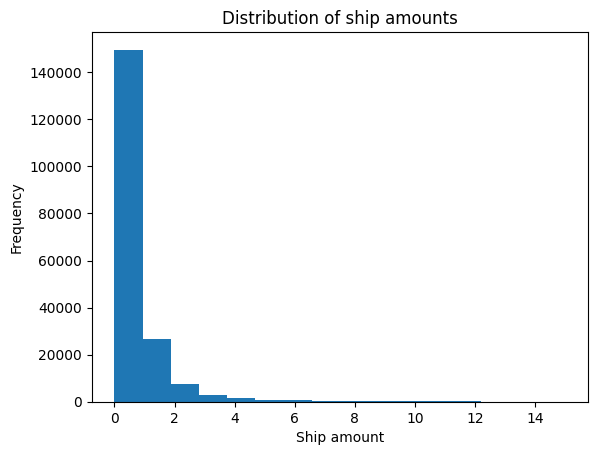

In [ ]:
df["Ships"].plot(kind='hist', bins=len(df["Ships"].value_counts())) 
plt.title('Distribution of ship amounts')
plt.xlabel('Ship amount')
plt.ylabel('Frequency')
plt.show()

### Image visualization

In [44]:
def rle_decode_the_mask(mask_series: pd.Series, shape: tuple=None):
    """
    Decode an RLE-encoded mask from a pandas series.

    Parameters:
    - mask_series (pd.Series): Pandas series containing the mask (0/"0" if empty).
    - shape (tuple, optional): Shape of the image in case of resizing.

    Returns:
    - original_shape_mask (torch.Tensor): Decoded mask with masked pixels being white.
    """
    # Extracting the mask array from the series
    mask_array = mask_series.values
        
    # Checking if the mask is empty (no ships)
    if mask_array == 0 or mask_array == '0':
        return torch.zeros(shape)  # Returning a zero tensor
    else:
        mask_array = mask_array[0] # unpacking the mask

    # Creating a background mask based on the shape
    if shape is None:
        bg_mask = torch.zeros(768 * 768, dtype=torch.uint8)
    else:
        bg_mask = torch.zeros(shape[0] * shape[1], dtype=torch.uint8)

    # Splitting the mask array to decode RLE
    mask = mask_array.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (mask[0:][::2], mask[1:][::2])] # take each first value for pixel posiiton and each second - for the pixels qty after it
    starts -= 1  # Adjusting the start values to 0-indexing
    ends = starts + lengths  # Calculating the end values based on start and length


    # Create a mask with the shape of the original image
    original_shape_mask = torch.zeros(768 * 768, dtype=torch.uint8)

    # Assign 1 to the pixels based on RLE encoding
    for lo, hi in zip(starts, ends):
        original_shape_mask[lo:hi] = 1 # mark the "masked" pixels as white

    # If the shape is provided and different from the original image's shape, resize the mask
    if shape is not None:
        # Reshaping the mask to the original image dimensions (just in case)
        original_shape_mask = original_shape_mask.view(768, 768)

        # Resizing the mask to match the provided shape
        original_shape_mask = cv2.resize(original_shape_mask.numpy(), (shape[1], shape[0]), interpolation=cv2.INTER_LINEAR)

        # Converting the resized mask back to a PyTorch tensor
        original_shape_mask = torch.from_numpy(original_shape_mask)

    return original_shape_mask.T  # Returning the decoded mask


def encode_the_image(imagePath: str, shape: tuple=None):
    """
    Encode an image into a NumPy array with optional resizing.

    Parameters:
    - imagePath (str): The path to the image file.
    - shape (tuple, optional): The desired shape of the output image (height, width).

    Returns:
    - img (numpy.ndarray): Encoded image as a NumPy array; resized; color scheme: RGB.
    """
    # Read the image from the given path
    img = cv2.imread(imagePath)
    # Convert the color space from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image if a shape is provided
    if shape is not None:
        img = cv2.resize(img, shape, interpolation=cv2.INTER_LINEAR)
        
    return img  # Return the encoded image


def plot_the_image(imagePath: str, axis, shape: tuple=None):
    """
    Plot an image on a given axis with optional resizing.

    Parameters:
    - imagePath (str): The path to the image file.
    - axis: The matplotlib axis to plot the image.
    - shape (tuple, optional): The desired shape of the output image (height, width).
    """
    # Check if the image exists
    if not os.path.exists(imagePath):
        print("The image", imagePath, "is not found")
        return
    
    # Encode the image
    img = encode_the_image(imagePath, shape)
    
    # Resize the image if a shape is provided
    if shape is not None:
        img = cv2.resize(img, shape, interpolation=cv2.INTER_LINEAR)

    # Plot the image on the given axis
    if axis is not None:
        axis.imshow(img)
        axis.axis('off')


def plot_the_mask(mask_array: pd.Series, axis=None, shape: tuple=None):
    """
    Plot a mask on a given axis with optional resizing.

    Parameters:
    - mask_array (pd.Series): Pandas series containing the mask.
    - axis: The matplotlib axis to plot the mask.
    - shape (tuple, optional): The desired shape of the output mask (height, width).

    Returns:
    - None
    """
    # Decode the mask
    mask_decoded = rle_decode_the_mask(mask_array, shape)

    # Convert mask_decoded to numpy array
    mask_decoded_np = mask_decoded.numpy()

    # Reshape the mask if shape is provided
    if shape is not None:
        mask_decoded_resized = cv2.resize(mask_decoded_np, shape[::-1], interpolation=cv2.INTER_LINEAR)

    # Plot the mask on the given axis
    if axis is not None:
        axis.imshow(mask_decoded_resized, cmap='gray')
        axis.axis('off')

### Plot different images manually to get control over the ship amount

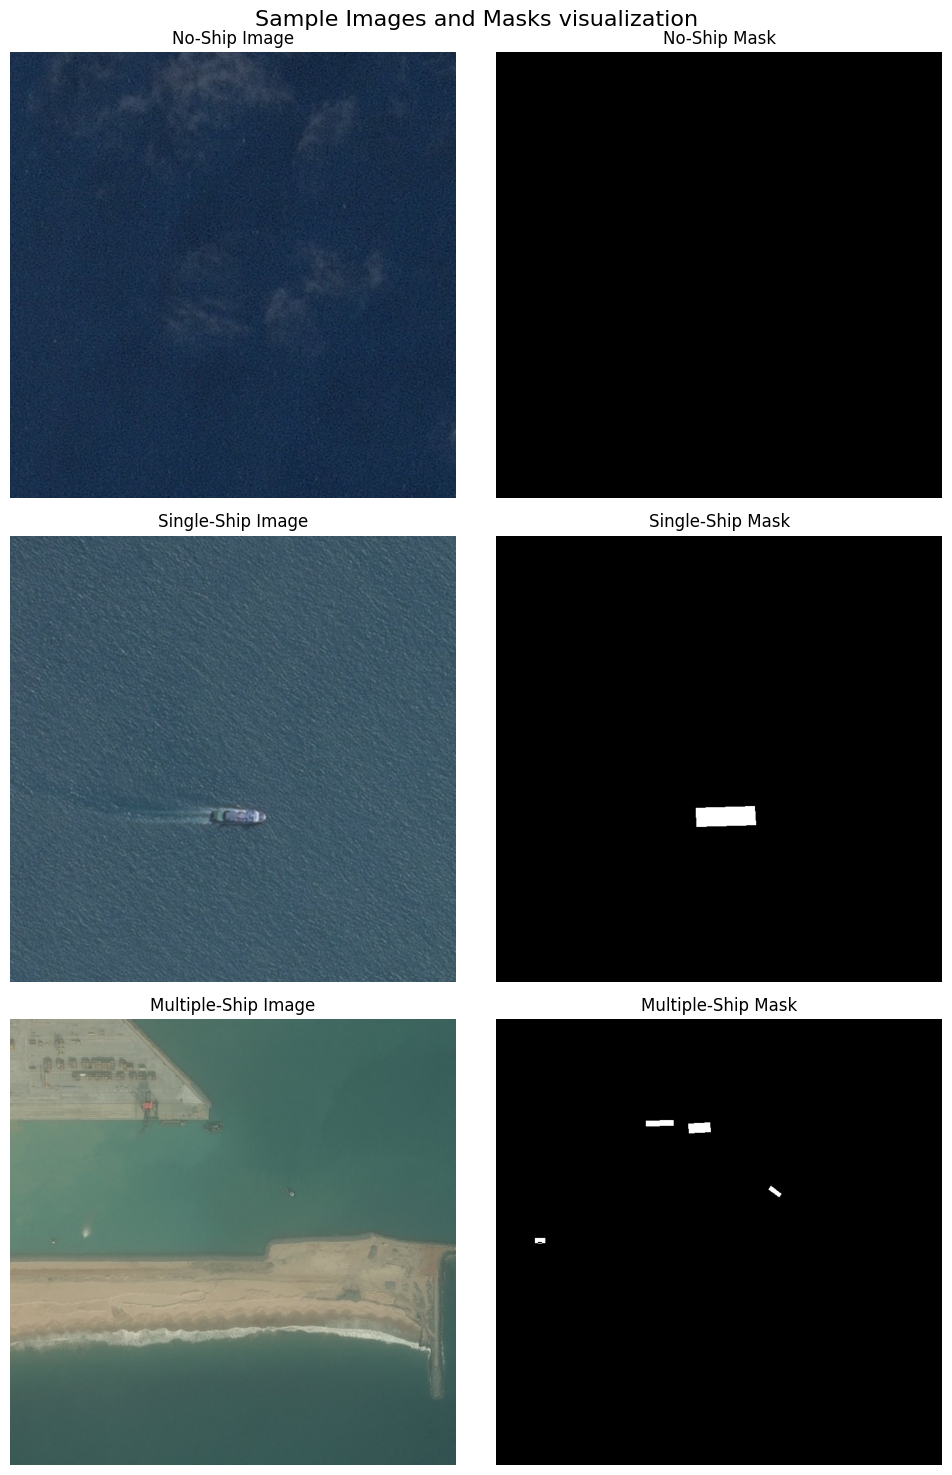

In [ ]:
# create a figure for plotting
fig = plt.figure(figsize=(10, 15))
fig.suptitle('Sample Images and Masks visualization', fontsize=16)  # Main title

# create axis (3 rows, 2 columns)
axis = fig.subplots(3,2)

# show the image and its mask for a no-ship image
axis[0,0].set_title('No-Ship Image')  # Subtitle for the first column
plot_the_image(os.path.join(TRAIN_URL, "00003e153.jpg"), axis[0,0], shape=(768,768))
axis[0,1].set_title('No-Ship Mask')  # Subtitle for the second column
plot_the_mask(df[df['ImageId']=="00003e153.jpg"]['EncodedPixels'], axis[0,1], shape=(768,768))

# show the image and its mask for a single-ships image
axis[1,0].set_title('Single-Ship Image')  # Subtitle for the first column
plot_the_image(os.path.join(TRAIN_URL, "000155de5.jpg"), axis[1,0], shape=(768,768))
axis[1,1].set_title('Single-Ship Mask')  # Subtitle for the second column
plot_the_mask(df[df['ImageId']=="000155de5.jpg"]['EncodedPixels'], axis[1,1], shape=(768,768))

# show the image and its mask for a multiple-ships image
axis[2,0].set_title('Multiple-Ship Image')  # Subtitle for the first column
plot_the_image(os.path.join(TRAIN_URL, "000194a2d.jpg"), axis[2,0], shape=(768,768))
axis[2,1].set_title('Multiple-Ship Mask')  # Subtitle for the second column
plot_the_mask(df[df['ImageId']=="000194a2d.jpg"]['EncodedPixels'], axis[2,1], shape=(768,768))

plt.tight_layout() # remove the excessive space between the images
plt.show()

### Looking for disruptancies in file sizes

In [16]:
# Adding a new column 'Size_kb' to the dataframe by calculating the size of each image in kilobytes and mapping it to the 'ImageId' column
df['Size_kb'] = df['ImageId'].map(lambda img: os.stat(os.path.join(TRAIN_URL, img)).st_size/1024)
df.head()

ImageId                                      EncodedPixels  Ships  \
0  00003e153.jpg                                                  0      0   
1  0001124c7.jpg                                                  0      0   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      5   
4  0001b1832.jpg                                                  0      0   

      Size_kb  
0  128.944336  
1   76.059570  
2  147.625977  
3   75.221680  
4   95.627930

In [ ]:
df['Size_kb'].describe()

count    191648.000000
mean        147.278237
std          54.263967
min           9.612305
25%         108.396484
50%         130.407227
75%         178.111816
max         511.942383
Name: Size_kb, dtype: float64

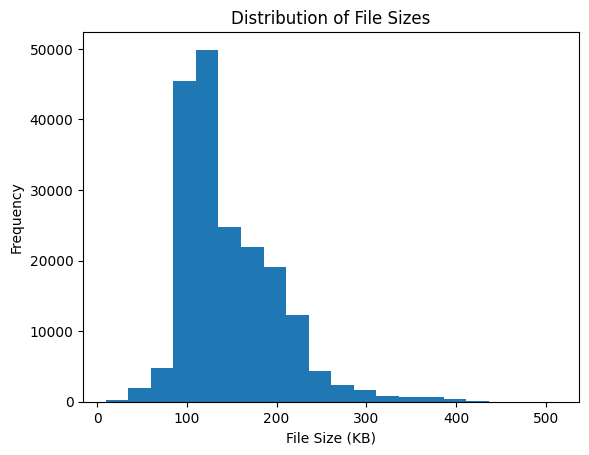

In [ ]:
df['Size_kb'].plot(kind='hist', bins=20) 
plt.title('Distribution of File Sizes')
plt.xlabel('File Size (KB)')
plt.ylabel('Frequency')
plt.show()

### Dropping low quality images + undersampling empty images

In [ ]:
def drop_low_quality_images(df_input: pd.DataFrame, kb: int):
    """
    Drop low-quality images from the dataframe based on the specified size threshold.

    Parameters:
    - df_input (pd.DataFrame): Input dataframe containing the image size.
    - kb (int): Size threshold in kilobytes. Images with size less than or equal to this threshold will be dropped.

    Returns:
    - None
    """
    # Filtering out low-quality images based on size threshold
    df_LQ = df_input[np.floor(df_input['Size_kb']) <= kb]
    
    # Dropping low-quality images from the input dataframe
    df_input.drop(df_LQ.index, inplace=True)
    
    # Printing the number of dropped images
    print("Successfully dropped", df_LQ.shape[0], "images")


def undersample_empty_images(df_in: pd.DataFrame, fraction_to_leave: float):
    """
    Undersample empty images (images with no ships) from the dataframe to achieve a specified fraction to leave.

    Parameters:
    - df_in (pd.DataFrame): Input dataframe containing image information.
    - fraction_to_leave (float): Fraction of empty images to leave after undersampling.

    Returns:
    - None
    """
    # initial df length
    original_len = len(df_in)
    # Selecting rows with no ships
    no_ships_df = df_in[df_in['Ships'] == 0]
    no_ships_len = len(no_ships_df)

    # Calculating the number of rows to keep
    rows_to_keep = int(no_ships_len * (1 - fraction_to_leave))

    # Sampling rows to drop based on the calculated number of rows to keep
    indexes_to_drop = no_ships_df.sample(rows_to_keep, random_state=SEED).index
    
    # Dropping the sampled indexes from the input dataframe
    df_in.drop(indexes_to_drop, inplace=True)
    print("Successfully undersampled", original_len - len(df_in), "images")

    

# drop low quality / invalid images
drop_low_quality_images(df, LOW_QUALITY_IMAGES_THRESHOLD)

print()

# Undersample the majority class (images without ships)
undersample_empty_images(df, NO_SHIP_IMAGES_AMOUNT_TO_LEAVE)

Successfully dropped 1478 images

Successfully undersampled 104140 images


### Custom dataset class

In [20]:
class AirbusShipDetectionDataset(Dataset):
    """
    Dataset class that represents the Airbus Ship Detection data. It is utilized be the data loader to get items for batches.

    Parameters:
    - df_in (pd.DataFrame): Input dataframe containing image information.
    - augmentations (albu.Compose): Augmentation pipeline to apply to images and masks.
    - images_dir (str): Directory containing the images.
    - shape (tuple, optional): Desired shape of the output images and masks (height, width).
    """

    def __init__(self, df_in: pd.DataFrame, augmentations: albu.Compose, images_dir: str, shape=(768, 768)) -> None:
        super().__init__()
        
        self.df = df_in
        self.shape = shape
        self.augs = augmentations
        self.images_dir = images_dir

    def __len__(self) -> int:
        """
        Returns:
        - the length of the data (rows)

        """
        return len(self.df)

    def __getitem__(self, idx: int):
        """
        Get item method to retrieve an image and its mask by index. Represents an item of the dataset.

        Parameters:
        - idx (int): Index of the image to retrieve.

        Returns:
        - image (torch.Tensor): The image as a PyTorch tensor (color_channel=3, self.shape[0], self.shape[1]).
        - mask (torch.Tensor): The mask as a PyTorch tensor (color_channel=1, self.shape[0], self.shape[1]).
        """
        # Get the row corresponding to the given index from the dataframe
        df_row = self.df.iloc[idx]
            
        # Extract the image name from the row
        image_name = df_row['ImageId']
        # Construct the full image path
        full_image_path = os.path.join(self.images_dir, str(image_name))

        # Encode the image using the provided shape
        image = encode_the_image(full_image_path, self.shape)
        # Decode the mask using the provided shape
        mask = rle_decode_the_mask(pd.Series(df_row['EncodedPixels']), self.shape)

        # Apply augmentations to the image and mask
        augmented = self.augs(image=image, mask=mask.numpy()) 

        # Rearrange dimensions and convert the augmented image to PyTorch tensor
        image = torch.from_numpy(augmented["image"]).permute(2, 0, 1)
        # Convert the augmented mask to PyTorch tensor and add a channel dimension
        mask = torch.from_numpy(augmented["mask"]).float().unsqueeze(0)

        # Return the processed image and mask
        return image, mask

### Testing custom dataset class

In [21]:
# tesing for errors
albumentations = albu.Compose([
    albu.Resize(256, 256)
])

dataset = AirbusShipDetectionDataset(df, albumentations, TRAIN_URL)

In [22]:
# observing the expected shapes are indeed correct
image, mask = dataset.__getitem__(0)

print("Image:")
print(image.shape)
print("Mask:")
print(mask.shape)

Image:
torch.Size([3, 256, 256])
Mask:
torch.Size([1, 256, 256])


### Train one epoch for PyTorch

In [23]:
def train_one_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, metric_fn, device: str = "cpu", verbose: bool = True) -> dict:  
    """
    Train the model for one epoch, accumulating weights.

    Parameters:
    - model (nn.Module): The neural network model to train.
    - loader (DataLoader): DataLoader containing the training data.
    - criterion (nn.Module): The loss function to optimize.
    - optimizer (optim.Optimizer): The optimizer algorithm to use for training.
    - metric_fn: Function to compute additional metrics (e.g., Dice coefficient).
    - device (str, optional): The device to use for training (default is "cpu").
    - verbose (bool, optional): Whether to display training progress (default is True).

    Returns:
    - logs (dict): Dictionary containing training logs (losses and metrics).
    """
    
    model.train() # Set the model to training mode

    # Initialize lists to store losses and Dices
    losses = []
    dices = []

    # Create a progress bar for training
    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:  # Iterate over image_mask pairs in the current batch of the loader
            
            # Move data to the specified device (CPU or GPU):
            x_batch = x_batch.to(device)
            y_true = y_true.to(device)

            # Clear previous gradients (we want weights to accumulate, not gradients)
            optimizer.zero_grad()

            # Forward pass to compute predictions
            y_pred = model(x_batch).sigmoid() # convert into binary prediction (0 or 1; approximately)

            # Compute the loss
            loss = criterion(y_pred, y_true)

            # Perform backward propagation to compute gradients
            loss.backward()

            # Append the current loss to the losses list
            losses.append(loss.item())

            # Compute and append Dices
            dice = metric_fn(y_pred, y_true).item()  # Compute the Dice coefficient
            dices.append(dice)

            # Update the progress bar with the current loss
            progress.set_postfix_str(f"loss {losses[-1]:.4f}; dice {dices[-1]:.4f}")

            # Update the model's weights based on the optimizer's strategy
            optimizer.step()

            # Update the progress bar
            progress.update(1)

    # Create a dictionary to store training logs
    logs = {
        "losses": np.array(losses),  # Array of losses for each batch
        "dices": np.array(dices)       # Array of Dices for each batch
    }
    return logs

### Evaluate for PyTorch

In [24]:
@torch.inference_mode() # do not accumulate weights, do not evaluate gradients; the data acts as unseen for performance assesing only
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module, metric_fn, device: str = "cpu", verbose: bool = True,) -> dict:
    """
    Evaluate the model on the validation set. No weights accumulation, only inference. The data doesn't take part in training.

    Parameters:
    - model (nn.Module): The neural network model to evaluate.
    - loader (DataLoader): DataLoader containing the validation data.
    - criterion (nn.Module): The loss function to use for evaluation.
    - metric_fn: Function to compute additional metrics (Dice).
    - device (str, optional): The device to use for evaluation (default is "cpu").
    - verbose (bool, optional): Whether to display evaluation progress (default is True).

    Returns:
    - logs (dict): Dictionary containing evaluation logs (losses and metrics).
    """
    
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store losses and dices
    losses = []
    dices = []

    with torch.no_grad(): # no gradient calculations
        # Iterate over image_mask pairs in the current batch of the loader
        for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
            # Move data to the specified device (CPU or GPU)
            x_batch = x_batch.to(device)
            y_true = y_true.to(device)

            # Forward pass to compute predictions
            y_pred = model(x_batch).sigmoid()

            # Compute the loss
            loss = criterion(y_pred, y_true)

            # Append the current loss to the losses list
            losses.append(loss.item())

            # Compute and append dices
            dices.append(metric_fn(y_pred, y_true).item())  # Append the Dice value

    # Create a dictionary to store evaluation logs
    logs = {
        "losses": np.array(losses), # Array of losses for each batch
        "dices": np.array(dices)  # Array of dices for each batch
    }
    return logs

### Splitting data

In [25]:
# Splitting the dataframe into training and validation sets, stratifying on "Ships" column
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['Ships'])

# Resetting the index of the training and validation dataframes (needed for a convenient sampling; specifically after the stratification)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

# Displaying information about the training and validation data
print("Train data:")
print(train_df.shape)
print("Validation data:")
print(validation_df.shape)
print()

# Displaying the first few rows of the training dataframe
display(train_df.head())

Train data:
(68824, 4)
Validation data:
(17206, 4)



ImageId                                      EncodedPixels  Ships  \
0  0ab492772.jpg                                                  0      0   
1  ac3f40d1b.jpg  199365 4 200133 12 200901 19 201668 24 202436 ...      1   
2  6c86ceb30.jpg  124819 2 125587 4 126354 7 127122 9 127889 12 ...      1   
3  6d08059ed.jpg  458780 2 459548 4 460315 8 461083 10 461850 13...      1   
4  e63edb99d.jpg                                                  0      0   

      Size_kb  
0  121.398438  
1  124.622070  
2  107.115234  
3  131.394531  
4  145.516602

### Creating a custom sampler for DataLoader

In [26]:
class ShipStratifiedSampler(torch.utils.data.Sampler):
    """
    A custom sampler class for stratifies sampling of ship images. It stratified images in terms of ships quantity.
    It is utilized by DataLoader and acts as a custom sampling method. If we didn't use the stratification, it could be omitted.

    Parameters:
    - data_source (pd.DataFrame): The dataset to sample from.
    - batch_size (int): The batch size.
    - zero_ships_ratio_per_batch (float): The desired ratio of zero ships images in each batch.
    """

    def __init__(self, data_source: pd.DataFrame, batch_size: int, zero_ships_ratio_per_batch: float):
        self.data_source = data_source
        self.batch_size = batch_size
        self.zero_ships_ratio_per_batch = zero_ships_ratio_per_batch

        # Extract indices for zero and non-zero ships images; cast to list
        self.zero_ships_indices = data_source[data_source['Ships'] == 0].index.tolist()
        self.nonzero_ships_indices = data_source[data_source['Ships'] > 0].index.tolist()
        
        # Calculate the number of batches the way each image with >= 1 ship would occur during training (at least by quantity)
        self.num_batches = int(len(self.nonzero_ships_indices) // (batch_size * (1 - self.zero_ships_ratio_per_batch)))

    def __iter__(self):
        """
        Iterator function to yield batch indices.
        """

        random.seed(SEED) # ensure reproducibility once more
        random.shuffle(self.zero_ships_indices) # shuffle the indices
        random.shuffle(self.nonzero_ships_indices) # shuffle the indices
        
        for _ in range(self.num_batches):
            # Sample indices for zero ships images
            num_zero_ships = int(self.batch_size * self.zero_ships_ratio_per_batch) # how many > 0 ship images per batch
            sampled_zero_ships = random.sample(self.zero_ships_indices, num_zero_ships) # reproducable sample

            # Sample indices for non-zero ships images
            num_nonzero_ships = self.batch_size - num_zero_ships # how many  no-ship images per batch
            sampled_nonzero_ships = random.sample(self.nonzero_ships_indices, num_nonzero_ships) # reproducable sample

            # Combine sampled indices for both types of batches
            sampled_indices = sampled_zero_ships + sampled_nonzero_ships

            # Yield individual indices for the batch
            for idx in sampled_indices:
                yield idx

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return self.num_batches * self.batch_size

### Testing the custom sampler

In [27]:
# testing for mistakes and stratification correctness

# Initialize the sampler
test_sampler = ShipStratifiedSampler(data_source=train_df, batch_size=BATCH_SIZE, zero_ships_ratio_per_batch=0.25)

# Initialize lists to store batch indices and corresponding number of ships
batch_indices = []
batch_ships = []

# Iterate over the sampler to collect batch indices and ship counts
for idx in test_sampler:
    # Break if the desired batch size is reached
    if len(batch_ships) == BATCH_SIZE:
        break
    else:
        # Append the index and ship count for the current sample
        batch_indices.append(idx)
        batch_ships.append(train_df['Ships'].loc[idx])

# Print the collected batch indices and ship counts
print(batch_indices) # indices
print(batch_ships) # quantities

[1651, 3684, 54509, 36360, 67346, 24516, 13156, 53211, 37334]
[0, 0, 1, 4, 1, 2, 2, 1, 1]


In [28]:
workers = os.cpu_count() // 2 # limiting CPU cores as I may do other operations on the machine and don't want training processes to terminate

# Initialize the training data loader
train_data_loader = DataLoader(
    AirbusShipDetectionDataset(df_in=train_df, augmentations=albumentations, images_dir=TRAIN_URL), # gets us the item of the data (image, mask)
    batch_size=BATCH_SIZE, # batch size
    sampler=ShipStratifiedSampler(data_source=train_df, batch_size=BATCH_SIZE, zero_ships_ratio_per_batch=0.25), # utilizies AirbusShipDetectionDataset's __getitem__ and samples a batch
    num_workers=workers, # CPU cores used
    shuffle=False, # is not compatible with stratification (will actually cancel it out)
    drop_last=True, # drop rows that didn't fit the batch size due to the division
    persistent_workers=True,  # Whether to keep workers alive between iterations (helps with DataLoader performance)
    pin_memory=False  # Whether to use pinned memory for faster data transfer to GPU (not needed if data is already in GPU memory)

)

# Initialize the validation data loader
validation_data_loader = DataLoader(
    AirbusShipDetectionDataset(df_in=validation_df, augmentations=albumentations, images_dir=TRAIN_URL),
    batch_size=BATCH_SIZE,
    sampler=ShipStratifiedSampler(data_source=validation_df, batch_size=BATCH_SIZE, zero_ships_ratio_per_batch=0.25),
    num_workers=workers,
    shuffle=False,
    drop_last=False,
    pin_memory=False
)

In [29]:
gc.collect() # Manually trigger garbage collection to free up memory within the Python runtime environment (RAM).
# returns the number of objects cleaned

16

In [30]:
# check the data loader performance and batch shapes
for batch_images, batch_masks in train_data_loader:
    print("Batch images shape:", batch_images.shape) # (batch_size, color_channel=3, width, height)
    print("Batch masks shape:", batch_masks.shape) # (batch_size, color_channel=1, width, height)
    break

Batch images shape: torch.Size([9, 3, 256, 256])
Batch masks shape: torch.Size([9, 1, 256, 256])


### Defining a custom class for a convenient model's operating

In [31]:
class TrainAndTestModel:
    def __init__(self, model: nn.Module, device: str, dataset_train: pd.DataFrame, dataset_val: pd.DataFrame, train_augs:albu.Compose = None, 
                 valid_augs:albu.Compose = None, images_dir: str = TRAIN_URL, input_size: tuple = (768, 768)):
        """
        Initializes a class for training and testing a deep learning model.

        Args:
            model (nn.Module): The neural network model to train and test.
            device (str): Device to run training and evaluation (e.g., "cpu" or "cuda").
            dataset_train (pd.DataFrame): Training dataset.
            dataset_val (pd.DataFrame): Validation dataset.
            train_augs (albu.Compose): Data augmentations for training. If None, resizing and normalization applied.
            valid_augs (albu.Compose): Data augmentations for validation. If None, resizing and normalization applied.
            input_size (tuple): Input image shape.
        """

        self.dataset_train = dataset_train
        self.dataset_val = dataset_val

        self.model = model
        self.device = device

        # declare arrays for storing losses and accuracies for training
        self.train_losses = []
        self.train_dices = []

        # declare arrays for storing losses and accuracies for evaluation
        self.valid_losses = []
        self.valid_dices = []

        self.batch = BATCH_SIZE
        self.workers = os.cpu_count() // 2

        self.input_size = input_size
        self.images_dir = images_dir
        self.zero_ships_ratio_per_batch = 0.25

        if train_augs is None:
            # Define a set of data augmentations for training
            train_augs = albu.Compose([
                albu.Resize(*self.input_size),
                albu.Normalize(),
            ])

        if valid_augs is None:
          # Define a set of data augmentations for validation
          valid_augs = albu.Compose([
              albu.Resize(*self.input_size),
              albu.Normalize(),
        ])


        self.train_augs = train_augs
        self.valid_augs = valid_augs


    def get_accuracies_n_losses(self):
        """
        Get the training and validation losses along with training and validation accuracies.

        Returns:
          tuple: A tuple containing four lists:
              - Training losses.
              - Validation losses.
              - Training accuracies.
              - Validation accuracies.
        """
        return self.train_losses, self.valid_losses, self.train_dices, self.valid_dices
    
    def set_zero_ships_ratio_per_batch(self, val):
        """
        sets the ratio of no-ship images for a batch during sampling
        """
        self.zero_ships_ratio_per_batch = val

    def train(self, n_batch: int, n_epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module, metric_fn, scheduler=None): # train the model
        """
        Trains the neural network model until the specified amount of epoch.

        Args:
          n_batch (int): Batch size for training.
          n_epochs (int): Number of training epochs.
          optimizer (torch.optim.Optimizer): Optimizer for model parameters.
          loss_fn (nn.Module): Loss function to calculate training loss.
          metric_fn: Metric to consider (Dice).
          sceduler (optional): learning rate scheduler.

        Returns:
          tuple: A tuple containing four lists:
              - Training losses.
              - Validation losses.
              - Training accuracies.
              - Validation accuracies.
        """
        # Set batch size and number of workers
        self.batch = n_batch

        # defining the training loader (described in detailes above)
        _train_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_train, augmentations=self.train_augs, images_dir=self.images_dir),
            batch_size=self.batch,
            sampler=ShipStratifiedSampler(data_source=self.dataset_train, batch_size=self.batch, zero_ships_ratio_per_batch = self.zero_ships_ratio_per_batch),
            num_workers=self.workers,
            shuffle=False,
            drop_last=True,
            persistent_workers=True,
            pin_memory=False
        )

        # defining the validation loader (described in detailes above)
        _valid_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_val, augmentations=self.valid_augs, images_dir=TRAIN_URL),
            batch_size=BATCH_SIZE,
            sampler=ShipStratifiedSampler(data_source=self.dataset_val, batch_size=self.batch, zero_ships_ratio_per_batch = self.zero_ships_ratio_per_batch),
            num_workers=self.workers,
            shuffle=False,
            drop_last=False,
            pin_memory=False
        )

        # for each epoch
        for ep in range(n_epochs):
            # print the progress
            print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

            # Train the model for one epoch and collect train Dice scores
            _train_logs = train_one_epoch(model=self.model, loader=_train_loader, criterion=loss_fn, optimizer=optimizer, metric_fn=metric_fn, device=self.device, verbose=True)
            _train_dice = np.mean(_train_logs["dices"]) # shown dice per epoch is the mean of all samples' dices (train)
            self.train_dices.append(_train_dice) # append to all other epochs' dices (train)
            _train_loss = np.mean(_train_logs["losses"]) # shown loss per epoch is the mean of all samples' losses (train)
            self.train_losses.append(_train_loss) # append to all other epochs' losses (train)

            print("   Training Dice:", self.train_dices[-1]) # show the last dice (train)
            print("   Training Loss:", self.train_losses[-1]) # show the last loss (train)

            # Evaluate the model on the validation dataset and collect validation Dice scores
            _valid_logs = evaluate(model=self.model, loader=_valid_loader, criterion=loss_fn, metric_fn=metric_fn, device=self.device, verbose=True)
            _valid_dice = np.mean(_valid_logs["dices"]) # shown dice per epoch is the mean of all samples' dices (evaluation)
            self.valid_dices.append(_valid_dice) # append to all other epochs' dices (evaluation)
            _valid_loss = np.mean(_valid_logs["losses"]) # shown loss per epoch is the mean of all samples' losses (evaluation)
            self.valid_losses.append(_valid_loss) # append to all other epochs' losses (evaluation)

            print("   Validation Dice:", self.valid_dices[-1]) # show the last dice (evaluation)
            print("   Validation Loss:", self.valid_losses[-1]) # show the last loss (evaluation)

        # Update the learning rate using the scheduler based on the validation metric (Dice)
        if scheduler != None:
            scheduler.step(_valid_dice)

        return self.get_accuracies_n_losses()
    
    def continue_training(self, current_epoch: int, n_batch: int, n_epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module, metric_fn, scheduler=None):
        """
        Continues training from the specified epoch. It is possible due to the tracking of all model's data within this class.

        Args:
          current_epoch (int): the last finished epoch (number).
          n_batch (int): Batch size for training.
          n_epochs (int): Number of training epochs to do.
          optimizer (torch.optim.Optimizer): Optimizer for model parameters.
          loss_fn (nn.Module): Loss function to calculate training loss.
          metric_fn: Metric to consider (Dice).
          sceduler (optional): learning rate scheduler.

        Returns:
          tuple: A tuple containing four lists:
              - Training losses.
              - Validation losses.
              - Training accuracies.
              - Validation accuracies.
        """
        self.batch = n_batch

        # defining the training loader (described in detailes above)
        _train_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_train, augmentations=self.train_augs, images_dir=self.images_dir),
            batch_size=self.batch,
            sampler=ShipStratifiedSampler(data_source=self.dataset_train, batch_size=self.batch, zero_ships_ratio_per_batch = self.zero_ships_ratio_per_batch),
            num_workers=self.workers,
            shuffle=False,
            drop_last=True,
            persistent_workers=True,
            pin_memory=False
        )

        # defining the validation loader (described in detailes above)
        _valid_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_val, augmentations=self.valid_augs, images_dir=TRAIN_URL),
            batch_size=BATCH_SIZE,
            sampler=ShipStratifiedSampler(data_source=self.dataset_val, batch_size=self.batch, zero_ships_ratio_per_batch = self.zero_ships_ratio_per_batch),
            num_workers=self.workers,
            shuffle=False,
            drop_last=False,
            pin_memory=False
        )

        # Continue training for additional epochs
        for ep in range(current_epoch, current_epoch + n_epochs):
            # display the progress starting with the previous epoch
            print(f"\nEpoch {ep + 1:2d}/{current_epoch + n_epochs:2d}")

            # Train the model for one epoch and collect train Dice scores
            _train_logs = train_one_epoch(model=self.model, loader=_train_loader, criterion=loss_fn, optimizer=optimizer, metric_fn = metric_fn, device=self.device, verbose=True)
            _train_dice = np.mean(_train_logs["dices"]) # shown dice per epoch is the mean of all samples' dices (train)
            self.train_dices.append(_train_dice) # append to all other epochs' dices (train)
            _train_loss = np.mean(_train_logs["losses"]) # shown loss per epoch is the mean of all samples' losses (train)
            self.train_losses.append(_train_loss) # append to all other epochs' losses (evaluation)

            print("   Training Dice:", self.train_dices[-1]) # show the last dice (train)
            print("   Training Loss:", self.train_losses[-1]) # show the last loss (train)

            # Evaluate the model on the validation dataset and collect validation IoU scores
            _valid_logs = evaluate(model=self.model, loader=_valid_loader, criterion=loss_fn, metric_fn=metric_fn, device=self.device, verbose=True)
            _valid_dice = np.mean(_valid_logs["dices"]) # shown dice per epoch is the mean of all samples' dices (evaluation)
            self.valid_dices.append(_valid_dice) # append to all other epochs' dices (evaluation)
            _valid_loss = np.mean(_valid_logs["losses"]) # shown loss per epoch is the mean of all samples' losses (evaluation)
            self.valid_losses.append(_valid_loss) # append to all other epochs' losses (evaluation)

            print("   Validation Dice:", self.valid_dices[-1]) # show the last dice (evaluation)
            print("   Validation Loss:", self.valid_losses[-1]) # show the last loss (evaluation)

        # Update the learning rate using the scheduler based on the validation metric (Dice)
        if scheduler != None:
            scheduler.step(_valid_dice)

        return self.get_accuracies_n_losses()

    def save_model(self, save_path: str):
        """
        Saves the trained model's state dictionary to a file, adding no additional keys.

        Args:
          save_path (str): Path where the model will be saved.

        Returns:
        None
        """

        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")


    def plot_loss_acc_per_ep(self):
        """
        Plot the training and validation loss, as well as accuracy (Dice coefficient) per epoch.
        """
        fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

        # Plot loss
        axes[0].plot(np.arange(len(self.train_losses)), self.train_losses, ".-")
        axes[0].plot(np.arange(len(self.valid_losses)), self.valid_losses, ".-")
        axes[0].legend(["train", "validation"])
        axes[0].set_title("Loss")
        axes[0].grid()

        # Plot accuracy
        axes[1].plot(np.arange(len(self.train_dices)), self.train_dices, ".-")
        axes[1].plot(np.arange(len(self.valid_dices)), self.valid_dices, ".-")
        axes[1].legend(["train", "validation"])
        axes[1].set_title("Accuracy (Dice)")
        axes[1].grid()

        # Show the figure or save it as needed
        plt.show()
        plt.close()


In [3]:
# Check if CUDA (GPU) is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Going to use '{device}' device!")

Going to use 'cpu' device!


In [4]:
gc.collect() # collecting garbage again

16

### Defining dice score as a metric

In [34]:
def dice_score(y_true, y_pred, smooth=1):
    """
    Compute the Dice coefficient between two binary tensors.

    Parameters:
    - y_true: Ground truth binary tensor.
    - y_pred: Predicted binary tensor.
    - smooth (float): Smoothing factor to prevent division by zero (default is 1).

    Returns:
    - dice (torch.Tensor): Dice coefficient.
    """
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

## 5. Training

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2759/2759 [06:34<00:00,  7.00it/s, loss 0.9873; dice 0.3344]
   Training Dice: 0.19692447998494467
   Training Loss: 0.9893582498910592
evaluation: 100%|█████████████████████████████████████████████████| 689/689 [01:28<00:00,  7.75it/s]
   Validation Dice: 0.30851608621840554
   Validation Loss: 0.9890191380275178

Epoch  2/ 5
training: 100%|███████████████████████| 2759/2759 [06:24<00:00,  7.18it/s, loss 0.9857; dice 0.5084]
   Training Dice: 0.35157959192623994
   Training Loss: 0.9890709192954185
evaluation: 100%|█████████████████████████████████████████████████| 689/689 [01:23<00:00,  8.27it/s]
   Validation Dice: 0.4059456431662396
   Validation Loss: 0.9889619335726834

Epoch  3/ 5
training: 100%|███████████████████████| 2759/2759 [06:17<00:00,  7.31it/s, loss 0.9871; dice 0.4308]
   Training Dice: 0.4025686718077926
   Training Loss: 0.9889057067132765
evaluation: 100%|████████████████

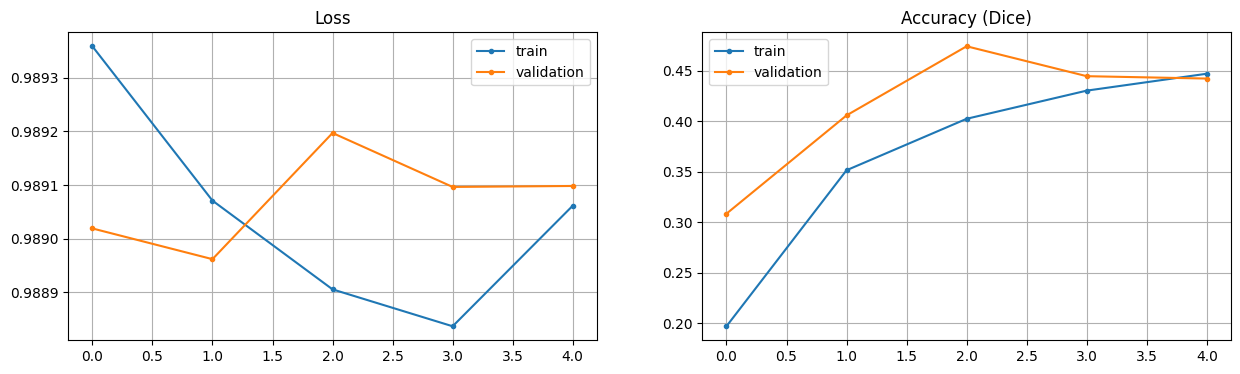

In [128]:
torch.manual_seed(SEED) # manual seed needed each time we want to ensure a complete reproducability

# Initialize the UNet model with an imagenet backbone weights; semantic
unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet") 
# move the model to the predetermined device
unet_model = unet_model.to(device)

# Print the number of trainable parameters in the model
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# Define tunable parameters
BATCH_SIZE = 16 # batch size
LR = 1e-4 # learning rate
N_EPOCHS = 5 # number epochs to train for
INPUT_SIZE = (256, 256) # image size to utilize during training

# Define data augmentation pipelines for training and validation
TRAIN_AUGS = albu.Compose([ # (training)
    albu.Resize(*INPUT_SIZE), 
    albu.Normalize(),
])

VALID_AUGS = albu.Compose([ # (evaluation)
    albu.Resize(*INPUT_SIZE),
    albu.Normalize(),
])

SCHEDULER = None # learning rate scheduler
ZERO_SHIPS_RATIO_PER_BATCH = 0.25 # ratio of no-ship images per batch

# Set up the optimizer, loss function, and evaluation metric
optimizer = optim.Adam(unet_model.parameters(), lr=LR) # the most popular and advanced optimizer
loss_fn = smp.losses.DiceLoss(mode="binary").to(device) # minimizing the dice loss to maximize the dice coefficient
metric_fn = dice_score # dice coefficient as a metric (suggested by the task)


# Initialize the training and testing model
unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

# Set the ratio of zero ships images per batch
unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

# Train the model
unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

# Plot the loss and accuracy per epoch
unet_model_train.plot_loss_acc_per_ep()

# NOTE: further code won't be commented due to the excessive repeatability. Only new added features will be outlined.

### The accuracy of training data keeps growing, while validation has started lowering. Possible overfit. We might need to lower the LR and try to look at more epochs, but that would probably take a while (1 epoch = 6 min), so with the reproducability being on, let us examine how the amount of images with no ships per batch impacts the model's performance **first**.

#### Summary: overfit; exploring the ZERO_SHIPS_RATIO_PER_BATCH parameter's impact. ZERO_SHIPS_RATIO_PER_BATCH = 0.25 -> 0.15

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2435/2435 [05:31<00:00,  7.34it/s, loss 0.9868; dice 0.3215]
   Training Dice: 0.20532730599517265
   Training Loss: 0.9876995345405485
evaluation: 100%|█████████████████████████████████████████████████| 608/608 [01:07<00:00,  8.95it/s]
   Validation Dice: 0.3061324915186943
   Validation Loss: 0.9871138389173307

Epoch  2/ 5
training: 100%|███████████████████████| 2435/2435 [05:30<00:00,  7.38it/s, loss 0.9906; dice 0.3857]
   Training Dice: 0.36232712409426543
   Training Loss: 0.9871969728009656
evaluation: 100%|█████████████████████████████████████████████████| 608/608 [01:08<00:00,  8.91it/s]
   Validation Dice: 0.4375246685047291
   Validation Loss: 0.9872094799617404

Epoch  3/ 5
training: 100%|███████████████████████| 2435/2435 [05:30<00:00,  7.37it/s, loss 0.9891; dice 0.4793]
   Training Dice: 0.429380189555504
   Training Loss: 0.9871584420576233
evaluation: 100%|██████████████████

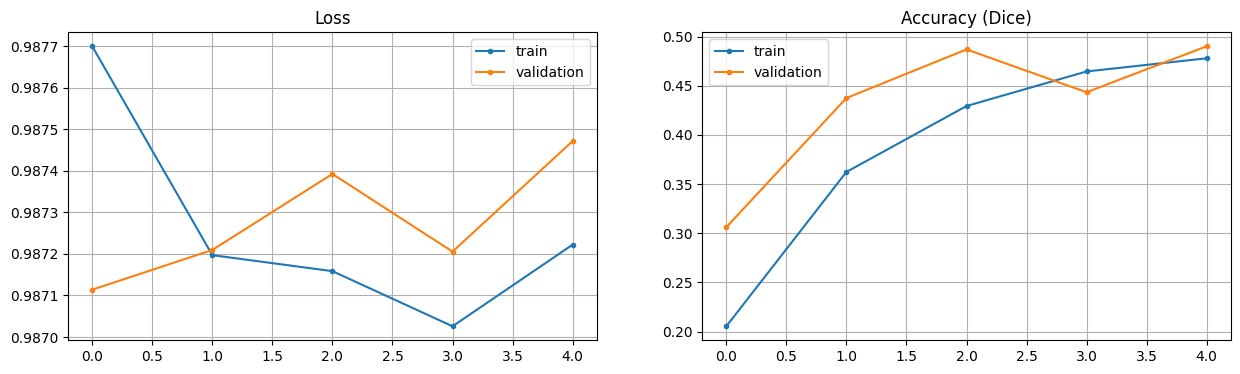

In [131]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.15 # lowered from 0.25

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.DiceLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)
    
unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### As the results are better (0.4744 -> 0.4869), we can presume that:
1. Undersampling the majority class (images without ships) was a good idea.
2. Balancing the empty ships amount per batch **down** <u>AND</u> increasing of the score may testify about the model's ability to learn from these images easier (i.e. it is far easier to detect the empty images even without their presence in that quantity), that's why having a better diversity of non-empty images (which are hard to predict) increases the score.
#### Let us see if the further lowering helps. We ought to find the right balance.

#### Summary: decreasing empty images inccreases the score; finding the perfect ratio; ZERO_SHIPS_RATIO_PER_BATCH = 0.15 -> 0.1

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2299/2299 [05:13<00:00,  7.34it/s, loss 0.9849; dice 0.3735]
   Training Dice: 0.20654620442591307
   Training Loss: 0.9868286964996009
evaluation: 100%|█████████████████████████████████████████████████| 574/574 [01:05<00:00,  8.79it/s]
   Validation Dice: 0.3818337779349359
   Validation Loss: 0.9862996807081774

Epoch  2/ 5
training: 100%|███████████████████████| 2299/2299 [05:15<00:00,  7.29it/s, loss 0.9897; dice 0.3777]
   Training Dice: 0.3885003341740243
   Training Loss: 0.9863041365805166
evaluation: 100%|█████████████████████████████████████████████████| 574/574 [01:05<00:00,  8.78it/s]
   Validation Dice: 0.46846771315518987
   Validation Loss: 0.9863196238615787

Epoch  3/ 5
training: 100%|███████████████████████| 2299/2299 [05:11<00:00,  7.37it/s, loss 0.9846; dice 0.4407]
   Training Dice: 0.44160386540154467
   Training Loss: 0.986242086563799
evaluation: 100%|█████████████████

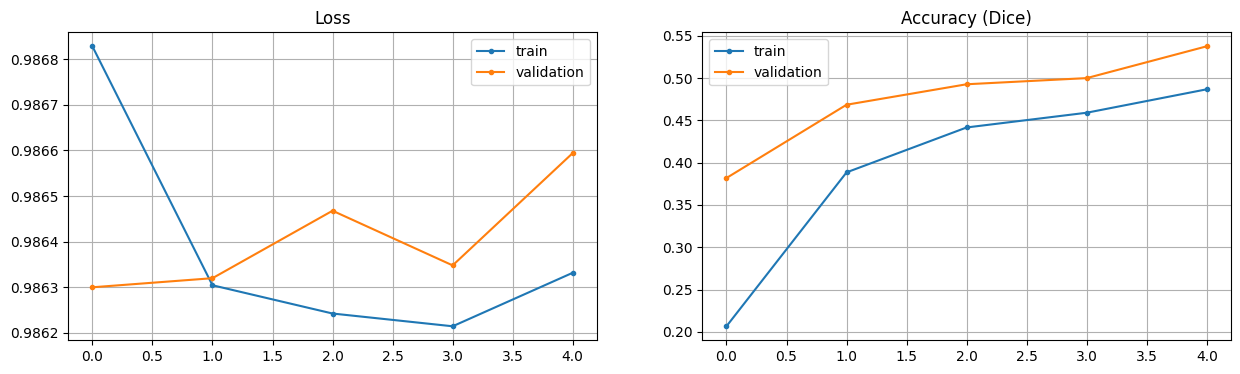

In [133]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.1 # lowered from 0.15

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.DiceLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### Better again (0.4869 -> 0.5375). It can be concluded the images without ships don't help the model in classifying pixels at all.

#### Summary: empty images don't help the model learn; ZERO_SHIPS_RATIO_PER_BATCH = 0.1 -> 0

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2069/2069 [04:42<00:00,  7.32it/s, loss 0.9833; dice 0.3870]
   Training Dice: 0.1952092515029204
   Training Loss: 0.9859959986429966
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:57<00:00,  9.04it/s]
   Validation Dice: 0.3515932720219374
   Validation Loss: 0.9853771214789533

Epoch  2/ 5
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.39it/s, loss 0.9888; dice 0.4071]
   Training Dice: 0.38096087948820223
   Training Loss: 0.9854238693295844
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:57<00:00,  9.06it/s]
   Validation Dice: 0.46865267910394726
   Validation Loss: 0.9853956038762799

Epoch  3/ 5
training: 100%|███████████████████████| 2069/2069 [04:39<00:00,  7.40it/s, loss 0.9838; dice 0.6317]
   Training Dice: 0.4434918171400722
   Training Loss: 0.9853238545793909
evaluation: 100%|█████████████████

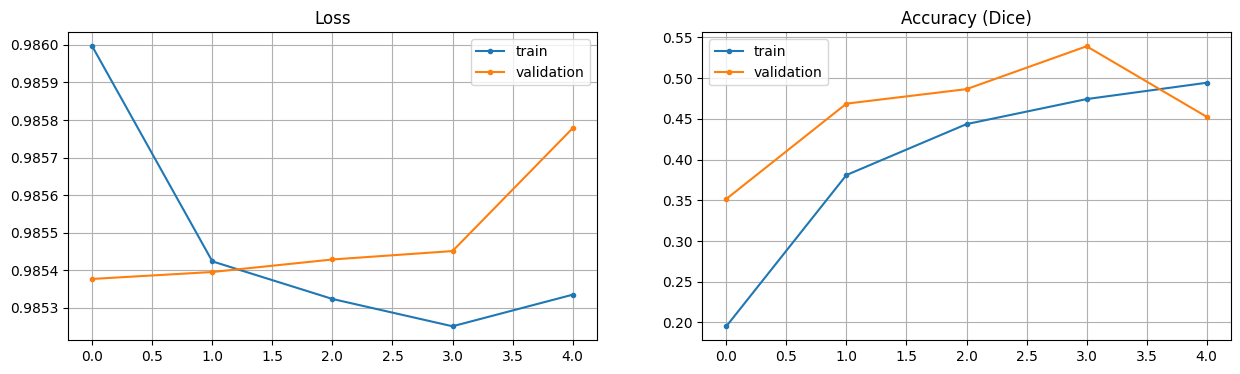

In [134]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0 # lowered from 0.1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.DiceLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### The hypothesis confirmed (0.5375 -> 0.5391). Having understood the nature of the data better, it is high time we researched the problem of the high loss. It signifies our loss function may not be suitable to the current combination of the parameteres, data and model. I was insisting on this loss until now due to the fact of maximizing the dice. It is clear that minimizing the dice loss is a perfect case for maximizing the dice metric. But it hasn't turned out well.


#### Summary: Handle high loss by trying these instead:
- loss_fn = smp.losses.FocalLoss(mode="binary").to(device) - Cross Entropy based; designed to address class imbalance and focus on hard examples during training
- loss_fn = smp.losses.LovaszLoss(mode="binary").to(device) - suits binary problem; designed to optimize for the intersection over union (IoU) metric
- loss_fn = nn.BCEWithLogitsLoss().to(device) - (Binary Cross Entropy with Logits Loss); Cross Entropy based; suits binary problem; designed for binary classification tasks

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.37it/s, loss 0.1751; dice 0.3180]
   Training Dice: 0.10271435470507989
   Training Loss: 0.1942292659855396
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:58<00:00,  8.89it/s]
   Validation Dice: 0.2823519803641267
   Validation Loss: 0.17514375261458023

Epoch  2/ 5
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.36it/s, loss 0.1734; dice 0.5513]
   Training Dice: 0.4579181224935985
   Training Loss: 0.17397251881482578
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:57<00:00,  8.97it/s]
   Validation Dice: 0.5757273401005817
   Validation Loss: 0.17331334311565533

Epoch  3/ 5
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.37it/s, loss 0.1728; dice 0.8364]
   Training Dice: 0.6536395662703222
   Training Loss: 0.1731103138900022
evaluation: 100%|███████████████

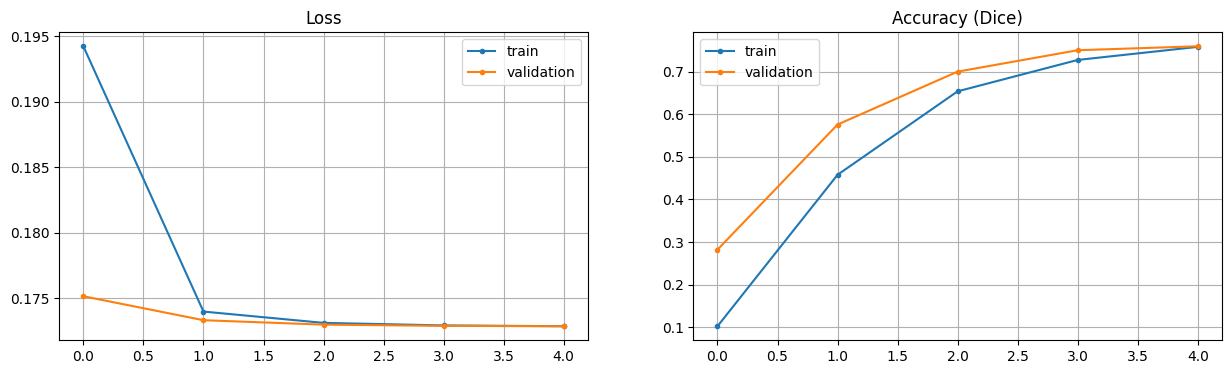

In [135]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device) # changed from the DiceLoss
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### The drastic decrease in loss aligns with a significant increase in accuracy; no overfit. The mode has improved (0.5391 -> 0.7592). This is a perfect option.

#### Summary: significantly improved; considering the FocalLoss as an option while still researching other losses. Adding LovaszLoss.

In [136]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.LovaszLoss(mode="binary").to(device) # changed from the FocalLoss
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.36it/s, loss 1.0057; dice 0.0055]
   Training Dice: 0.007259239668950237
   Training Loss: 1.0962076487317645
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:58<00:00,  8.80it/s]
   Validation Dice: 0.004958576980547716
   Validation Loss: 1.005697305935725

Epoch  2/ 5
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.35it/s, loss 1.0010; dice 0.0016]
   Training Dice: 0.0029950408238436847
   Training Loss: 1.002577013298761
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:58<00:00,  8.86it/s]
   Validation Dice: 0.0016376673713654308
   Validation Loss: 1.0009710844065742

Epoch  3/ 5
training:   3%|▊                        | 63/2069 [00:08<04:45,  7.03it/s, loss 1.0009; dice 0.0016]


KeyboardInterrupt: 

### The progress was terminated by a keyboard interrupt because it's clear this function won't make it for us. Going on with the research...


#### Summary: worse; the LovaszLoss is out. Trying BCEWithLogitsLoss.

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.37it/s, loss 0.6949; dice 0.4564]
   Training Dice: 0.16916374326222197
   Training Loss: 0.7231872769701936
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:57<00:00,  8.95it/s]
   Validation Dice: 0.42444450115673316
   Validation Loss: 0.6952032976039835

Epoch  2/ 5
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.36it/s, loss 0.6928; dice 0.7143]
   Training Dice: 0.5646594878828082
   Training Loss: 0.6935140118615071
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:57<00:00,  8.95it/s]
   Validation Dice: 0.6903416909263028
   Validation Loss: 0.6925344690824615

Epoch  3/ 5
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.38it/s, loss 0.6917; dice 0.8532]
   Training Dice: 0.730968876067079
   Training Loss: 0.692281602718451
evaluation: 100%|███████████████████

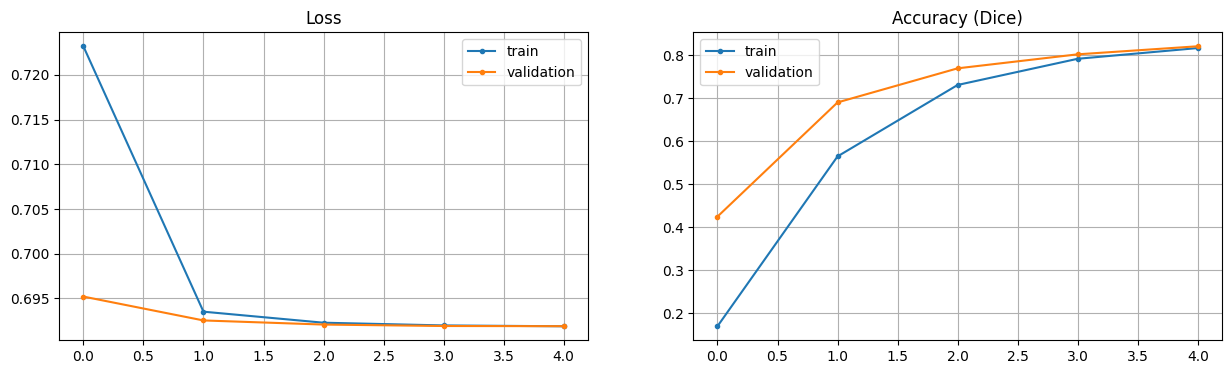

In [138]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss().to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### The focal loss has had the best performance so far. According to the FocalLoss's plot it doesn't seem to be over- or underfit, thus I thing the learning rate is in tact. I'd rather say we needed a scheduler to continue the training as segmentation problems are often tend to require a long low LR tuning. Therefore I'd rather we added a scheduler. Possibly ReduceLROnPlateau. But before this time consuming measure, we'll proceed to batch size and augmentations.


#### Summary: sticking to the FolcaLoss; getting ready to apply ReduceLROnPlateau soon; observing how the batch size will influence the score. BATCH_SIZE 16 -> 9

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 3679/3679 [05:24<00:00, 11.33it/s, loss 0.1735; dice 0.4171]
   Training Dice: 0.20870089656194926
   Training Loss: 0.18569276968108858
evaluation: 100%|█████████████████████████████████████████████████| 919/919 [01:10<00:00, 13.10it/s]
   Validation Dice: 0.49366651010274953
   Validation Loss: 0.17383309292391153

Epoch  2/ 5
training: 100%|███████████████████████| 3679/3679 [05:38<00:00, 10.88it/s, loss 0.1732; dice 0.6735]
   Training Dice: 0.6031993099690328
   Training Loss: 0.17314785720537978
evaluation: 100%|█████████████████████████████████████████████████| 919/919 [01:34<00:00,  9.69it/s]
   Validation Dice: 0.6744004986612471
   Validation Loss: 0.17293288561153722

Epoch  3/ 5
training: 100%|███████████████████████| 3679/3679 [05:28<00:00, 11.22it/s, loss 0.1725; dice 0.8654]
   Training Dice: 0.6947950240504073
   Training Loss: 0.17290646696453607
evaluation: 100%|████████████

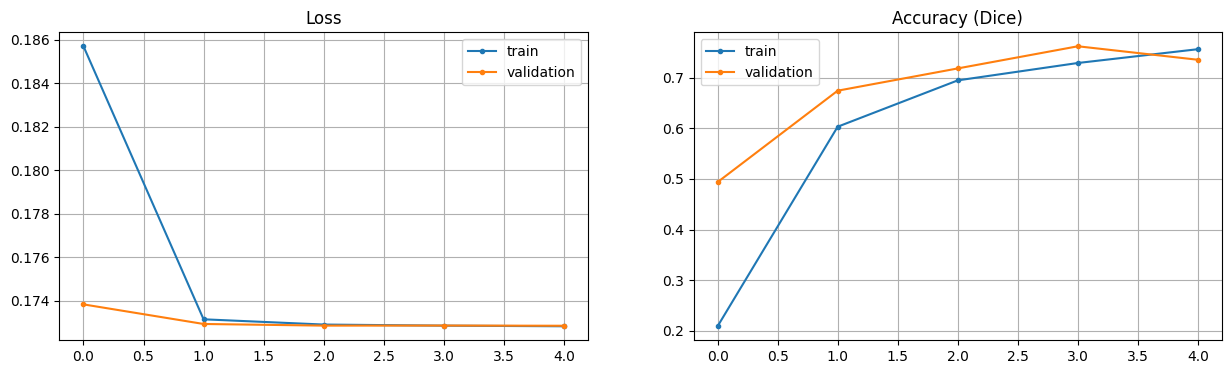

In [ ]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 9 # lowered from 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### Overfit + the scores are worse. Let us explore how the bigger batch behaves.


#### Conclusion: declined; researching increasing BATCH_SIZE 9 -> 25.

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 1324/1324 [05:00<00:00,  4.41it/s, loss 0.1783; dice 0.1680]
   Training Dice: 0.05508543848864779
   Training Loss: 0.20394352439712182
evaluation: 100%|█████████████████████████████████████████████████| 331/331 [01:06<00:00,  5.00it/s]
   Validation Dice: 0.1508134261471447
   Validation Loss: 0.1782468758140806

Epoch  2/ 5
training: 100%|███████████████████████| 1324/1324 [05:06<00:00,  4.32it/s, loss 0.1743; dice 0.4828]
   Training Dice: 0.3027846008831821
   Training Loss: 0.17566075212015486
evaluation: 100%|█████████████████████████████████████████████████| 331/331 [01:07<00:00,  4.89it/s]
   Validation Dice: 0.4056246627763679
   Validation Loss: 0.17420379894017454

Epoch  3/ 5
training: 100%|███████████████████████| 1324/1324 [05:15<00:00,  4.19it/s, loss 0.1734; dice 0.5273]
   Training Dice: 0.5285810118377929
   Training Loss: 0.17368929290699456
evaluation: 100%|██████████████

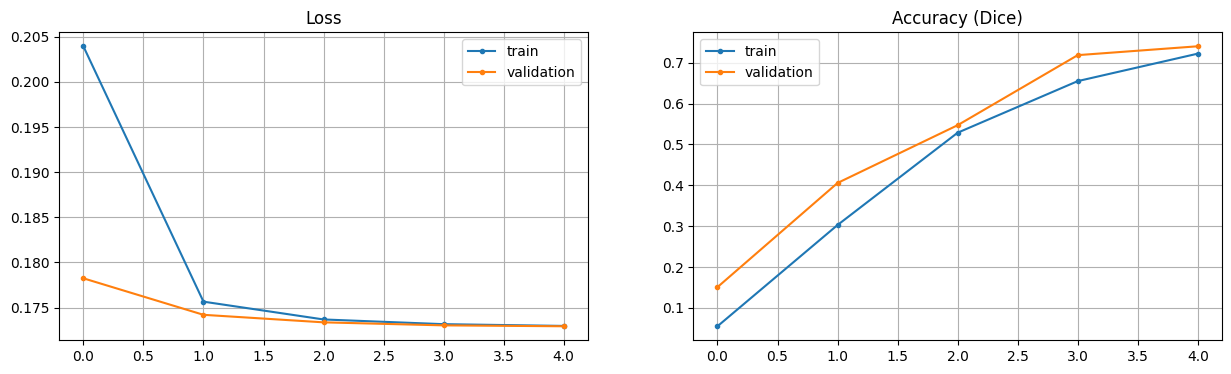

In [ ]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 25 # increased from 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### The metrics are worse. (It was unlikely that it wouldn't overfit during the next epoch, but it seems to me that the batch of 16 was an optimal choice anyway). So I suggest we return the batch 16 and explored augmentations on a few batches, then conclude which to choose or whether or not to use them.


#### Conslusion: declined; BATCH_SIZE 25 -> 16, (saving time; +kaggle limitations) epochs 5 -> 3, explore augmentations + RandomRotate90(p=0.5)

Number of trainable parameters - 14328209

Epoch  1/ 3
training: 100%|███████████████████████| 2069/2069 [05:29<00:00,  6.28it/s, loss 0.1752; dice 0.2623]
   Training Dice: 0.09139313426480028
   Training Loss: 0.19430474222513028
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:05<00:00,  7.86it/s]
   Validation Dice: 0.29267562332074926
   Validation Loss: 0.1753483584990123

Epoch  2/ 3
training: 100%|███████████████████████| 2069/2069 [05:18<00:00,  6.49it/s, loss 0.1735; dice 0.5345]
   Training Dice: 0.43516943474476205
   Training Loss: 0.17399205855121355
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:06<00:00,  7.77it/s]
   Validation Dice: 0.5643703522776727
   Validation Loss: 0.17334483151740215

Epoch  3/ 3
training: 100%|███████████████████████| 2069/2069 [05:40<00:00,  6.08it/s, loss 0.1728; dice 0.8108]
   Training Dice: 0.6239155997410093
   Training Loss: 0.17314049258014325
evaluation: 100%|████████████

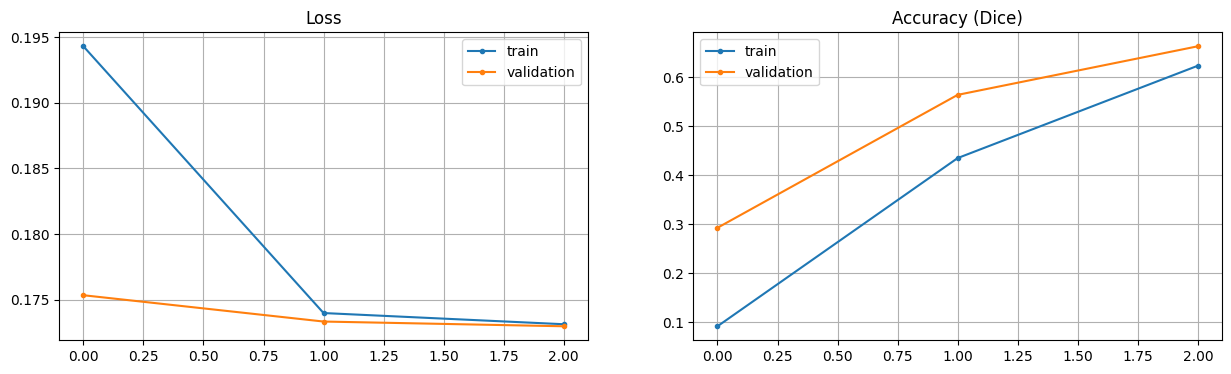

In [ ]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16 # lowered from 25
LR = 1e-4
N_EPOCHS = 3 # lowered from 5
INPUT_SIZE = (256,256)

# the list of augmentations to try:
TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
                albu.RandomRotate90(p=0.5),
#                 albu.HorizontalFlip(p=0.5),
#                 albu.VerticalFlip(p=0.5),
#                 albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),  # Random zoom-like transformation
#                 albu.RandomBrightnessContrast(p=0.5),  # Apply random brightness/contrast adjustments with a 50% probability
#                 albu.GaussianBlur(blur_limit=(3, 5), p=.5),
#                 albu.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#                 albu.GaussNoise(var_limit=(10.0, 20.0), p=.5),
#                 albu.Cutout(num_holes=1, max_h_size=16, max_w_size=16, p=.5), 
#                 albu.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.2, p=.5), 
#                 albu.GridDistortion(p=0.5),
#                 albu.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.5)
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### The model is likely to overfit. Let's see how more augmentations will impact the model so it's clearer (at this stage the continue_training method hadn't been implemented yet, but it obviously would be a better solution to go on with this).


#### Summary: test more augmentations

Number of trainable parameters - 14328209

Epoch  1/ 3
training: 100%|███████████████████████| 1655/1655 [06:31<00:00,  4.23it/s, loss 0.1767; dice 0.0874]
   Training Dice: 0.031404169307306995
   Training Loss: 0.19890696053418508
evaluation: 100%|█████████████████████████████████████████████████| 413/413 [01:12<00:00,  5.69it/s]
   Validation Dice: 0.13237806768596316
   Validation Loss: 0.17683630593608135

Epoch  2/ 3
training: 100%|███████████████████████| 1655/1655 [06:12<00:00,  4.45it/s, loss 0.1740; dice 0.2897]
   Training Dice: 0.15924730806293536
   Training Loss: 0.17489998260473558
evaluation: 100%|█████████████████████████████████████████████████| 413/413 [01:06<00:00,  6.20it/s]
   Validation Dice: 0.42660397469780925
   Validation Loss: 0.1737303378795596

Epoch  3/ 3
training: 100%|███████████████████████| 1655/1655 [06:12<00:00,  4.44it/s, loss 0.1731; dice 0.6502]
   Training Dice: 0.3801806622356447
   Training Loss: 0.1735285340389096
evaluation: 100%|███████████

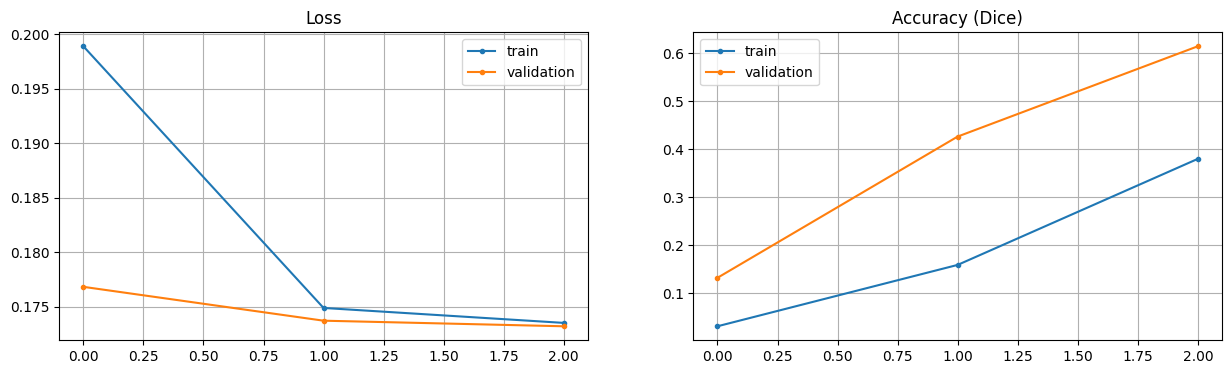

In [ ]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 3
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
                albu.RandomRotate90(p=0.5),
                albu.HorizontalFlip(p=0.5),
                albu.VerticalFlip(p=0.5),
                albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),  # Random zoom-like transformation
#                 albu.RandomBrightnessContrast(p=0.5),  # Apply random brightness/contrast adjustments with a 50% probability
#                 albu.GaussianBlur(blur_limit=(3, 5), p=.5),
#                 albu.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#                 albu.GaussNoise(var_limit=(10.0, 20.0), p=.5),
#                 albu.Cutout(num_holes=1, max_h_size=16, max_w_size=16, p=.5), 
                albu.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.2, p=.5), 
#                 albu.GridDistortion(p=0.5),
#                 albu.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.5)

            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### Now it it clear the model doesn't need any regularization. Its data is diverse and balanced. At the same time the model is complex enough to capture everything. Let's tune the learning rate now.


#### Summary: remove augmentations; train our best model, save it and add lr scheduler (ReduceLROnPlateau)

Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2069/2069 [05:16<00:00,  6.53it/s, loss 0.1751; dice 0.3180]
   Training Dice: 0.10271435470507989
   Training Loss: 0.1942292659855396
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:07<00:00,  7.62it/s]
   Validation Dice: 0.2823519803641267
   Validation Loss: 0.17514375261458023

Epoch  2/ 5
training: 100%|███████████████████████| 2069/2069 [05:11<00:00,  6.65it/s, loss 0.1734; dice 0.5513]
   Training Dice: 0.4579181224935985
   Training Loss: 0.17397251881482578
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:07<00:00,  7.68it/s]
   Validation Dice: 0.5757273401005817
   Validation Loss: 0.17331334311565533

Epoch  3/ 5
training: 100%|███████████████████████| 2069/2069 [05:12<00:00,  6.62it/s, loss 0.1728; dice 0.8364]
   Training Dice: 0.6536395662703222
   Training Loss: 0.1731103138900022
evaluation: 100%|███████████████

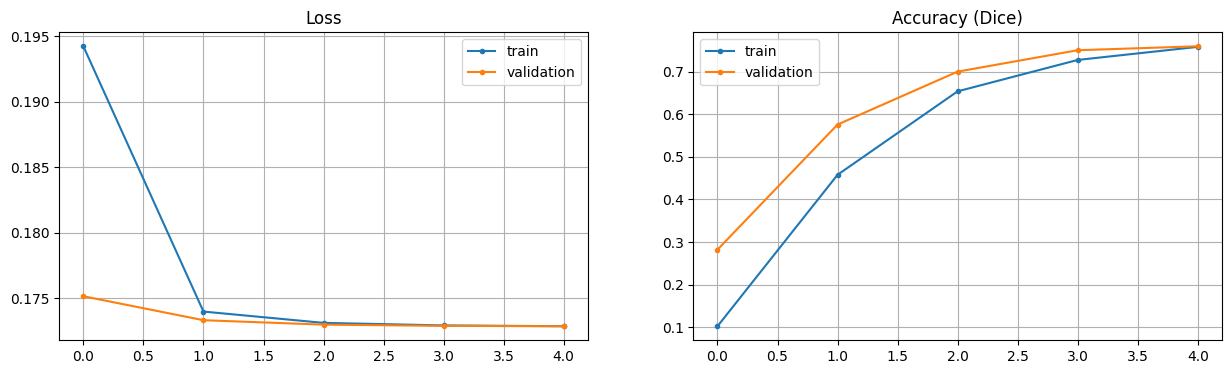

In [ ]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([ # albumentations excluded
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

#SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
SCHEDULER = None
ZERO_SHIPS_RATIO_PER_BATCH = 0.0

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_zero_ships_ratio_per_batch(ZERO_SHIPS_RATIO_PER_BATCH)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

In [ ]:
# save the model to return to this state unless it overfits or lost
unet_model_train.save_model('best_unet_1e-4_b_16_5ep.pt')

Model saved to best_unet_1e-4_b_16_5ep.pt


### As the curves gradually intersect, we want to make sure we train as carefully as possible. That is why the lr scheduler for a gradual LR decreasing is added.


#### Summary: LR 1e-4 -> 1e-4; + ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1)


Epoch  6/10
training: 100%|███████████████████████| 2069/2069 [05:11<00:00,  6.64it/s, loss 0.1727; dice 0.8339]
   Training Dice: 0.788051002192117
   Training Loss: 0.1728141559688523
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:07<00:00,  7.64it/s]
   Validation Dice: 0.8028542103112551
   Validation Loss: 0.17279658508369955

Epoch  7/10
training: 100%|███████████████████████| 2069/2069 [05:16<00:00,  6.53it/s, loss 0.1729; dice 0.8188]
   Training Dice: 0.8032809443926684
   Training Loss: 0.17278734813887697
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:14<00:00,  6.93it/s]
   Validation Dice: 0.8081866354038453
   Validation Loss: 0.17278745681105084

Epoch  8/10
training: 100%|███████████████████████| 2069/2069 [05:32<00:00,  6.22it/s, loss 0.1726; dice 0.8807]
   Training Dice: 0.8088507306149411
   Training Loss: 0.1727782965585078
evaluation: 100%|█████████████████████████████████████████████████| 517/517 

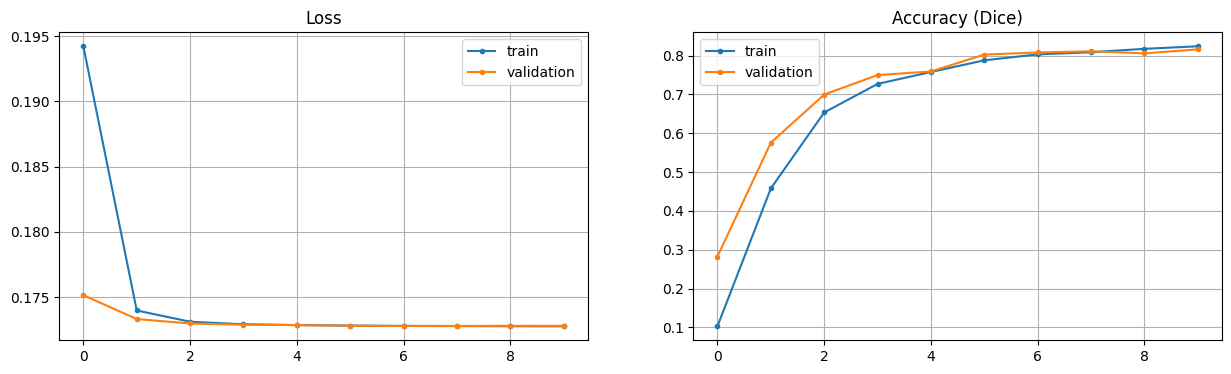

In [ ]:
torch.manual_seed(SEED)

LR = 1e-5 # lowered from 1e-4

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)

unet_model_train.continue_training(current_epoch=5, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

### The score has improved again. Going on with the training until we reach the peak performance (to a certain degree).

In [ ]:
unet_model_train.save_model('best_unet_1e-4_b_16_5ep_plus_RLROP_01_1_5ep.pt')

Model saved to best_unet_1e-4_b_16_5ep_plus_RLROP_01_1_5ep.pt


In [ ]:
torch.manual_seed(SEED)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=10, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 11/15
training: 100%|███████████████████████| 2069/2069 [05:27<00:00,  6.31it/s, loss 0.1726; dice 0.8531]
   Training Dice: 0.8260796501793223
   Training Loss: 0.1727651319479585
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:15<00:00,  6.85it/s]
   Validation Dice: 0.8282261855712942
   Validation Loss: 0.17276730058386894

Epoch 12/15
training: 100%|███████████████████████| 2069/2069 [05:21<00:00,  6.44it/s, loss 0.1729; dice 0.8424]
   Training Dice: 0.8325843679524666
   Training Loss: 0.17275098086469354
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:15<00:00,  6.89it/s]
   Validation Dice: 0.8319314812783808
   Validation Loss: 0.17276159583138773

Epoch 13/15
training: 100%|███████████████████████| 2069/2069 [05:17<00:00,  6.52it/s, loss 0.1726; dice 0.8962]
   Training Dice: 0.8372856717918621
   Training Loss: 0.17274282090527934
evaluation: 100%|█████████████████████████████████████████████████| 517/51

([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204],
 [0.10271435470507989,
  0.4579181224935985,
  0.6536395662703222,
  0.7272492964063767,
  0.7579202985003007,
  0.788051002192117,
  0.8032809443926684,
  0.8088507306149411,
  0.8176235597366409,
  0.824205900402447,
  0.8260796501793223,
  0.8325843679524666,
  0.8372856717918621,
  0.8428899877137064,
  0.84773

### New better score. Saving and going on even more carefully.

In [ ]:
unet_model_train.save_model('best_unet_1e-4_b_16_5ep_3.pt')

Model saved to best_unet_1e-4_b_16_5ep_3.pt


In [ ]:
torch.manual_seed(SEED)

LR = 1e-10 # lowered from 1e-5
N_EPOCHS=1 # try one epoch at a time

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=2, verbose=True)
unet_model_train.continue_training(current_epoch=15, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.save_model('unet_semantic_segmentation.pt')
print("The training is finished")


Epoch 16/16
training: 100%|███████████████████████| 2069/2069 [05:16<00:00,  6.55it/s, loss 0.1726; dice 0.8639]
   Training Dice: 0.8492895312618092
   Training Loss: 0.1727369504311397
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  7.07it/s]
   Validation Dice: 0.8415359871991598
   Validation Loss: 0.17275396439046878
Model saved to unet_semantic_segmentation.pt
The training is finished


In [ ]:
torch.manual_seed(SEED)

LR = 1e-10
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=16, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 17/17
training: 100%|███████████████████████| 2069/2069 [05:10<00:00,  6.67it/s, loss 0.1726; dice 0.8639]
   Training Dice: 0.8492895692025134
   Training Loss: 0.17273695036632072
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:12<00:00,  7.14it/s]
   Validation Dice: 0.8415360268587301
   Validation Loss: 0.17275396424635697


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204,
  0.17275396439046878,
  0.17275396424635697],
 [0.10271435470507989,
  0.4579181224935985,
  0.6536395662703222,
  0.7272492964063767,
  0.7579202985003007,
  0.788051002192117,
  0.8032809443926684,
  0.8088507306149411,
  0.8176235597366409,
  0.824205900402447,
  0.82

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation3.pt')

Model saved to unet_semantic_segmentation3.pt


In [ ]:
torch.manual_seed(SEED)

LR = 1e-10
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=17, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 18/18
training: 100%|███████████████████████| 2069/2069 [05:07<00:00,  6.72it/s, loss 0.1726; dice 0.8639]
   Training Dice: 0.8492896307661315
   Training Loss: 0.17273695017906593
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  6.99it/s]
   Validation Dice: 0.8415360981076091
   Validation Loss: 0.17275396384284392


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204,
  0.17275396439046878,
  0.17275396424635697,
  0.17275396413106753,
  0.17275396384284392],
 [0.10271435470507989,
  0.4579181224935985,
  0.6536395662703222,
  0.7272492964063767,
  0.7579202985003007,
  0.788051002192117,
 

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation4.pt')

Model saved to unet_semantic_segmentation4.pt


In [ ]:
torch.manual_seed(SEED)

LR = 1e-10
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=18, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 19/19
training: 100%|███████████████████████| 2069/2069 [05:14<00:00,  6.58it/s, loss 0.1726; dice 0.8639]
   Training Dice: 0.8492896667478625
   Training Loss: 0.17273695013585327
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  7.02it/s]
   Validation Dice: 0.8415361225489721
   Validation Loss: 0.17275396384284392


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593,
  0.17273695013585327],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204,
  0.17275396439046878,
  0.17275396424635697,
  0.17275396413106753,
  0.17275396384284392,
  0.17275396384284392],
 [0.10271435470507989,
  0.4579181224935985,
  0.6536395662703222,
  0.7272492964063767

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation5.pt')

Model saved to unet_semantic_segmentation5.pt


In [ ]:
torch.manual_seed(SEED)

LR = 1e-10
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=19, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 20/20
training: 100%|███████████████████████| 2069/2069 [05:13<00:00,  6.60it/s, loss 0.1726; dice 0.8639]
   Training Dice: 0.8492897021534248
   Training Loss: 0.17273695013585327
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:14<00:00,  6.98it/s]
   Validation Dice: 0.8415361662436731
   Validation Loss: 0.17275396384284392


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593,
  0.17273695013585327,
  0.17273695013585327],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204,
  0.17275396439046878,
  0.17275396424635697,
  0.17275396413106753,
  0.17275396384284392,
  0.17275396384284392,
  0.17275396384284392],
 [0.10271435470507989,
  0.45791812249359

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation6.pt')

Model saved to unet_semantic_segmentation6.pt


### The model evolves confidently, but slowly. Increasing the LR...


#### Summary: LR 1e-10 -> 1e-9

In [ ]:
# fourth step
torch.manual_seed(SEED)

LR = 1e-9 # increased from 1e-10
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=20, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 21/21
training: 100%|███████████████████████| 2069/2069 [05:15<00:00,  6.55it/s, loss 0.1726; dice 0.8639]
   Training Dice: 0.8492906844345137
   Training Loss: 0.17273694765112607
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  7.05it/s]
   Validation Dice: 0.8415395254323285
   Validation Loss: 0.17275395629138504


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593,
  0.17273695013585327,
  0.17273695013585327,
  0.17273694765112607],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204,
  0.17275396439046878,
  0.17275396424635697,
  0.17275396413106753,
  0.17275396384284392,
  0.17275396384284392,
  0.17275396384284392,
  0.172753956291385

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation7.pt')

Model saved to unet_semantic_segmentation7.pt


#### Summary: LR 1e-9 -> 1e-8

In [ ]:
torch.manual_seed(SEED)

LR = 1e-8 # increased from 1e-9
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=21, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 22/22
training: 100%|███████████████████████| 2069/2069 [05:14<00:00,  6.57it/s, loss 0.1726; dice 0.8641]
   Training Dice: 0.8493362566939641
   Training Loss: 0.1727368658495848
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  6.99it/s]
   Validation Dice: 0.8416611977656528
   Validation Loss: 0.17275374075776143


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593,
  0.17273695013585327,
  0.17273695013585327,
  0.17273694765112607,
  0.1727368658495848],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204,
  0.17275396439046878,
  0.17275396424635697,
  0.17275396413106753,
  0.17275396384284392,
  0.17275396384284392,
  0.1727539638428439

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation8.pt')

Model saved to unet_semantic_segmentation8.pt


#### Summary: LR 1e-8 -> 1e-7

In [ ]:
# fourth step
torch.manual_seed(SEED)

LR = 1e-7 # increased from 1e-8
N_EPOCHS=5 # increased from 1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=2, verbose=True)
unet_model_train.continue_training(current_epoch=22, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 23/27
training: 100%|███████████████████████| 2069/2069 [05:12<00:00,  6.63it/s, loss 0.1726; dice 0.8644]
   Training Dice: 0.8496044799865531
   Training Loss: 0.172736340700687
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  7.05it/s]
   Validation Dice: 0.8418740211649144
   Validation Loss: 0.1727526666347939

Epoch 24/27
training: 100%|███████████████████████| 2069/2069 [05:14<00:00,  6.58it/s, loss 0.1729; dice 0.8509]
   Training Dice: 0.8509196018815444
   Training Loss: 0.17272757709660122
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:14<00:00,  6.98it/s]
   Validation Dice: 0.842222807255197
   Validation Loss: 0.17274994064461102

Epoch 25/27
training: 100%|███████████████████████| 2069/2069 [05:14<00:00,  6.58it/s, loss 0.1726; dice 0.9048]
   Training Dice: 0.8515693316026377
   Training Loss: 0.17272409630346092
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [

KeyboardInterrupt: 

### Overfit after the 24th epoch. I have terminated the training.


#### Summary: reload the best state (unet_semantic_segmentation8.pt); train 2 more epochs

In [ ]:
checkpoint = torch.load('/kaggle/working/unet_semantic_segmentation8.pt')
unet_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
# fourth step
torch.manual_seed(SEED)

LR = 1e-7
N_EPOCHS=2

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=2, verbose=True)
unet_model_train.continue_training(current_epoch=22, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 23/24
training: 100%|███████████████████████| 2069/2069 [05:17<00:00,  6.51it/s, loss 0.1726; dice 0.8644]
   Training Dice: 0.8496044799865531
   Training Loss: 0.172736340700687
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  6.99it/s]
   Validation Dice: 0.8418740211649144
   Validation Loss: 0.1727526666347939

Epoch 24/24
training: 100%|███████████████████████| 2069/2069 [05:17<00:00,  6.52it/s, loss 0.1729; dice 0.8509]
   Training Dice: 0.8509196018815444
   Training Loss: 0.17272757709660122
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:14<00:00,  6.95it/s]
   Validation Dice: 0.842222807255197
   Validation Loss: 0.17274994064461102


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593,
  0.17273695013585327,
  0.17273695013585327,
  0.17273694765112607,
  0.1727368658495848,
  0.172736340700687,
  0.17272757709660122,
  0.17272409630346092,
  0.17271842254769576,
  0.172736340700687,
  0.17272757709660122],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
  0.17277420653711204,
 

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation9.pt')

Model saved to unet_semantic_segmentation9.pt


#### Summary: LR 1e-7 -> 1e-8; epochs -> 1

In [ ]:
# fourth step
torch.manual_seed(SEED)

LR = 1e-8 # lowered from 1e-7 (going carefully again)
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=2, verbose=True)
unet_model_train.continue_training(current_epoch=24, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 25/25
training: 100%|███████████████████████| 2069/2069 [05:14<00:00,  6.57it/s, loss 0.1726; dice 0.8651]
   Training Dice: 0.8505528618771999
   Training Loss: 0.17273538856041956
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  7.00it/s]
   Validation Dice: 0.8425204018329052
   Validation Loss: 0.17275240270842435


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593,
  0.17273695013585327,
  0.17273695013585327,
  0.17273694765112607,
  0.1727368658495848,
  0.172736340700687,
  0.17272757709660122,
  0.17272409630346092,
  0.17271842254769576,
  0.172736340700687,
  0.17272757709660122,
  0.17273538856041956],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,
  0.17276159583138773,
  0.17276468873023987,
  0.1727650689548404,
 

In [ ]:
unet_model_train.save_model('unet_semantic_segmentation10.pt')

Model saved to unet_semantic_segmentation10.pt


In [ ]:
# fourth step
torch.manual_seed(SEED)

LR = 1e-8
N_EPOCHS=3

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=2, verbose=True)
unet_model_train.continue_training(current_epoch=25, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 26/28
training: 100%|███████████████████████| 2069/2069 [05:14<00:00,  6.58it/s, loss 0.1726; dice 0.8650]
   Training Dice: 0.8503858050094704
   Training Loss: 0.17273532863167992
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:13<00:00,  7.01it/s]
   Validation Dice: 0.8424089130165499
   Validation Loss: 0.17275234310377957

Epoch 27/28
training:   8%|█▉                      | 162/2069 [00:24<04:53,  6.51it/s, loss 0.1721; dice 0.9013]


KeyboardInterrupt: 

#### Summary: overfit again. reload the best state; train further with LR 1e-8 -> 1e-9

In [ ]:
checkpoint = torch.load('/kaggle/working/unet_semantic_segmentation10.pt')
unet_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
# fourth step
torch.manual_seed(SEED)

LR = 1e-9 # lowered from 1e-8
N_EPOCHS=1

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=25, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 26/26
training: 100%|███████████████████████| 2069/2069 [05:20<00:00,  6.46it/s, loss 0.1726; dice 0.8651]
   Training Dice: 0.8504695207269484
   Training Loss: 0.17273534220765327
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:14<00:00,  6.92it/s]
   Validation Dice: 0.842514675982455
   Validation Loss: 0.17275240020087887


([0.1942292659855396,
  0.17397251881482578,
  0.1731103138900022,
  0.1729144006463397,
  0.17285437727821454,
  0.1728141559688523,
  0.17278734813887697,
  0.1727782965585078,
  0.17276484987740356,
  0.17276108320379327,
  0.1727651319479585,
  0.17275098086469354,
  0.17274282090527934,
  0.17273319043388338,
  0.17273182650589608,
  0.1727369504311397,
  0.17273695036632072,
  0.17273695030150177,
  0.17273695017906593,
  0.17273695013585327,
  0.17273695013585327,
  0.17273694765112607,
  0.1727368658495848,
  0.172736340700687,
  0.17272757709660122,
  0.17272409630346092,
  0.17271842254769576,
  0.172736340700687,
  0.17272757709660122,
  0.17273538856041956,
  0.17273532863167992,
  0.17273521042348336,
  0.17273534220765327],
 [0.17514375261458023,
  0.17331334311565533,
  0.17297482216727111,
  0.17288262611777455,
  0.17284973127122544,
  0.17279658508369955,
  0.17278745681105084,
  0.17278376665521175,
  0.1727955317992998,
  0.17279342891976265,
  0.17276730058386894,


#### Summary: the precision is considered enough to stop. The best scores are:
- Dice: 0.84251
- Loss: 0.17275 (smaller loss chosen to higher dice)

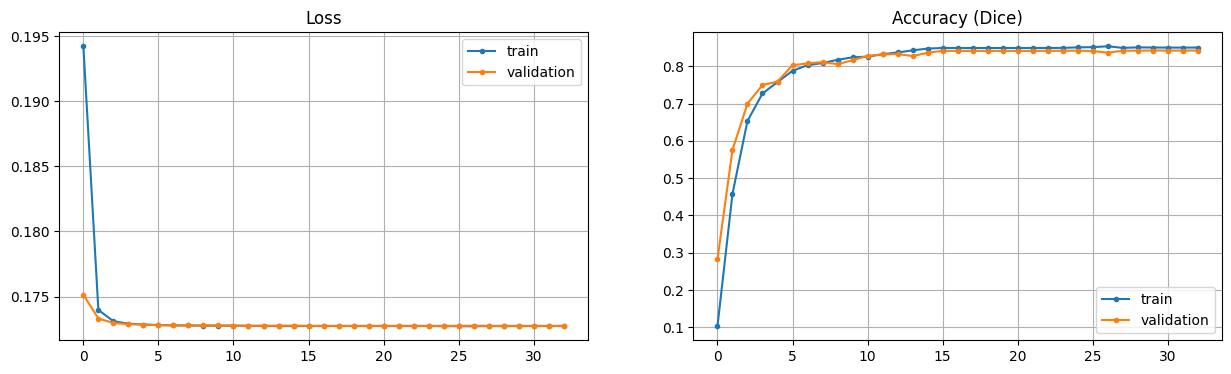

In [ ]:
unet_model_train.plot_loss_acc_per_ep()

## 6. Making and visualizing predictions

In [ ]:
def apply_threshold(mask: np.ndarray, threshold: float):
    """
    Applies a threshold to a mask.

    Parameters:
    - mask (numpy.ndarray): Input predicted mask array.
    - threshold (float): Threshold value.

    Returns:
    - thresholded_mask (numpy.ndarray): Thresholded mask array.
    """
    return (mask > threshold).astype(np.uint8)

def get_prediction(model: nn.Module, image_name: str, shape: tuple=(256,256)):
    """
    Get predictions for a given image using the specified model.

    Parameters:
    - model (nn.Module): Trained model.
    - image_name (str): Name of the image file.
    - shape (tuple): height and width of the final mask

    Returns:
    - predicted_mask (numpy.ndarray): Predicted mask array if the image is within the validation data, None otherwise.
    """
    # Check if the image is in the validation data
    if len(validation_df[validation_df['ImageId'] == image_name]) == 0:
        print("The", image_name, "doesn't exist or may be in a training data. We need to assess the quality utilizing the unseen data only")
        return None

    # Read the image using OpenCV and convert it to RGB color space
    image = cv2.imread(os.path.join(TRAIN_URL, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to the desired input size using bilinear interpolation
    image = cv2.resize(image, shape, interpolation=cv2.INTER_LINEAR)

    # Apply validation augmentations to the image
    image = VALID_AUGS(image=image)['image']

    # Convert the image to a PyTorch tensor, permute dimensions, add batch dimension, and move to the device
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device) # from (width, height, color_channel) to (batch_size=1, color_channel, width, height)

    # Perform prediction
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        predicted_mask = model(image_tensor).sigmoid().squeeze().cpu().numpy() # convert to probabilities, reshape into (width, height), move to cpu and cast to numpy

    return predicted_mask

### Visualizing 3 images of each from the validation data: no ships images, single ship images, multiple ships images. We will also pick the optimal threshold for the predictions.


#### Summary: plot 3 images from each ship category (==0; ==1; >1), tune the THRESHOLD for the predictions to identify ships. 

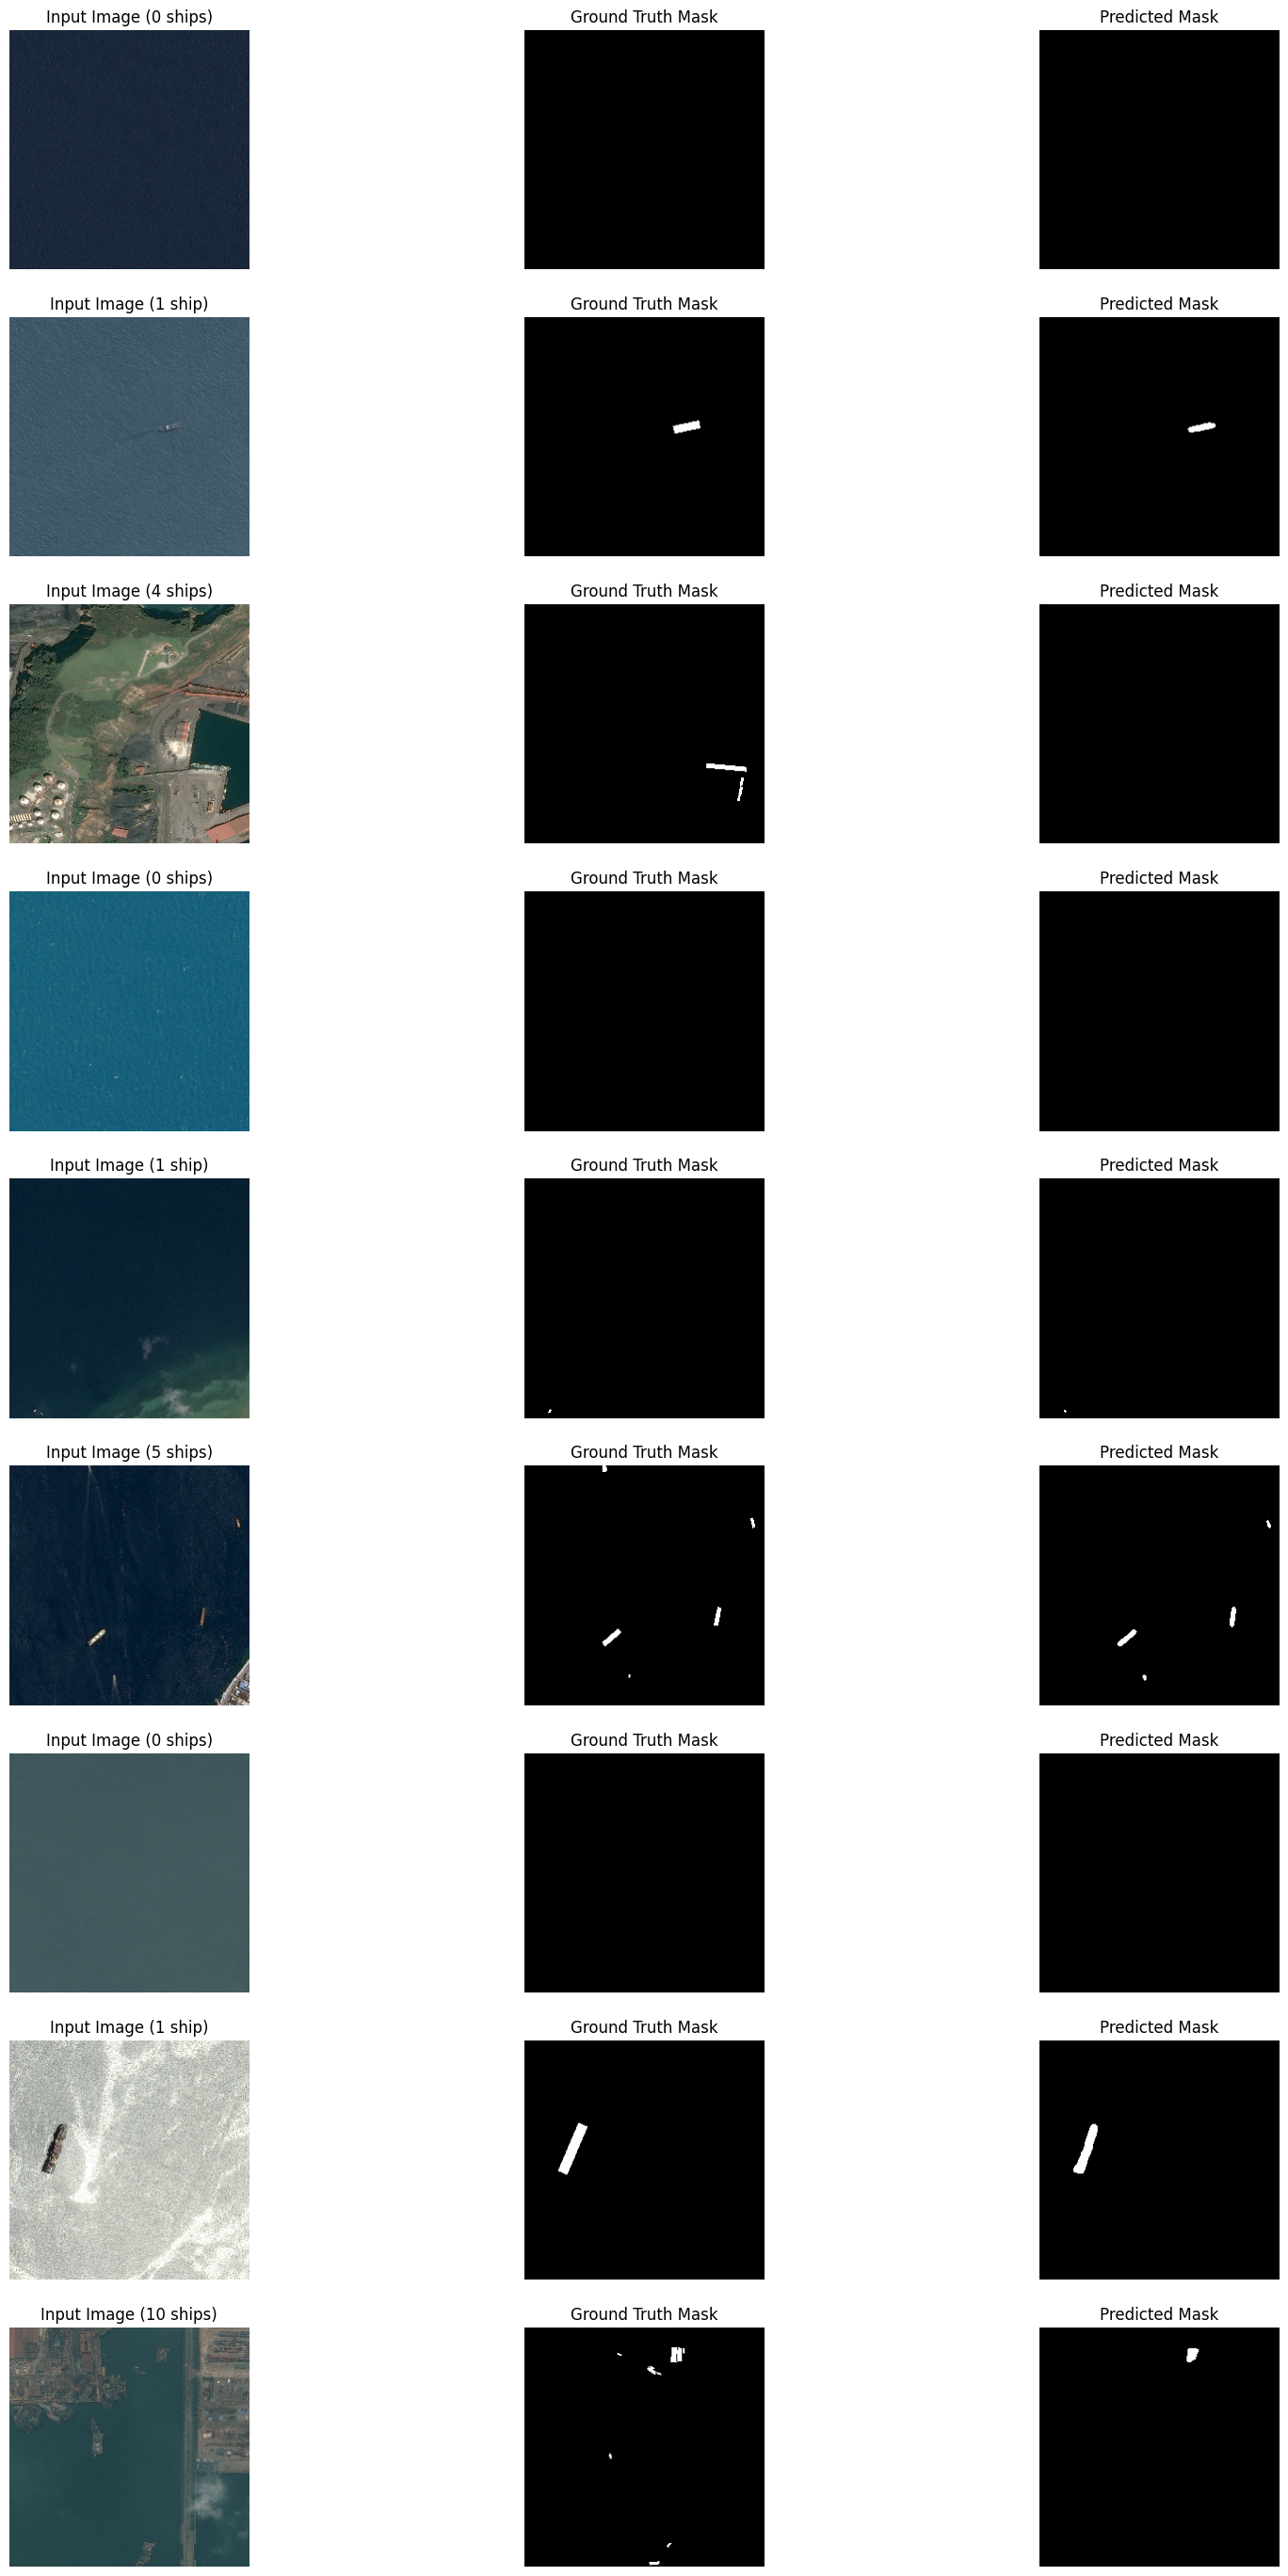

In [ ]:
# Define the input size for images and the threshold for prediction
INPUT_SIZE = (256,256)
THRESHOLD = 1e-2 # tuned towards less noise

# Define lists of images for different scenarios: no ships, single ship, and multiple ships (all from the unseen data)
no_ships_images = ['f999ee8f8.jpg', 'b580b30d8.jpg', 'b8aa20450.jpg']
single_ship_images = ['819d73d7f.jpg', '18f8bd19a.jpg', '23e6b9ab2.jpg']
multiple_ships_images = ['1a7ae404b.jpg', 'df36a66aa.jpg', '5ef5e8aa9.jpg']

# Determine the number of rows needed for the subplot grid
ROWS_PER_IMAGE = max(len(no_ships_images), len(single_ship_images), len(multiple_ships_images)) * 3

# Create a figure and subplots for displaying images and masks
fig = plt.figure(figsize=(20, 35))    
axis = fig.subplots(ROWS_PER_IMAGE, 3)

# Loop over images with no ships
for i, no_ship_img in enumerate(no_ships_images):
    # Plot the input image with no ships
    plot_the_image(os.path.join(TRAIN_URL, no_ship_img), axis[i*3, 0], INPUT_SIZE)
    axis[i*3, 0].set_title('Input Image (0 ships)')
    axis[i*3, 0].axis('off')
    
    # Plot the ground truth mask
    plot_the_mask(validation_df[validation_df['ImageId']==no_ship_img]['EncodedPixels'], axis[i*3, 1], INPUT_SIZE)
    axis[i*3, 1].set_title('Ground Truth Mask')
    axis[i*3, 1].axis('off')
    
    # Get and plot the predicted mask
    predicted_mask = get_prediction(unet_model, no_ship_img)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)
    axis[i*3, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3, 2].set_title('Predicted Mask')
    axis[i*3, 2].axis('off')
    
# Loop over images with single ship
for i, single_ship_img in enumerate(single_ship_images):
    # Plot the input image with one ship
    plot_the_image(os.path.join(TRAIN_URL, single_ship_img), axis[i*3+1, 0], INPUT_SIZE)
    axis[i*3+1, 0].set_title('Input Image (1 ship)')
    axis[i*3+1, 0].axis('off')
    
    # Plot the ground truth mask
    plot_the_mask(validation_df[validation_df['ImageId']==single_ship_img]['EncodedPixels'], axis[i*3+1, 1], INPUT_SIZE)
    axis[i*3+1, 1].set_title('Ground Truth Mask')
    axis[i*3+1, 1].axis('off')

    # Get and plot the predicted mask
    predicted_mask = get_prediction(unet_model, single_ship_img)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)
    axis[i*3+1, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+1, 2].set_title('Predicted Mask')
    axis[i*3+1, 2].axis('off')
    
# Loop over images with multiple ships
for i, mult_ship_img in enumerate(multiple_ships_images):
    # Plot the input image with multiple ships
    plot_the_image(os.path.join(TRAIN_URL, mult_ship_img), axis[i*3+2, 0], INPUT_SIZE)
    axis[i*3+2, 0].set_title('Input Image (' + str(validation_df[validation_df['ImageId']==mult_ship_img]['Ships'].values[0]) + ' ships)')
    axis[i*3+2, 0].axis('off')
    
    # Plot the ground truth mask
    plot_the_mask(validation_df[validation_df['ImageId']==mult_ship_img]['EncodedPixels'], axis[i*3+2, 1], INPUT_SIZE)
    axis[i*3+2, 1].set_title('Ground Truth Mask')
    axis[i*3+2, 1].axis('off')

    # Get and plot the predicted mask
    predicted_mask = get_prediction(unet_model, mult_ship_img)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)
    axis[i*3+2, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+2, 2].set_title('Predicted Mask')
    axis[i*3+2, 2].axis('off')

### Lowering the threshold

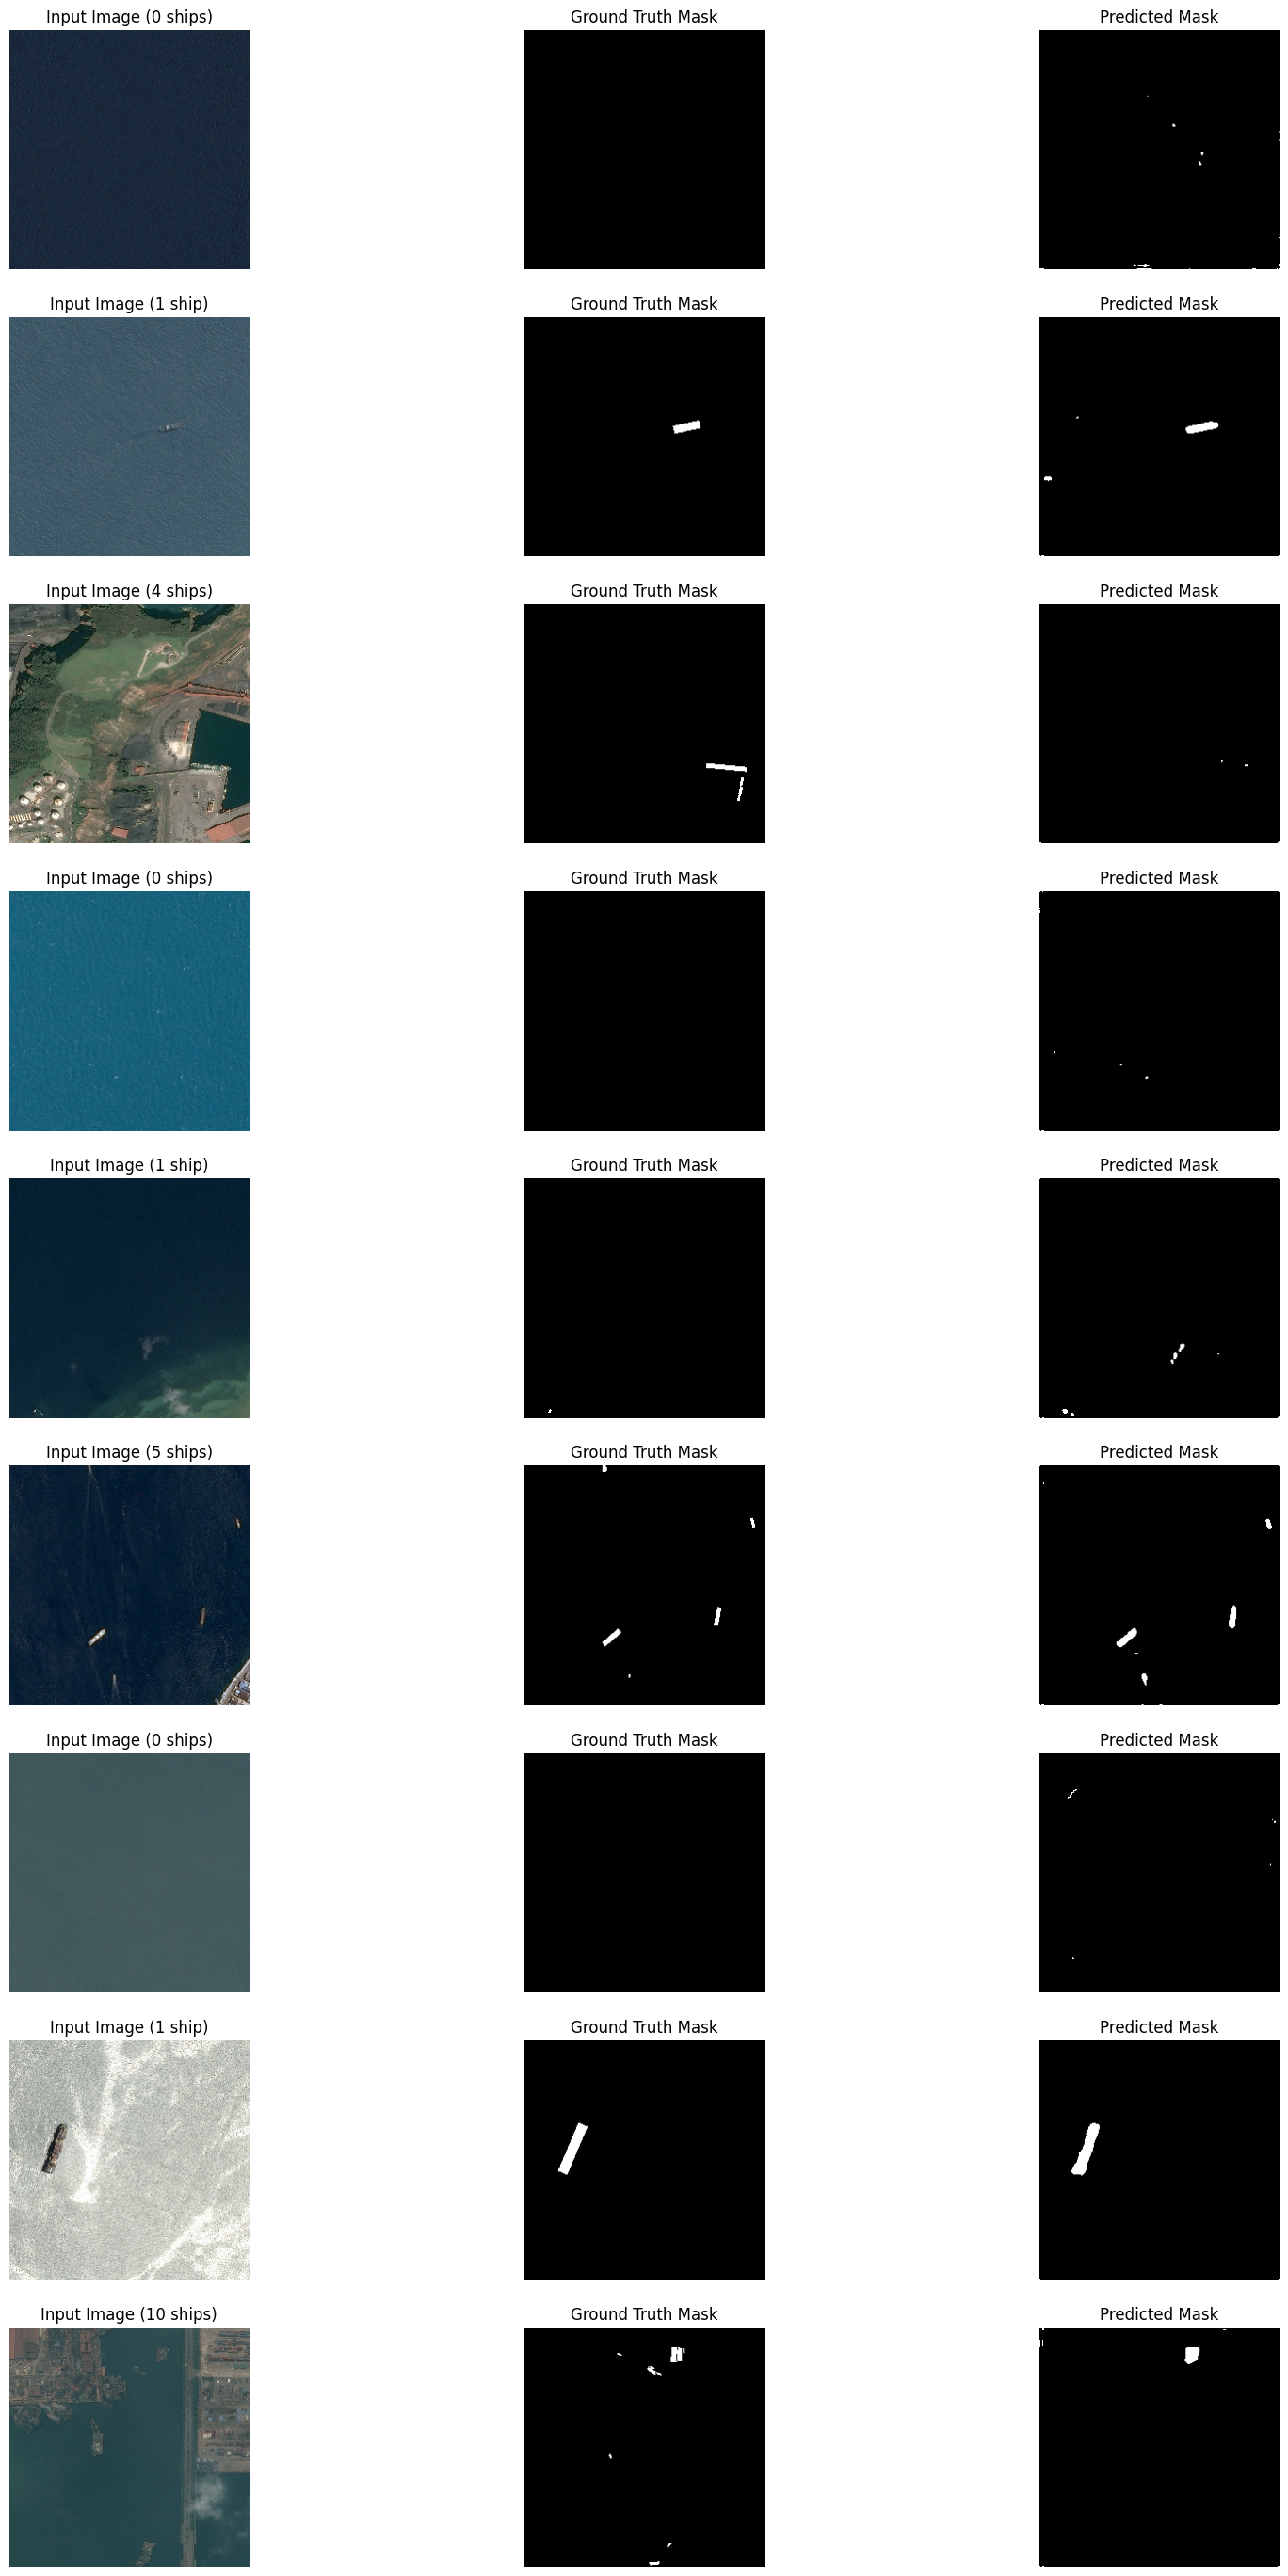

In [ ]:
INPUT_SIZE = (256,256)
THRESHOLD = 1e-5

no_ships_images = ['f999ee8f8.jpg', 'b580b30d8.jpg', 'b8aa20450.jpg']
single_ship_images = ['819d73d7f.jpg', '18f8bd19a.jpg', '23e6b9ab2.jpg']
multiple_ships_images = ['1a7ae404b.jpg', 'df36a66aa.jpg', '5ef5e8aa9.jpg']

ROWS_PER_IMAGE = max(len(no_ships_images), len(single_ship_images), len(multiple_ships_images))*3

fig = plt.figure(figsize=(20, 35))    
axis = fig.subplots(ROWS_PER_IMAGE,3)

for i, no_ship_img in enumerate(no_ships_images):
    plot_the_image(os.path.join(TRAIN_URL, no_ship_img), axis[i*3, 0], INPUT_SIZE)
    
    axis[i*3, 0].set_title('Input Image (0 ships)')
    axis[i*3, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==no_ship_img]['EncodedPixels'], axis[i*3, 1], INPUT_SIZE)

    axis[i*3, 1].set_title('Ground Truth Mask')
    axis[i*3, 1].axis('off')
    
    predicted_mask = get_prediction(unet_model, no_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3, 2].set_title('Predicted Mask')
    axis[i*3, 2].axis('off')
    
for i, single_ship_img in enumerate(single_ship_images):
    plot_the_image(os.path.join(TRAIN_URL, single_ship_img), axis[i*3+1, 0], INPUT_SIZE)
    
    axis[i*3+1, 0].set_title('Input Image (1 ship)')
    axis[i*3+1, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==single_ship_img]['EncodedPixels'], axis[i*3+1, 1], INPUT_SIZE)
    
    axis[i*3+1, 1].set_title('Ground Truth Mask')
    axis[i*3+1, 1].axis('off')

    predicted_mask = get_prediction(unet_model, single_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3+1, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+1, 2].set_title('Predicted Mask')
    axis[i*3+1, 2].axis('off')
    
for i, mult_ship_img in enumerate(multiple_ships_images):
    plot_the_image(os.path.join(TRAIN_URL, mult_ship_img), axis[i*3+2, 0], INPUT_SIZE)
    
    axis[i*3+2, 0].set_title('Input Image (' + str(validation_df[validation_df['ImageId']==mult_ship_img]['Ships'].values[0]) + ' ships)')
    axis[i*3+2, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==mult_ship_img]['EncodedPixels'], axis[i*3+2, 1], INPUT_SIZE)
    
    axis[i*3+2, 1].set_title('Ground Truth Mask')
    axis[i*3+2, 1].axis('off')

    predicted_mask = get_prediction(unet_model, mult_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3+2, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+2, 2].set_title('Predicted Mask')
    axis[i*3+2, 2].axis('off')

### Conclusion: the model has shown its best performance with the threshold of 1e-2, but has problems with identifying multiple ships. The model with lower thresholds results in a lot of noise in simpler cases while doing better in finding multiple ships (the trade-off is not worthy).


#### Summary: the best threshold is 1e-2.

## 7. Revising

### The value of THRESHOLD = 1e-2 is an optimal choice. Values below it will result in noise (false positives) on pictures with fewer or no ships, above it - bad-quality multiple ships predictions (it thinks there are fewer). I assume we should consider retraining with stratification by number of ships per batch (instead of non-ship masks we did before).

In [ ]:
# printing the image qty for single-ship images
print(len(train_df[train_df['Ships']==1]))

# printing the image qty for > 1 ships
print(len(train_df[train_df['Ships']>1]))

21093
12026


### We will utilize our custom sampler with insignificant changes implemented into the code. Changes will be marked with comments. The only thing we need to do is to evaluate the ratio of ships > 1 per batch. We can do this based on our custom batch size length formula. Together we have:

In [ ]:
train_images = len(train_df[train_df['Ships']==1]) + len(train_df[train_df['Ships']>1]) # 21093 + 12026 = 33119 images for training
train_batches = (21093 + 12026) // BATCH_SIZE # 33119 // 16 = 2069 batches

### Thus, taking this number into consideration we want to pick a coefficient that wouldn't exceed the total value of 2069 batches (to minimize repeatability and, therefore, overfit during training). According to the formula we get a coefficient of 0.3629:

In [ ]:
21093 // (16 * (1 - 0.3629))

2069.0

### Making the changes:

In [36]:
class ShipStratifiedSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size, multiple_ships_ratio_per_batch): # now we evaluate multiple ships ratio
        self.data_source = data_source
        self.batch_size = batch_size
        self.multiple_ships_ratio_per_batch = multiple_ships_ratio_per_batch

        self.multiple_ships_indices = data_source[data_source['Ships'] > 1].index.tolist() # multiple ships images
        self.single_ship_indices = data_source[data_source['Ships'] == 1].index.tolist() # single ships images
        
        self.num_batches = int(len(self.single_ship_indices) // (batch_size * (1 - self.multiple_ships_ratio_per_batch)))

        
    def __iter__(self):
        
        random.seed(SEED)
        random.shuffle(self.multiple_ships_indices)
        random.shuffle(self.single_ship_indices)
        
        for _ in range(self.num_batches):
            # Sample indices for multiple ships
            num_mult_ships = int(self.batch_size * self.multiple_ships_ratio_per_batch)
            sampled_mult_ships = random.sample(self.multiple_ships_indices, num_mult_ships)

            # Sample indices for single-ship images
            num_single_ships = self.batch_size - num_mult_ships
            sampled_single_ships = random.sample(self.single_ship_indices, num_single_ships)

            # Combine sampled indices for both types of batches
            sampled_indices = sampled_mult_ships + sampled_single_ships

            # Yield individual indices for the batch
            for idx in sampled_indices:
                yield idx

    def __len__(self):
        return self.num_batches * self.batch_size

In [37]:
# testing whether the sampler works as expected
test_sampler = ShipStratifiedSampler(data_source=train_df, batch_size=BATCH_SIZE, multiple_ships_ratio_per_batch = 0.3629)

batch_indices = []
batch_ships = []

for idx in test_sampler:
    if len(batch_ships) == BATCH_SIZE: # sample only one batch
        break
    else:
        batch_indices.append(idx)
        batch_ships.append(train_df['Ships'].loc[idx])
        
# print sampled indices
print(batch_indices)

# print sampled ship amounts
print(batch_ships)

[58924, 4777, 33100, 56180, 29006, 23019, 24534, 55731, 48974, 34533, 5344, 30645, 12608, 64111, 52000, 39153]
[2, 5, 4, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Making the respective changes in the training model class (marked with comments again):

In [38]:
class TrainAndTestModel:
    def __init__(self, model, device, dataset_train, dataset_val, train_augs=None, valid_augs=None, images_dir=TRAIN_URL, input_size = (768, 768)):
        self.dataset_train = dataset_train
        self.dataset_val = dataset_val

        self.model = model
        self.device = device

        self.train_losses = []
        self.train_dices = []
        self.valid_losses = []
        self.valid_dices = []

        self.batch = BATCH_SIZE
        self.workers = os.cpu_count() // 2

        self.input_size = input_size
        self.images_dir = images_dir
        self.multiple_ships_ratio_per_batch = 0.3629 # new ratio

        #
        if train_augs is None:
            train_augs = albu.Compose([
                albu.Resize(*self.input_size),
                albu.Normalize(),
            ])

        if valid_augs is None:
            valid_augs = albu.Compose([
              albu.Resize(*self.input_size),
              albu.Normalize(),
        ])


        self.train_augs = train_augs
        self.valid_augs = valid_augs


    def get_accuracies_n_losses(self):
        return self.train_losses, self.valid_losses, self.train_dices, self.valid_dices
    
    def set_multiple_ships_ratio_per_batch(self, val):
        self.multiple_ships_ratio_per_batch = val


    def train(self, n_batch, n_epochs, optimizer, loss_fn, metric_fn, scheduler=None):
        self.batch = n_batch
        self.workers = os.cpu_count() // 2

        _train_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_train, augmentations=self.train_augs, images_dir=self.images_dir),
            batch_size=self.batch,
            sampler=ShipStratifiedSampler(data_source=self.dataset_train, batch_size=self.batch, multiple_ships_ratio_per_batch = self.multiple_ships_ratio_per_batch), # updated sampler
            num_workers=self.workers,
            shuffle=False,
            drop_last=True,
            persistent_workers=True,
            pin_memory=False
        )

        _valid_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_val, augmentations=self.valid_augs, images_dir=TRAIN_URL),
            batch_size=BATCH_SIZE,
            sampler=ShipStratifiedSampler(data_source=self.dataset_val, batch_size=self.batch, multiple_ships_ratio_per_batch = self.multiple_ships_ratio_per_batch), # updated sampler
            num_workers=self.workers,
            shuffle=False,
            drop_last=False,
            pin_memory=False
        )

        for ep in range(n_epochs):
            print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

            _train_logs = train_one_epoch(model=self.model, loader=_train_loader, criterion=loss_fn, optimizer=optimizer, metric_fn=metric_fn, device=self.device, verbose=True)
            _train_dice = np.mean(_train_logs["dices"])
            self.train_dices.append(_train_dice)
            _train_loss = np.mean(_train_logs["losses"])
            self.train_losses.append(_train_loss)

            print("   Training Dice:", self.train_dices[-1])
            print("   Training Loss:", self.train_losses[-1])

            _valid_logs = evaluate(model=self.model, loader=_valid_loader, criterion=loss_fn, metric_fn=metric_fn, device=self.device, verbose=True)
            _valid_dice = np.mean(_valid_logs["dices"])
            self.valid_dices.append(_valid_dice)
            _valid_loss = np.mean(_valid_logs["losses"])
            self.valid_losses.append(_valid_loss)

            print("   Validation Dice:", self.valid_dices[-1])
            print("   Validation Loss:", self.valid_losses[-1])

        if scheduler != None:
            scheduler.step(_valid_dice)

        return self.get_accuracies_n_losses()
    
    def continue_training(self, current_epoch, n_batch, n_epochs, optimizer, loss_fn, metric_fn, scheduler=None):
        self.batch = n_batch
        _workers = os.cpu_count() // 2

        _train_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_train, augmentations=self.train_augs, images_dir=self.images_dir),
            batch_size=self.batch,
            sampler=ShipStratifiedSampler(data_source=self.dataset_train, batch_size=self.batch, multiple_ships_ratio_per_batch = self.multiple_ships_ratio_per_batch), # updated sampler
            num_workers=self.workers,
            shuffle=False,
            drop_last=True,
            persistent_workers=True,
            pin_memory=False
        )

        _valid_loader = DataLoader(
            AirbusShipDetectionDataset(df_in=self.dataset_val, augmentations=self.valid_augs, images_dir=TRAIN_URL),
            batch_size=BATCH_SIZE,
            sampler=ShipStratifiedSampler(data_source=self.dataset_val, batch_size=self.batch, multiple_ships_ratio_per_batch = self.multiple_ships_ratio_per_batch), # updated sampler
            num_workers=self.workers,
            shuffle=False,
            drop_last=False,
            pin_memory=False
        )

        for ep in range(current_epoch, current_epoch + n_epochs):
            print(f"\nEpoch {ep + 1:2d}/{current_epoch + n_epochs:2d}")

            _train_logs = train_one_epoch(model=self.model, loader=_train_loader, criterion=loss_fn, optimizer=optimizer, metric_fn = metric_fn, device=self.device, verbose=True)
            _train_dice = np.mean(_train_logs["dices"])
            self.train_dices.append(_train_dice)
            _train_loss = np.mean(_train_logs["losses"])
            self.train_losses.append(_train_loss)

            print("   Training Dice:", self.train_dices[-1])
            print("   Training Loss:", self.train_losses[-1])

            _valid_logs = evaluate(model=self.model, loader=_valid_loader, criterion=loss_fn, metric_fn=metric_fn, device=self.device, verbose=True)
            _valid_dice = np.mean(_valid_logs["dices"])
            self.valid_dices.append(_valid_dice)
            _valid_loss = np.mean(_valid_logs["losses"])
            self.valid_losses.append(_valid_loss)

            print("   Validation Dice:", self.valid_dices[-1])
            print("   Validation Loss:", self.valid_losses[-1])

        if scheduler != None:
            scheduler.step(_valid_dice)

        return self.get_accuracies_n_losses()

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")


    def plot_loss_acc_per_ep(self):
        fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

        axes[0].plot(np.arange(len(self.train_losses)), self.train_losses, ".-")
        axes[0].plot(np.arange(len(self.valid_losses)), self.valid_losses, ".-")
        axes[0].legend(["train", "validation"])
        axes[0].set_title("Loss")
        axes[0].grid()

        axes[1].plot(np.arange(len(self.train_dices)), self.train_dices, ".-")
        axes[1].plot(np.arange(len(self.valid_dices)), self.valid_dices, ".-")
        axes[1].legend(["train", "validation"])
        axes[1].set_title("Accuracy (Dice)")
        axes[1].grid()

        plt.show()
        plt.close()

### Perform training again sticking to the same strategy as long as we have the same output.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s] 


Number of trainable parameters - 14328209

Epoch  1/ 5
training: 100%|███████████████████████| 2069/2069 [05:48<00:00,  5.94it/s, loss 0.1752; dice 0.3309]
   Training Dice: 0.10493785647923867
   Training Loss: 0.19463749686521628
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:21<00:00,  6.36it/s]
   Validation Dice: 0.2853777139398992
   Validation Loss: 0.1754052702416765

Epoch  2/ 5
training: 100%|███████████████████████| 2069/2069 [04:56<00:00,  6.98it/s, loss 0.1733; dice 0.4619]
   Training Dice: 0.4538194308891972
   Training Loss: 0.1740093575966076
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:06<00:00,  7.75it/s]
   Validation Dice: 0.5816076601669913
   Validation Loss: 0.1733271416197432

Epoch  3/ 5
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.35it/s, loss 0.1729; dice 0.6310]
   Training Dice: 0.6579540391556591
   Training Loss: 0.17311859449192543
evaluation: 100%|████████████████

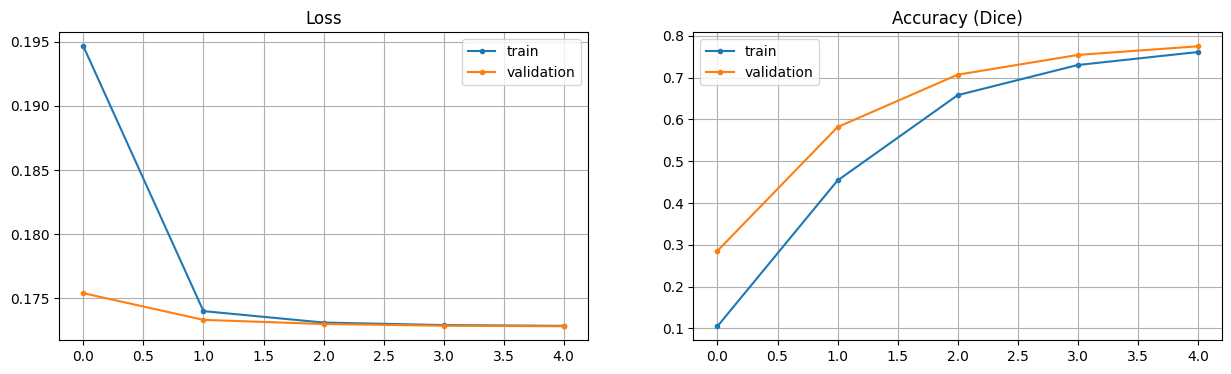

In [39]:
torch.manual_seed(SEED)

unet_model = smp.Unet("resnet18", classes=1, encoder_weights="imagenet")
unet_model = unet_model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in unet_model.parameters() if p.requires_grad))

# tunable params
BATCH_SIZE = 16
LR = 1e-4
N_EPOCHS = 5
INPUT_SIZE = (256,256)

TRAIN_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

VALID_AUGS = albu.Compose([
                albu.Resize(*INPUT_SIZE),
                albu.Normalize(),
            ])

SCHEDULER = None
multiple_ships_ratio_per_batch = 0.3629

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device)
metric_fn = dice_score

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_multiple_ships_ratio_per_batch(multiple_ships_ratio_per_batch)

unet_model_train.train(n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

### The results before the stratification was worse (at this stage). Going on...

In [ ]:
unet_model_train.save_model('strat_best_unet_1.pt')

Model saved to strat_best_unet_1.pt



Epoch  6/10
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.34it/s, loss 0.1727; dice 0.8226]
   Training Dice: 0.7952623053729794
   Training Loss: 0.17281400336338854
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:59<00:00,  8.70it/s]
   Validation Dice: 0.7979373445939741
   Validation Loss: 0.17282052162306913

Epoch  7/10
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.36it/s, loss 0.1726; dice 0.8248]
   Training Dice: 0.8059807873365671
   Training Loss: 0.1728021535408445
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:59<00:00,  8.70it/s]
   Validation Dice: 0.8078439921659474
   Validation Loss: 0.17279683725054537

Epoch  8/10
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.36it/s, loss 0.1726; dice 0.7169]
   Training Dice: 0.8159210813137688
   Training Loss: 0.17278966971674423
evaluation: 100%|█████████████████████████████████████████████████| 517/51

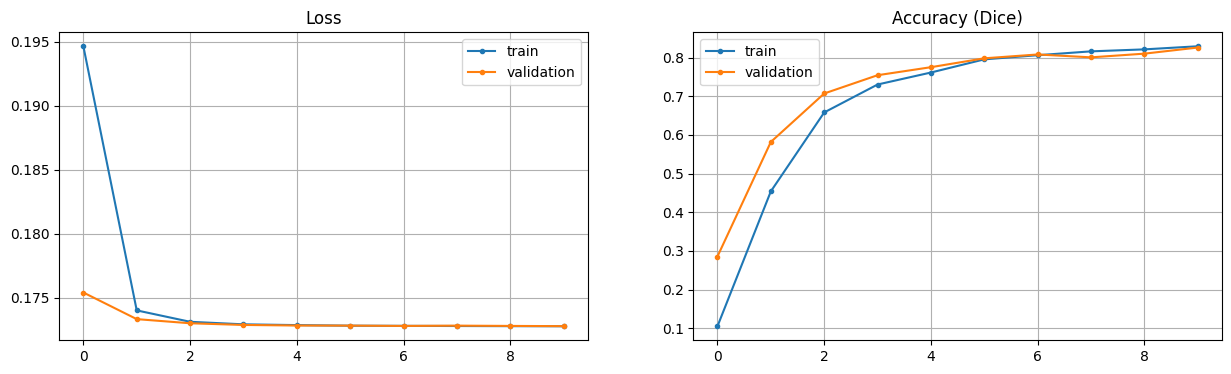

In [ ]:
torch.manual_seed(SEED)

LR = 1e-5

optimizer = optim.Adam(unet_model.parameters(), lr=LR)
SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)

unet_model_train.continue_training(current_epoch=5, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

In [ ]:
unet_model_train.save_model('strat_best_unet_2.pt')

Model saved to strat_best_unet_2.pt



Epoch 11/15
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.35it/s, loss 0.1726; dice 0.8452]
   Training Dice: 0.8298475029187367
   Training Loss: 0.17277007077182763
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:58<00:00,  8.87it/s]
   Validation Dice: 0.8190106434217966
   Validation Loss: 0.17279719623306503

Epoch 12/15
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.38it/s, loss 0.1725; dice 0.8494]
   Training Dice: 0.83346891747459
   Training Loss: 0.172767881827979
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:59<00:00,  8.75it/s]
   Validation Dice: 0.8256849032075538
   Validation Loss: 0.17277444622387508

Epoch 13/15
training: 100%|███████████████████████| 2069/2069 [04:40<00:00,  7.37it/s, loss 0.1724; dice 0.8610]
   Training Dice: 0.8409078046139339
   Training Loss: 0.1727583420311212
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [0

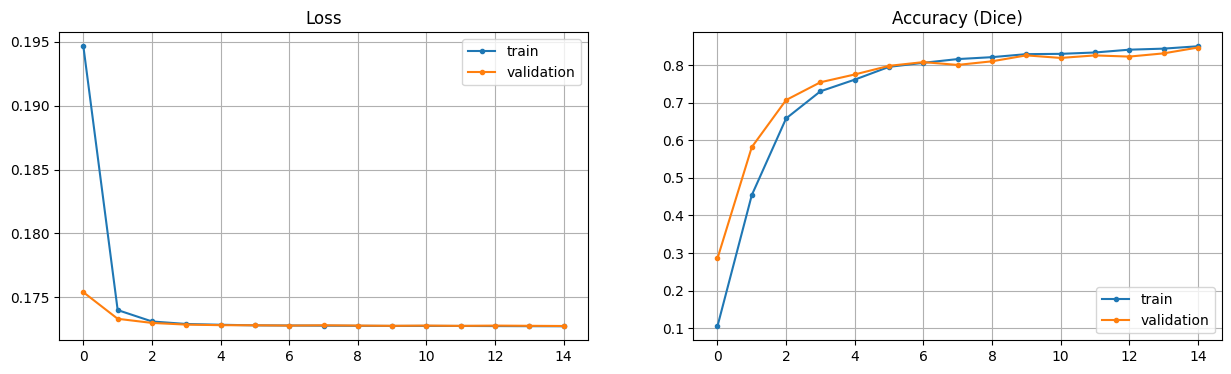

In [ ]:
torch.manual_seed(SEED)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=10, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

In [ ]:
unet_model_train.save_model('strat_best_unet_3.pt')

Model saved to strat_best_unet_3.pt



Epoch 16/20
training: 100%|███████████████████████| 2069/2069 [04:42<00:00,  7.34it/s, loss 0.1726; dice 0.8882]
   Training Dice: 0.854823375004625
   Training Loss: 0.1727447510701899
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:58<00:00,  8.82it/s]
   Validation Dice: 0.840696577292577
   Validation Loss: 0.17278380916819583

Epoch 17/20
training: 100%|███████████████████████| 2069/2069 [04:44<00:00,  7.29it/s, loss 0.1725; dice 0.8724]
   Training Dice: 0.8538779602527848
   Training Loss: 0.17274856749596143
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [00:59<00:00,  8.67it/s]
   Validation Dice: 0.8452516484076096
   Validation Loss: 0.17276700224359906

Epoch 18/20
training: 100%|███████████████████████| 2069/2069 [04:41<00:00,  7.35it/s, loss 0.1723; dice 0.8954]
   Training Dice: 0.857558724844496
   Training Loss: 0.1727427886758466
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [0

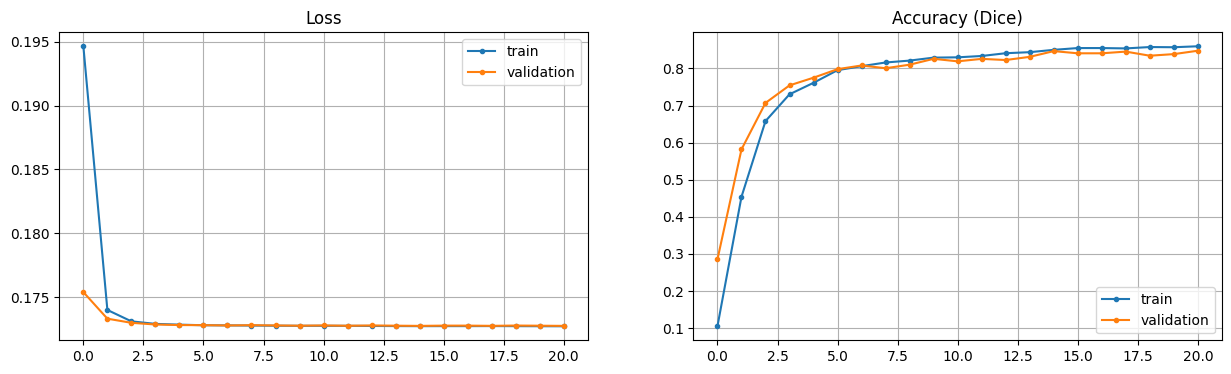

In [ ]:
torch.manual_seed(SEED)

LR = 1e-10
N_EPOCHS=5

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
unet_model_train.continue_training(current_epoch=15, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)

unet_model_train.plot_loss_acc_per_ep()

In [ ]:
unet_model_train.save_model('strat_best_unet_4.pt')

Model saved to strat_best_unet_4.pt


In [ ]:
torch.manual_seed(SEED)

LR = 1e-10
N_EPOCHS=5

optimizer = optim.Adam(unet_model.parameters(), lr=LR)

SCHEDULER = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=1, verbose=True)
loss_fn = smp.losses.FocalLoss(mode="binary").to(device)
metric_fn = dice_score

multiple_ships_ratio_per_batch = 0.3629

unet_model_train = TrainAndTestModel(model=unet_model, device=device, dataset_train=train_df, dataset_val=validation_df, 
                                     train_augs=TRAIN_AUGS, valid_augs=VALID_AUGS, images_dir=TRAIN_URL, input_size=INPUT_SIZE)

unet_model_train.set_multiple_ships_ratio_per_batch(multiple_ships_ratio_per_batch)

unet_model_train.continue_training(current_epoch=20, n_batch=BATCH_SIZE, n_epochs=N_EPOCHS, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 21/25
training: 100%|███████████████████████| 2069/2069 [07:13<00:00,  4.78it/s, loss 0.1726; dice 0.8882]
   Training Dice: 0.8548207933226318
   Training Loss: 0.17274475021313906
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:45<00:00,  4.89it/s]
   Validation Dice: 0.8406940512431198
   Validation Loss: 0.1727838067471174

Epoch 22/25
training: 100%|███████████████████████| 2069/2069 [06:39<00:00,  5.18it/s, loss 0.1725; dice 0.8724]
   Training Dice: 0.8538753503673373
   Training Loss: 0.17274856642284733
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:38<00:00,  5.26it/s]
   Validation Dice: 0.8452492320560625
   Validation Loss: 0.17276699999545483

Epoch 23/25
training: 100%|███████████████████████| 2069/2069 [06:16<00:00,  5.49it/s, loss 0.1723; dice 0.8954]
   Training Dice: 0.8575561087508314
   Training Loss: 0.17274278764594517
evaluation: 100%|█████████████████████████████████████████████████| 517/51

([0.17274475021313906,
  0.17274856642284733,
  0.17274278764594517,
  0.1727371157699302,
  0.17273303564618095],
 [0.1727838067471174,
  0.17276699999545483,
  0.17278993570712364,
  0.1727773362709429,
  0.1727644197311346],
 [0.8548207933226318,
  0.8538753503673373,
  0.8575561087508314,
  0.8570468269897118,
  0.8596213147109001],
 [0.8406940512431198,
  0.8452492320560625,
  0.8341845924204047,
  0.8385112095386424,
  0.8476133434754045])

In [ ]:
unet_model_train.save_model('strat_best_unet_5.pt')

Model saved to strat_best_unet_5.pt


In [ ]:
LR = 1e-16
optimizer = optim.Adam(unet_model.parameters(), lr=LR)

unet_model_train.continue_training(current_epoch=25, n_batch=BATCH_SIZE, n_epochs=1, optimizer=optimizer, loss_fn=loss_fn, metric_fn=metric_fn, scheduler=SCHEDULER)


Epoch 26/26
training: 100%|███████████████████████| 2069/2069 [05:40<00:00,  6.08it/s, loss 0.1726; dice 0.8882]
   Training Dice: 0.8548185579900064
   Training Loss: 0.1727447495289388
evaluation: 100%|█████████████████████████████████████████████████| 517/517 [01:20<00:00,  6.41it/s]
   Validation Dice: 0.8406921894914638
   Validation Loss: 0.17278380608420307


([0.17274475021313906,
  0.17274856642284733,
  0.17274278764594517,
  0.1727371157699302,
  0.17273303564618095,
  0.1727447495289388],
 [0.1727838067471174,
  0.17276699999545483,
  0.17278993570712364,
  0.1727773362709429,
  0.1727644197311346,
  0.17278380608420307],
 [0.8548207933226318,
  0.8538753503673373,
  0.8575561087508314,
  0.8570468269897118,
  0.8596213147109001,
  0.8548185579900064],
 [0.8406940512431198,
  0.8452492320560625,
  0.8341845924204047,
  0.8385112095386424,
  0.8476133434754045,
  0.8406921894914638])

### overfit. Reverting back and assessing...

In [ ]:
checkpoint = torch.load('/kaggle/working/strat_best_unet_5.pt')
unet_model.load_state_dict(checkpoint)

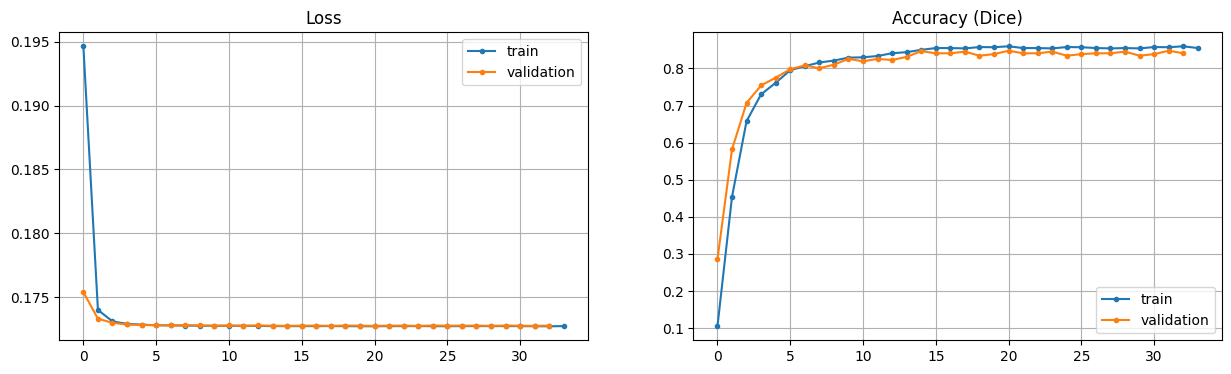

In [ ]:
unet_model_train.plot_loss_acc_per_ep()

#### Summary:
#### Model 1 (no ship stratification):  Dice 0.84251    Loss 0.17275
#### Model 2 (ship stratification):     Dice 0.84761    Loss 0.17276

## Visualizing

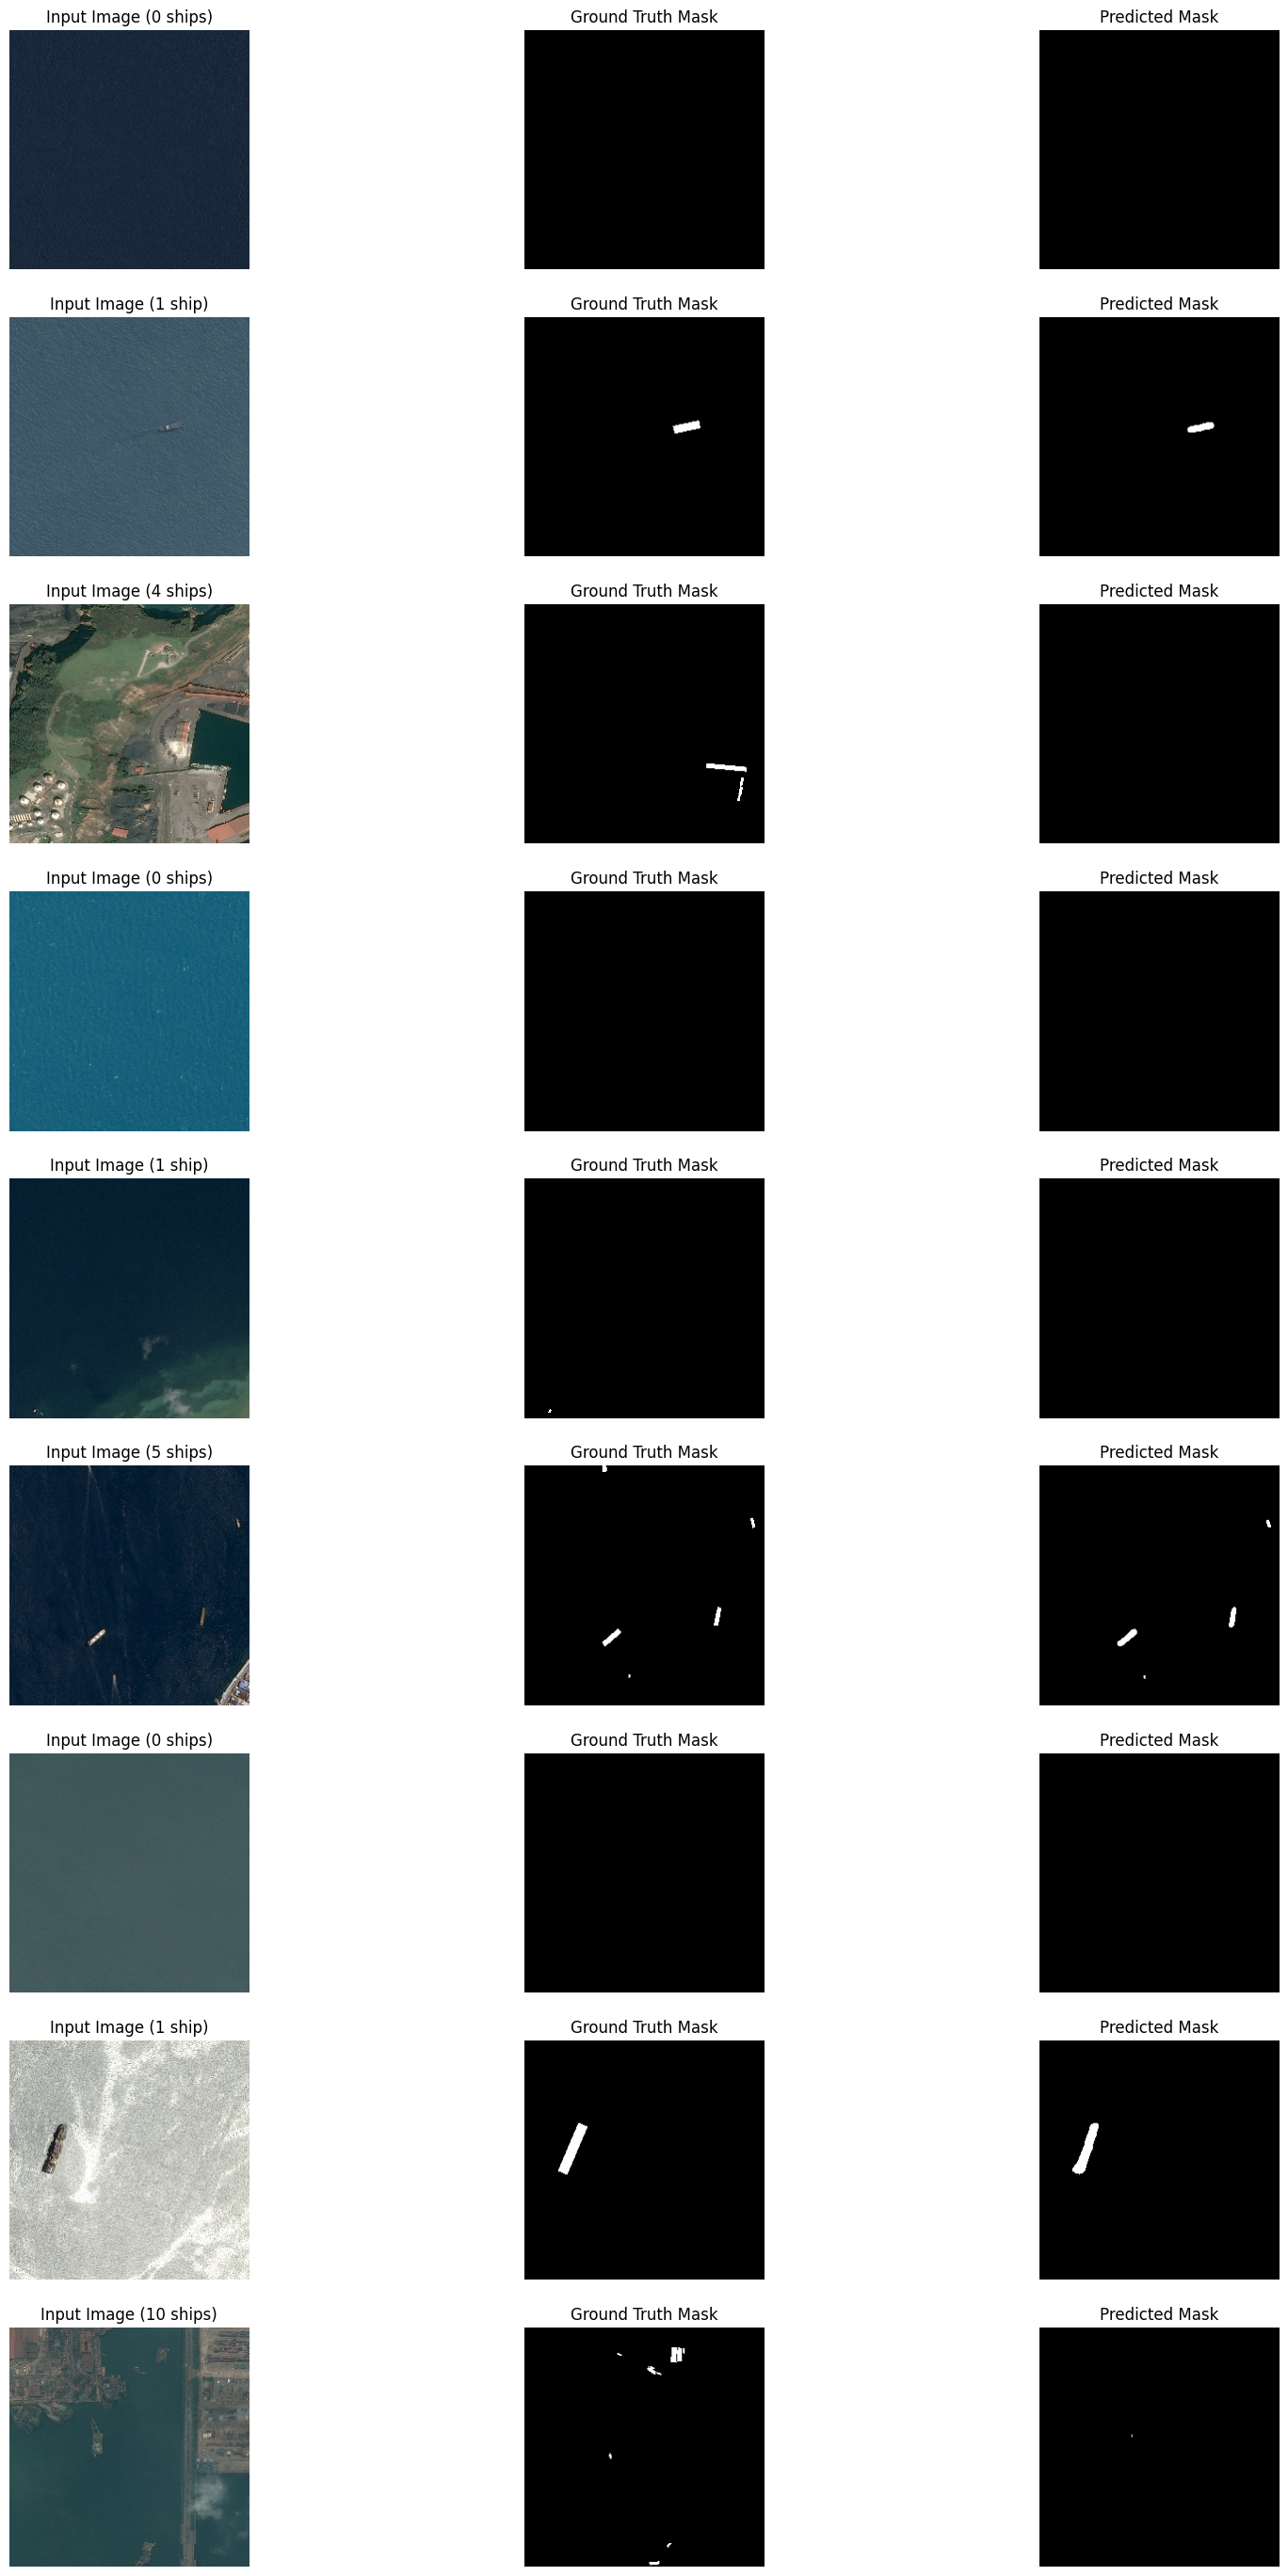

In [ ]:
INPUT_SIZE = (256,256)
THRESHOLD = 1e-2

VALID_AUGS = albu.Compose([
            albu.Resize(*INPUT_SIZE),
            albu.Normalize(),
        ])

no_ships_images = ['f999ee8f8.jpg', 'b580b30d8.jpg', 'b8aa20450.jpg']
single_ship_images = ['819d73d7f.jpg', '18f8bd19a.jpg', '23e6b9ab2.jpg']
multiple_ships_images = ['1a7ae404b.jpg', 'df36a66aa.jpg', '5ef5e8aa9.jpg']

ROWS_PER_IMAGE = max(len(no_ships_images), len(single_ship_images), len(multiple_ships_images))*3

fig = plt.figure(figsize=(20, 35))    
axis = fig.subplots(ROWS_PER_IMAGE,3)

for i, no_ship_img in enumerate(no_ships_images):
    plot_the_image(os.path.join(TRAIN_URL, no_ship_img), axis[i*3, 0], INPUT_SIZE)
    
    axis[i*3, 0].set_title('Input Image (0 ships)')
    axis[i*3, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==no_ship_img]['EncodedPixels'], axis[i*3, 1], INPUT_SIZE)

    axis[i*3, 1].set_title('Ground Truth Mask')
    axis[i*3, 1].axis('off')
    
    predicted_mask = get_prediction(unet_model, no_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3, 2].set_title('Predicted Mask')
    axis[i*3, 2].axis('off')
    
for i, single_ship_img in enumerate(single_ship_images):
    plot_the_image(os.path.join(TRAIN_URL, single_ship_img), axis[i*3+1, 0], INPUT_SIZE)
    
    axis[i*3+1, 0].set_title('Input Image (1 ship)')
    axis[i*3+1, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==single_ship_img]['EncodedPixels'], axis[i*3+1, 1], INPUT_SIZE)
    
    axis[i*3+1, 1].set_title('Ground Truth Mask')
    axis[i*3+1, 1].axis('off')

    predicted_mask = get_prediction(unet_model, single_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3+1, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+1, 2].set_title('Predicted Mask')
    axis[i*3+1, 2].axis('off')
    
for i, mult_ship_img in enumerate(multiple_ships_images):
    plot_the_image(os.path.join(TRAIN_URL, mult_ship_img), axis[i*3+2, 0], INPUT_SIZE)
    
    axis[i*3+2, 0].set_title('Input Image (' + str(validation_df[validation_df['ImageId']==mult_ship_img]['Ships'].values[0]) + ' ships)')
    axis[i*3+2, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==mult_ship_img]['EncodedPixels'], axis[i*3+2, 1], INPUT_SIZE)
    
    axis[i*3+2, 1].set_title('Ground Truth Mask')
    axis[i*3+2, 1].axis('off')

    predicted_mask = get_prediction(unet_model, mult_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3+2, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+2, 2].set_title('Predicted Mask')
    axis[i*3+2, 2].axis('off')

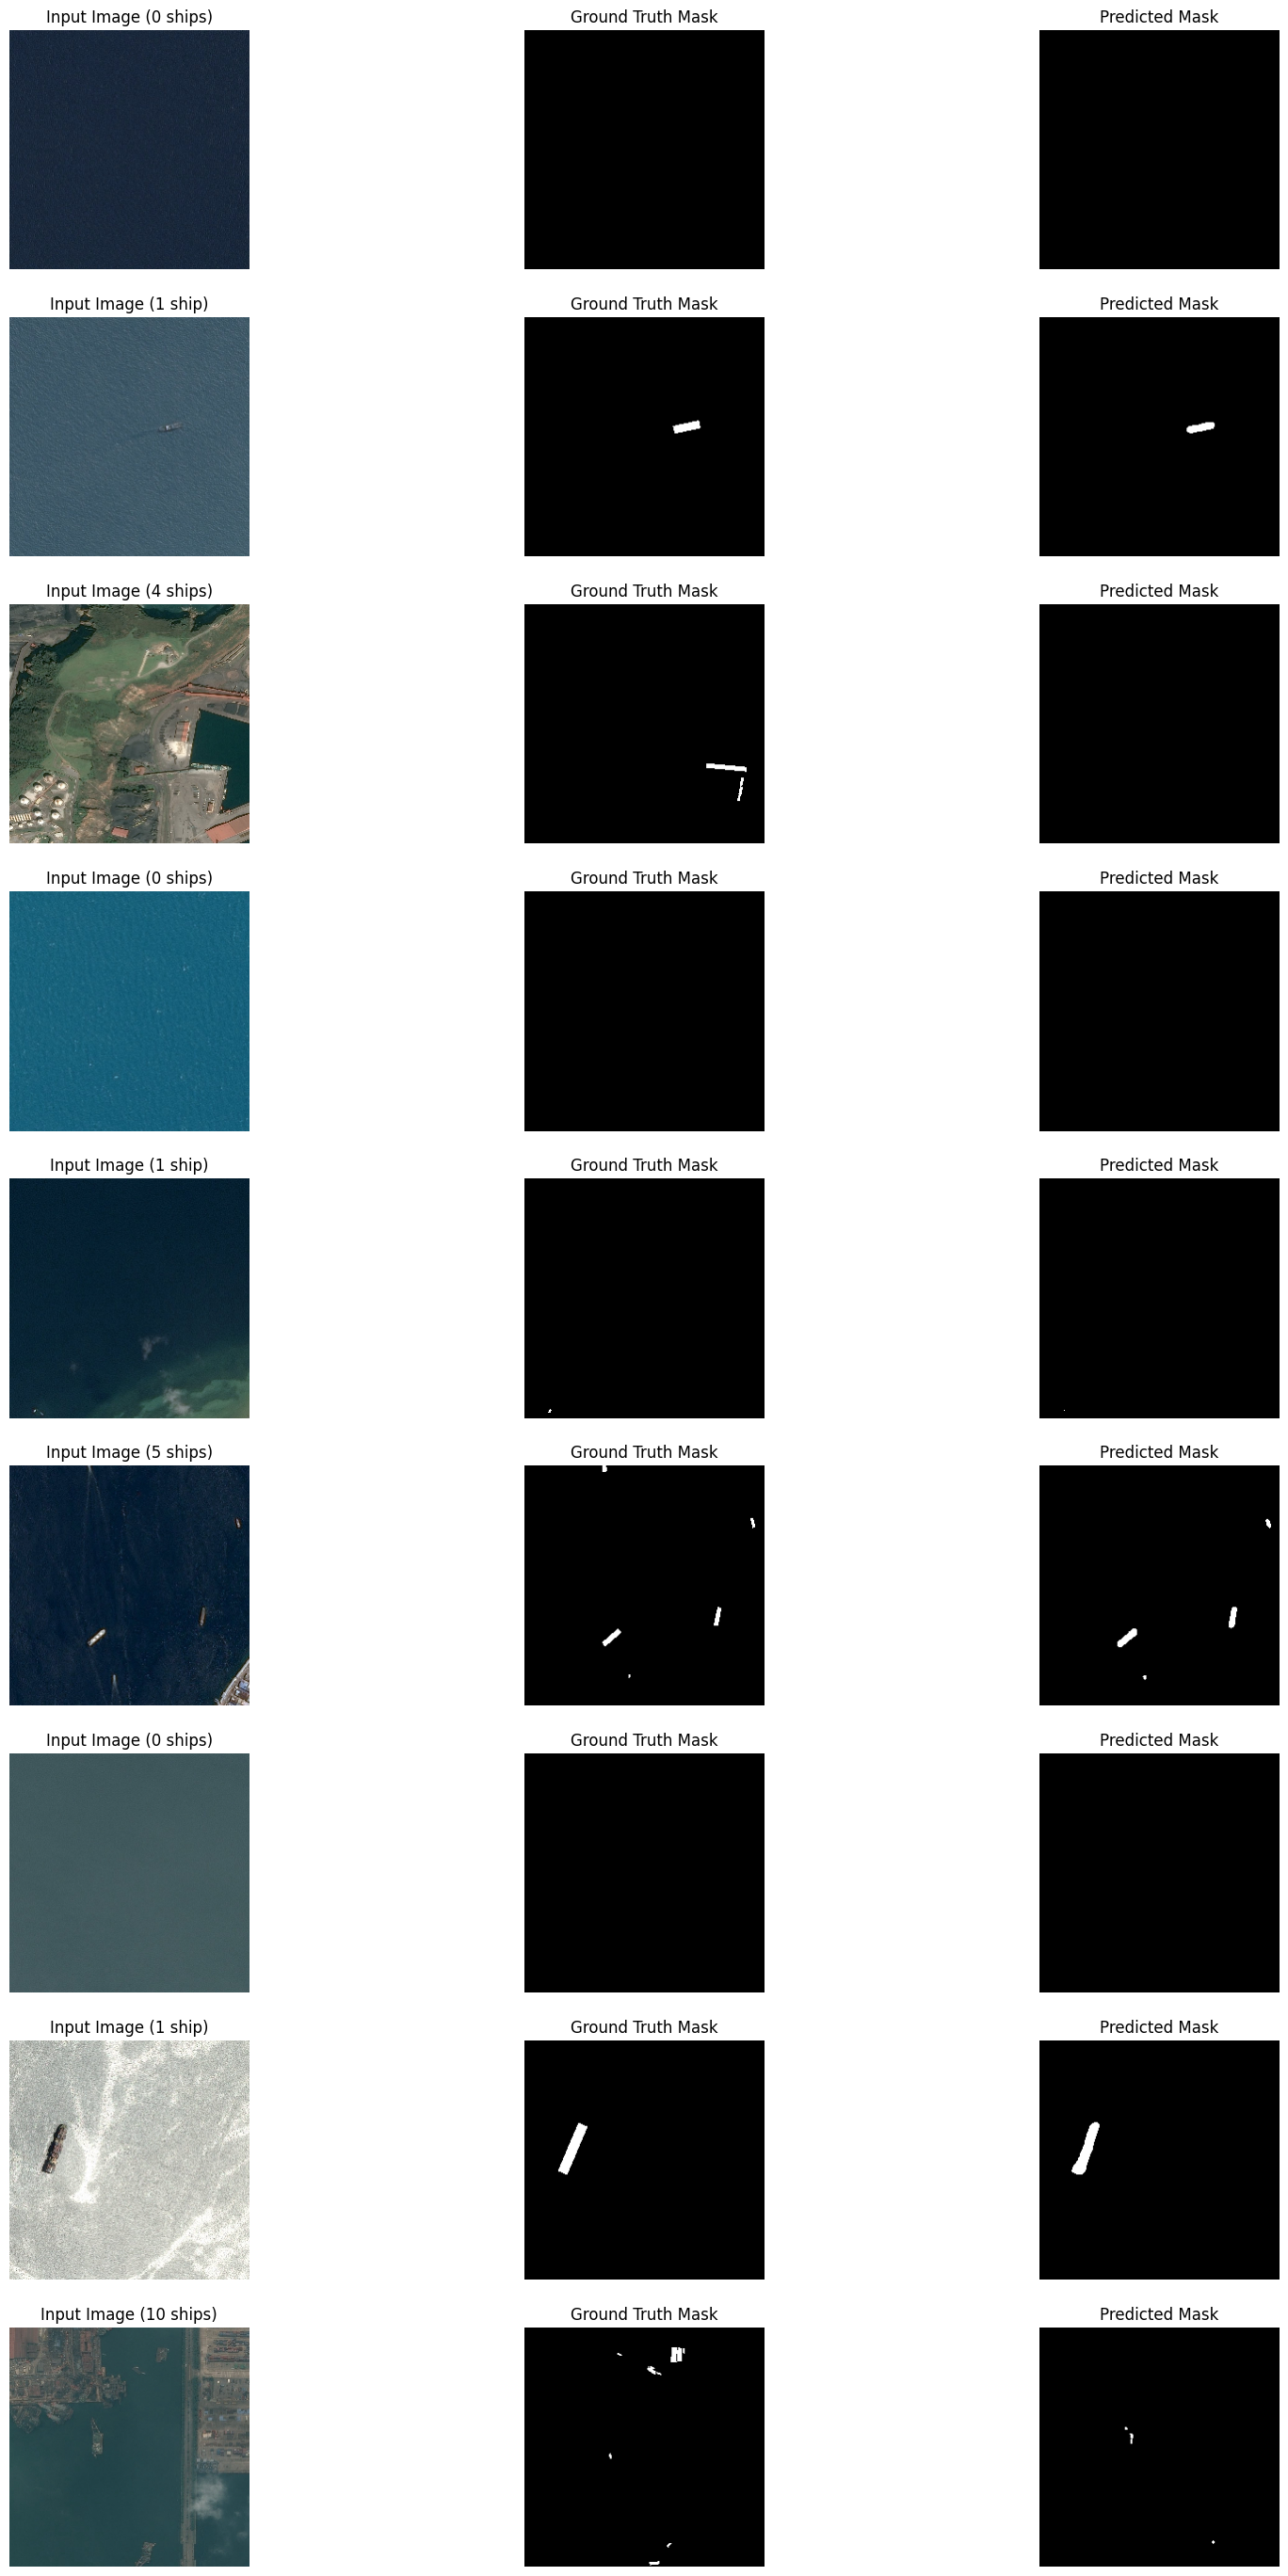

In [ ]:
INPUT_SIZE = (256,256)
THRESHOLD = 0.0004

no_ships_images = ['f999ee8f8.jpg', 'b580b30d8.jpg', 'b8aa20450.jpg']
single_ship_images = ['819d73d7f.jpg', '18f8bd19a.jpg', '23e6b9ab2.jpg']
multiple_ships_images = ['1a7ae404b.jpg', 'df36a66aa.jpg', '5ef5e8aa9.jpg']

ROWS_PER_IMAGE = max(len(no_ships_images), len(single_ship_images), len(multiple_ships_images))*3

fig = plt.figure(figsize=(20, 35))    
axis = fig.subplots(ROWS_PER_IMAGE,3)

for i, no_ship_img in enumerate(no_ships_images):
    plot_the_image(os.path.join(TRAIN_URL, no_ship_img), axis[i*3, 0], INPUT_SIZE)
    
    axis[i*3, 0].set_title('Input Image (0 ships)')
    axis[i*3, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==no_ship_img]['EncodedPixels'], axis[i*3, 1], INPUT_SIZE)

    axis[i*3, 1].set_title('Ground Truth Mask')
    axis[i*3, 1].axis('off')
    
    predicted_mask = get_prediction(unet_model, no_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3, 2].set_title('Predicted Mask')
    axis[i*3, 2].axis('off')
    
for i, single_ship_img in enumerate(single_ship_images):
    plot_the_image(os.path.join(TRAIN_URL, single_ship_img), axis[i*3+1, 0], INPUT_SIZE)
    
    axis[i*3+1, 0].set_title('Input Image (1 ship)')
    axis[i*3+1, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==single_ship_img]['EncodedPixels'], axis[i*3+1, 1], INPUT_SIZE)
    
    axis[i*3+1, 1].set_title('Ground Truth Mask')
    axis[i*3+1, 1].axis('off')

    predicted_mask = get_prediction(unet_model, single_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3+1, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+1, 2].set_title('Predicted Mask')
    axis[i*3+1, 2].axis('off')
    
for i, mult_ship_img in enumerate(multiple_ships_images):
    plot_the_image(os.path.join(TRAIN_URL, mult_ship_img), axis[i*3+2, 0], INPUT_SIZE)
    
    axis[i*3+2, 0].set_title('Input Image (' + str(validation_df[validation_df['ImageId']==mult_ship_img]['Ships'].values[0]) + ' ships)')
    axis[i*3+2, 0].axis('off')
    
    plot_the_mask(validation_df[validation_df['ImageId']==mult_ship_img]['EncodedPixels'], axis[i*3+2, 1], INPUT_SIZE)
    
    axis[i*3+2, 1].set_title('Ground Truth Mask')
    axis[i*3+2, 1].axis('off')

    predicted_mask = get_prediction(unet_model, mult_ship_img, INPUT_SIZE)
    predicted_mask = apply_threshold(predicted_mask, THRESHOLD)

    axis[i*3+2, 2].imshow(predicted_mask, cmap='gray')
    axis[i*3+2, 2].set_title('Predicted Mask')
    axis[i*3+2, 2].axis('off')

#### Summary: the optimal threshold for the second model is 0.0004. It does better identifying multiple ships, but more biased towards fewer-ship predictions.

## 8. Conclusion

### The first model is more suitable for identifying fewer ships. With its optimal threshold it shows a good trade-off between the noise (false positives) and identified ships. The second model results in better predictions for larger groups of ships, while being more biased towards fewer-ship predictions. The appropriate model should be chosen according to the final objective.

### The summary of the two models is presented below:

|                                | Dice      | Loss      |   Best threshold                             | Application |
|--------------------------------|-----------|-----------|---------|----------------------------------------------|
| Model 1 (simple)              | 0.84251    | 0.17275    |   1e-2    | fewer ships   |
| Model 2 (stratified by ships) | 0.84761    | 0.17276    | 4e-4    | larger groups |


### Model 1 (simple) training pipeline:

#### Part 1

|Model 1 (part 1)|               |                |                |                |            
|------|----------------|----------------|----------------|----------------|
| learning rate  | 1e-4 | 1e-5           | 1e-5           | 1e-10          |
| batch size  | 16      | 16             | 16             | 16             |
| epochs   | 5          | 5              | 5              | 1              |
| augs | norm + reshape | norm + reshape | norm + reshape | norm + reshape |
| optim| Adam           | Adam           | Adam           | Adam           |
| dice | 0.75926        | 0.81629        | 0.83660        | 0.841535       |
| loss | 0.17284        | 0.17279        | 0.17277        | 0.172753       |
| shape| 256x256        | 256x256        | 256x256        | 256x256        |
| scheduler| -          | redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)|

#### Part 2

|Model 1 (part 2)|      |                |                |                |            
|------|----------------|----------------|----------------|----------------|
| learning rate | 1e-10 | 1e-10          | 1e-10          | 1e-10          |
| batch size  | 16      | 16             | 16             | 16             |
| epochs   | 1          | 1              | 1              | 1              |
| augs | norm + reshape | norm + reshape | norm + reshape | norm + reshape |
| optim| Adam           | Adam           | Adam           | Adam           |
| dice | 0.841536       | 0.841536       | 0.841536       | 0.841536       |
| loss | 0.172753       | 0.172753       | 0.172753       | 0.172753       |
| shape| 256x256        | 256x256        | 256x256        | 256x256        |
| scheduler| redLROnPlat(max,0.1,1)      | redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)|

#### Part 3

|Model 1 (part 3)|      |                |                |                |     |        
|------|----------------|----------------|----------------|----------------|-----|
| learning rate | 1e-9  | 1e-8           | 1e-7           | 1e-8           | 1e-9|
| batch size  | 16      | 16             | 16             | 16             | 16 |
| epochs   | 1          | 1              | 2              | 1              | 1 |
| augs | norm + reshape | norm + reshape | norm + reshape | norm + reshape | norm+reshape |
| optim| Adam           | Adam           | Adam           | Adam           | Adam |
| dice | 0.841539       | 0.841661       | 0.84222        | 0.84252        | 0.84251 |
| loss | 0.172753       | 0.172753       | 0.17274        | 0.17275        | 0.17275 |
| shape| 256x256        | 256x256        | 256x256        | 256x256        | 256x256 |
| scheduler| redLROnPlat(max,0.1,1)      | redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)|redLROnPlat(max,0.1,1)|



### Model 2 (ship-stratified) training pipeline:

#### Part 1

|Model 2|               |                |                |                |            
|------|----------------|----------------|----------------|----------------|
| learning rate  | 1e-4 | 1e-5           | 1e-5           | 1e-10          |
| batch size  | 16      | 16             | 16             | 16             |
| epochs   | 5          | 5              | 5              | 5              |
| augs | norm + reshape | norm + reshape | norm + reshape | norm + reshape |
| optim| Adam           | Adam           | Adam           | Adam           |
| dice | 0.77497        | 0.82578        | 0.84657        | 0.84761        |
| loss | 0.17282        | 0.17277        | 0.17276        | 0.17276        |
| shape| 256x256        | 256x256        | 256x256        | 256x256        |
| scheduler| -          | redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)| redLROnPlat(max,0.1,1)|

#### Part 2

|Model 2|               |                
|------|----------------|
| learning rate  | 1e-10|
| batch size  | 16      |
| epochs   | 5          |
| augs | norm + reshape |
| optim| Adam           |
| dice | 0.84761        |
| loss | 0.17276        |
| shape| 256x256        |
| scheduler| redLROnPlat(max,0.1,1)      |